In [1]:
import yfinance as yf
import pandas as pd
import zipfile
import json
from lxml import etree
from io import StringIO
from datetime import date
from tqdm.notebook import tqdm
import requests
from matplotlib import pyplot as plt
import seaborn as sns
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import os
import pickle
import numpy as np

In [2]:
# Set directory and device
# set device
device = torch.device(0 if torch.cuda.is_available() else -1)
print('Device:', device)

# set directory for data and model
data_dir = 'dataset/'
model_dir = 'model/'
# create directory for data
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(model_dir):
    os.makedirs(model_dir)


Device: cuda:0


In [3]:
# List of tickers / companies
temp = pd.read_csv('dataset/combined_2012-01-01_2022-12-31.csv')
companies = temp['ticker'].unique().tolist()
companies_full_name = temp['company_name'].unique().tolist()
# selected_companies = ['GOOGL', 'META', 'BIDU', 'PINS', 'DASH']
# selected_companies = ['GOOGL', 'META', 'BIDU']
# selected_companies = ['META']
# selected_companies = ['ADD', 'AMC', 'AMCX', 'ANGI', 'AREN', 'ATHM', 'BIDU', 'BKNG', 'CCL', 'CMCM', 'CNK', 'CNVS', 'DIS', 'DLPN', 'EXPE', 'FENG', 'FWONA', 'GAIA', 'GNUS', 'GOOGL', 'GRPN', 'IAC', 'IMAX', 'IZEA', 'LIND', 'LOV', 'LTRPA', 'LYV', 'MANU', 'MCS', 'META', 'MMYT', 'MOMO', 'MSGS', 'MTCH', 'NCLH', 'NFLX', 'NWSA', 'NXST', 'PARA', 'PERI', 'PLAY', 'RCL', 'RDI', 'SABR', 'SBGI', 'SCOR', 'SIRI', 'SSTK', 'TCOM', 'TNL', 'TOUR', 'TRIP', 'TRUE', 'TTGT', 'WB', 'WBD', 'WWE', 'YELP', 'YY', 'Z']
# selected_companies = ['ADD', 'AMC', 'AMCX']
selected_companies = ['ANGI', 'AREN', 'ATHM', 'BIDU', 'BKNG', 'CCL', 'CMCM', 'CNK', 'CNVS', 'DIS', 'DLPN', 'EXPE', 'FENG', 'FWONA', 'GAIA', 'GNUS', 'GOOGL', 'GRPN', 'IAC', 'IMAX', 'IZEA', 'LIND', 'LOV', 'LTRPA', 'LYV', 'MANU', 'MCS', 'META', 'MMYT', 'MOMO', 'MSGS', 'MTCH', 'NCLH', 'NFLX', 'NWSA', 'NXST', 'PARA', 'PERI', 'PLAY', 'RCL', 'RDI', 'SABR', 'SBGI', 'SCOR', 'SIRI', 'SSTK', 'TCOM', 'TNL', 'TOUR', 'TRIP', 'TRUE', 'TTGT', 'WB', 'WBD', 'WWE', 'YELP', 'YY', 'Z']


In [4]:
print(selected_companies[41])

SABR


Historical Stock Data

In [ ]:
# fetch historical stock data from 2012-01-01 to 2022-12-31
company_list = companies
start_date = '2012-01-01'
end_date = '2022-12-31'
filename = data_dir + 'historical_stock_data.csv'

def save_historical_data_to_csv(companies, start_date, end_date, filename):
    data = pd.DataFrame()

    for company in companies:
        print(f'Retrieving data for {company}...')
        stock_data = yf.download(company, start=start_date, end=end_date)
        if not stock_data.empty:
            stock_data['Company'] = company
            data = pd.concat([data, stock_data]) 
        else:
            print(f'No data available for {company}.')
        print()

    if not data.empty:
        data.to_csv(filename)
        print(f'Historical stock data saved to {filename}.')
    else:
        print('No data available for any company.')

save_historical_data_to_csv(company_list, start_date, end_date, filename)

In [25]:
# load stock data from csv file instead of fetching from Yahoo Finance
path = data_dir + 'historical_stock_data.csv'
df_stock = pd.read_csv(path, index_col=0, parse_dates=True)
display(df_stock.head())
print(df_stock.shape)


Open        High         Low       Close   Adj Close  \
Date                                                                     
2020-12-10  146.000000  165.000000  141.250000  144.710007  144.710007   
2020-12-11  146.550003  151.500000  135.100006  139.250000  139.250000   
2020-12-14  135.000000  135.300003  125.160004  130.000000  130.000000   
2020-12-15  126.690002  127.599998  121.500000  124.800003  124.800003   
2020-12-16  125.830002  142.000000  124.910004  137.990005  137.990005   

              Volume Company  
Date                          
2020-12-10  70447500    ABNB  
2020-12-11  26980800    ABNB  
2020-12-14  16966100    ABNB  
2020-12-15  10914400    ABNB  
2020-12-16  20409600    ABNB

(210896, 7)


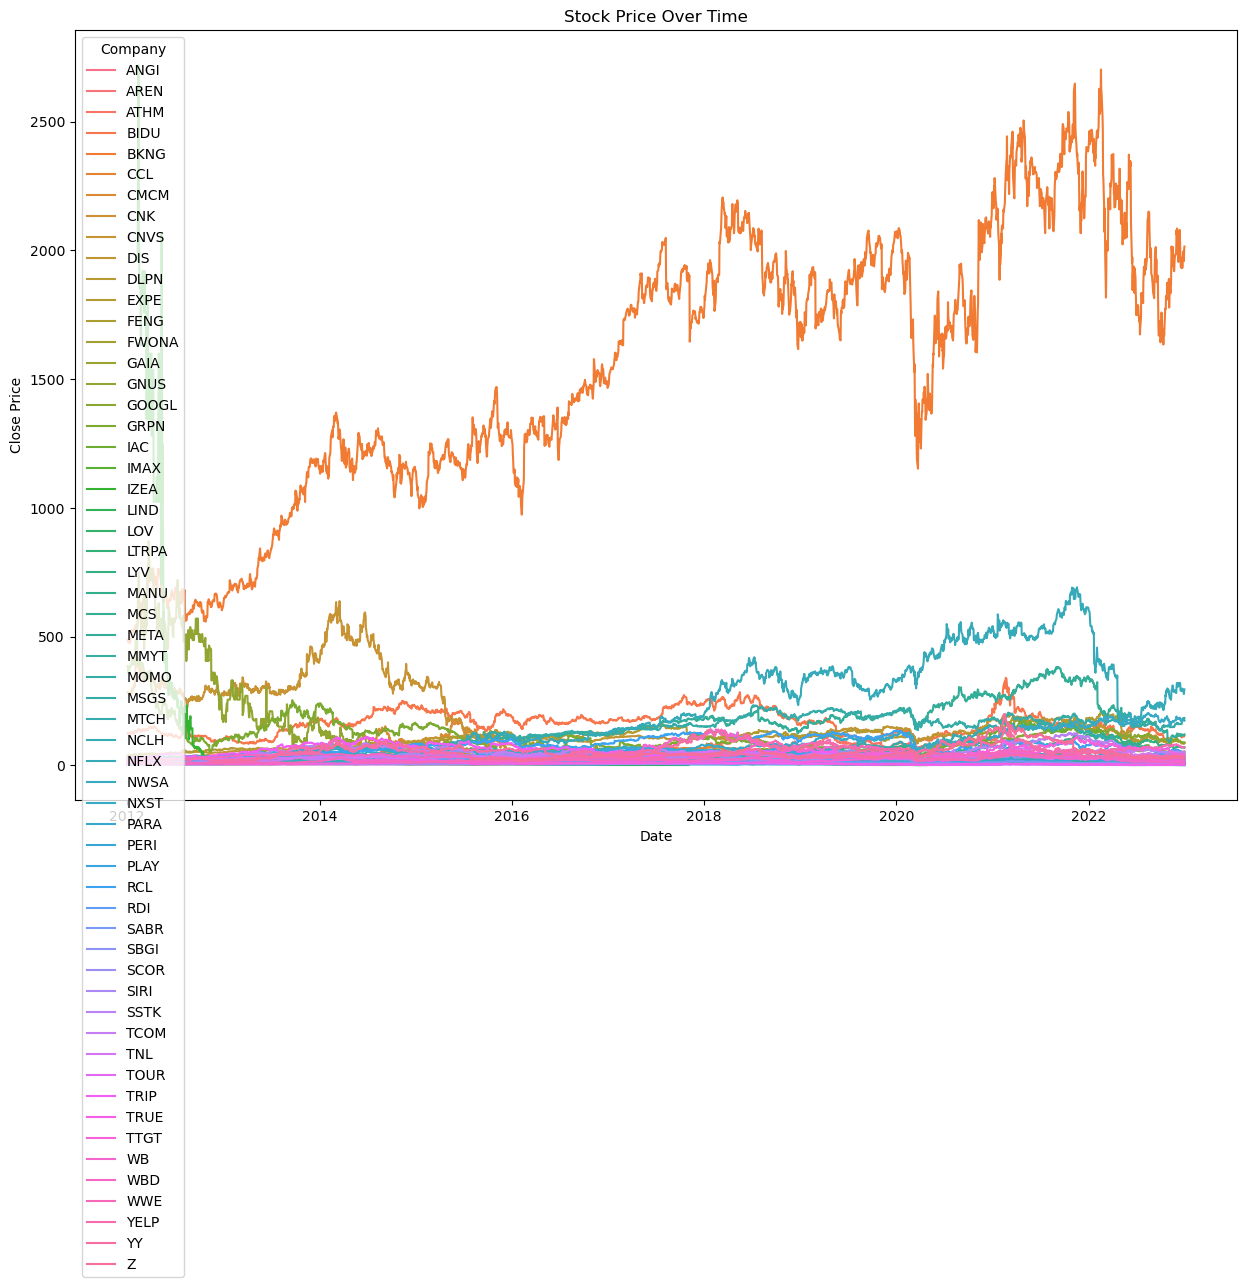

In [26]:
# plot historical stock data
temp = df_stock[df_stock['Company'].isin(selected_companies)]
plt.figure(figsize=(15, 10))
sns.lineplot(data=temp, x='Date', y='Close', hue='Company')
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [27]:
# calculate daily returns for each company using pct_change() of closing price
df_stock['daily_return'] = df_stock.groupby('Company')['Close'].pct_change()
df_stock = df_stock.copy()
df_stock = df_stock.reset_index()
display(df_stock[df_stock['Company'] == 'YELP'].head(5))

Date       Open       High        Low  Close  Adj Close   Volume  \
200134 2012-03-02  22.010000  26.000000  22.000000  24.58      24.58  4809400   
200135 2012-03-05  24.850000  24.860001  20.900000  20.99      20.99  2988200   
200136 2012-03-06  19.830000  20.500000  19.360001  20.50      20.50  1154300   
200137 2012-03-07  20.450001  20.629999  19.950001  20.25      20.25   444800   
200138 2012-03-08  20.299999  20.389999  19.959999  20.00      20.00   436900   

       Company  daily_return  
200134    YELP           NaN  
200135    YELP     -0.146054  
200136    YELP     -0.023344  
200137    YELP     -0.012195  
200138    YELP     -0.012346

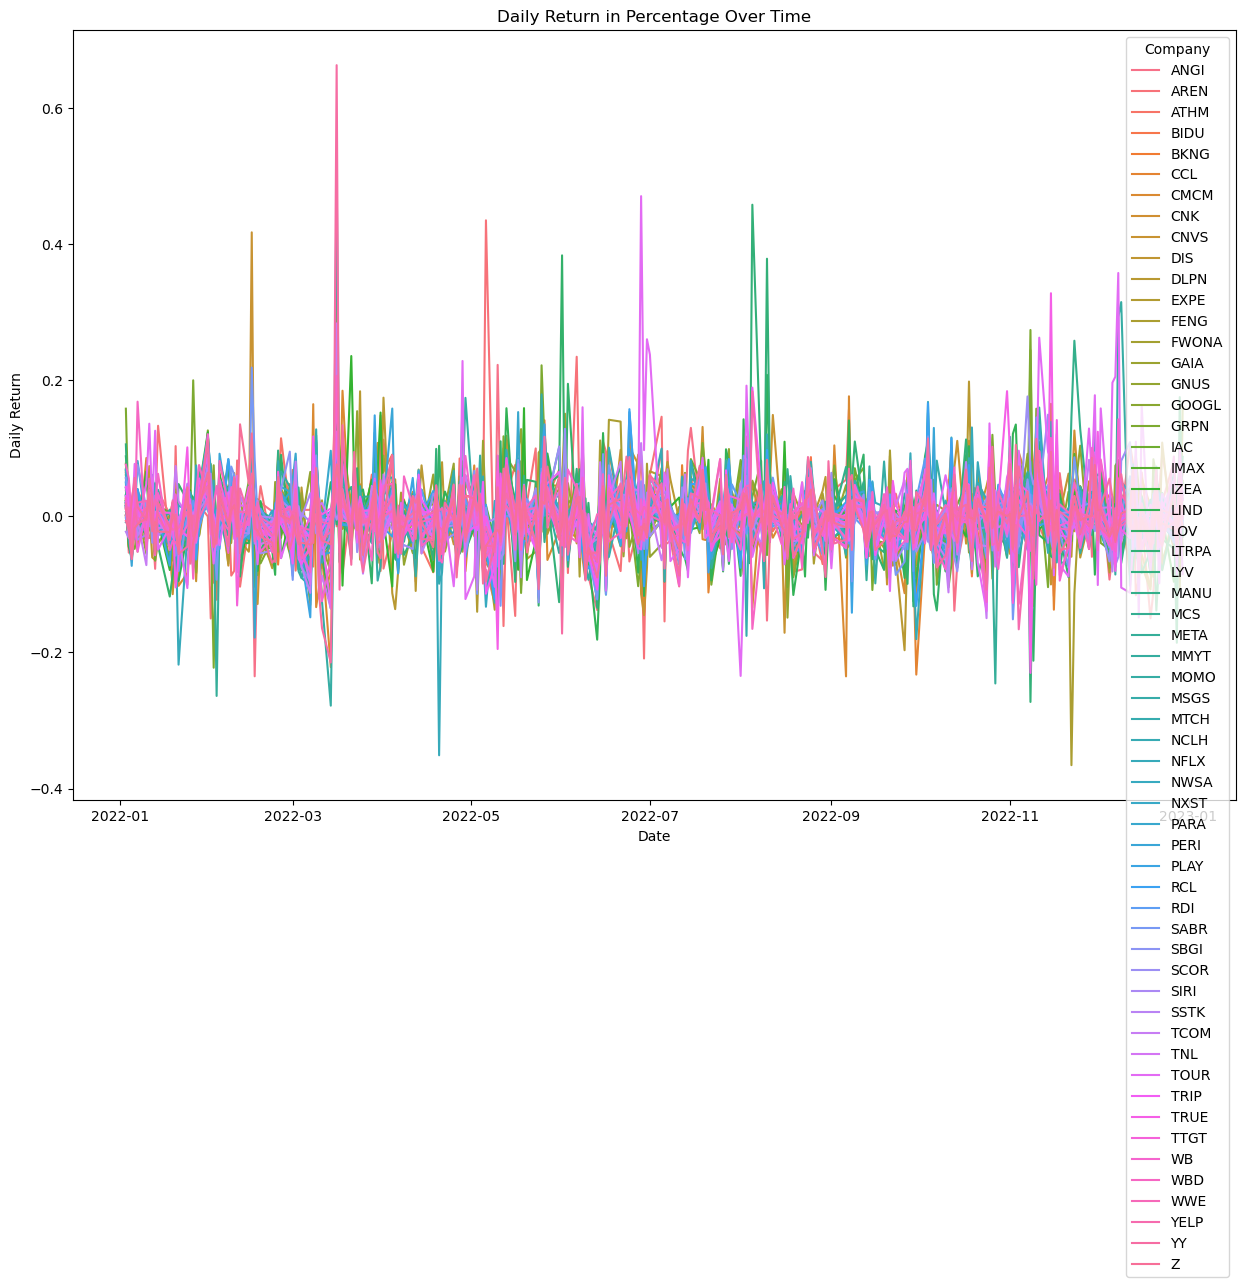

In [28]:
# plot daily returns for selected companies 
temp = df_stock[df_stock['Company'].isin(selected_companies)]
start_date = '2022-01-01'
end_date = '2022-12-31'
temp = temp[(temp['Date'] >= start_date) & (temp['Date'] <= end_date)]
plt.figure(figsize=(15, 10))
sns.lineplot(data=temp, x='Date', y='daily_return', hue='Company')
plt.title('Daily Return in Percentage Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.show()

Fetching News Headlines and Sentiment Analysis

In [29]:
# load sentiment analysis data
path = data_dir + 'combined_2012-01-01_2022-12-31.csv'
df_sentiment = pd.read_csv(path)
df_sentiment = df_sentiment.rename(columns={"ticker": "Company", "end": "Date"})
df_sentiment['Date'] = df_sentiment['Date'].str[:7] # keep only year and month
df_sentiment['Date'] = pd.to_datetime(df_sentiment['Date']) + pd.offsets.MonthEnd(1) # set date to end of month
display(df_sentiment.head(5))
print(df_sentiment.shape)

Company       start       Date  sentiment_company         industry  \
0    ABNB  2012-01-01 2012-01-31                0.0  travel-services   
1    ABNB  2012-02-01 2012-02-29                0.0  travel-services   
2    ABNB  2012-03-01 2012-03-31                0.0  travel-services   
3    ABNB  2012-04-01 2012-04-30                0.0  travel-services   
4    ABNB  2012-05-01 2012-05-31                0.0  travel-services   

   sentiment_industry  sentiment  company_name  
0           -0.047717  -0.047717  Airbnb, Inc.  
1           -0.200013  -0.200013  Airbnb, Inc.  
2           -0.199878  -0.199878  Airbnb, Inc.  
3            0.000245   0.000245  Airbnb, Inc.  
4            0.250073   0.250073  Airbnb, Inc.

(16764, 8)


In [30]:
# resample sentiment analysis data to daily frequency by filling all dates with the same value as the last date of the month
df_sentiment["start"] = pd.to_datetime(df_sentiment["start"])
start_date = max(df_sentiment['start'].min(), df_stock['Date'].min())
end_date = min(df_sentiment['Date'].max(), df_stock['Date'].max())
df_sentiment_list = []

for company in companies:
    df_company = df_sentiment[df_sentiment['Company'] == company]
    df_company = df_company.set_index('Date')
    df_company = df_company.resample('D').bfill() # resample frequency to daily and fill missing dates with next available value
    
    # fill missing values at the beginning of the dataframe
    temp = df_company.iloc[0]
    temp = pd.DataFrame(temp).transpose()
    date = temp.index.item()
    date_range = pd.date_range(start = date.replace(day=1), end = date, freq='D') # create date range from start of month to first date in dataframe
    temp = pd.DataFrame(temp, index=date_range) # create dataframe with date range
    temp = temp.fillna(method='bfill') # fill missing values with next available value
    temp.index.names = ['Date'] # rename index


    df_company = pd.concat([temp, df_company]) 
    df_company = df_company[~df_company.index.duplicated(keep='first')] # remove duplicate dates
    df_sentiment_list.append(df_company)

df_sentiment = pd.concat(df_sentiment_list)
df_sentiment = df_sentiment.reset_index()
display(df_sentiment.head(10))
print(df_sentiment.shape)


Date Company      start  sentiment_company         industry  \
0 2012-01-01    ABNB 2012-01-01                0.0  travel-services   
1 2012-01-02    ABNB 2012-01-01                0.0  travel-services   
2 2012-01-03    ABNB 2012-01-01                0.0  travel-services   
3 2012-01-04    ABNB 2012-01-01                0.0  travel-services   
4 2012-01-05    ABNB 2012-01-01                0.0  travel-services   
5 2012-01-06    ABNB 2012-01-01                0.0  travel-services   
6 2012-01-07    ABNB 2012-01-01                0.0  travel-services   
7 2012-01-08    ABNB 2012-01-01                0.0  travel-services   
8 2012-01-09    ABNB 2012-01-01                0.0  travel-services   
9 2012-01-10    ABNB 2012-01-01                0.0  travel-services   

   sentiment_industry  sentiment  company_name  
0           -0.047717  -0.047717  Airbnb, Inc.  
1           -0.047717  -0.047717  Airbnb, Inc.  
2           -0.047717  -0.047717  Airbnb, Inc.  
3           -0.047717  -0.047717  Airbnb, Inc.  
4           -0.047717  -0.047717  Airbnb, Inc.  
5           -0.047717  -0.047717  Airbnb, Inc.  
6           -0.047717  -0.047717  Airbnb, Inc.  
7           -0.047717  -0.047717  Airbnb, Inc.  
8           -0.047717  -0.047717  Airbnb, Inc.  
9           -0.047717  -0.047717  Airbnb, Inc.

(510286, 8)


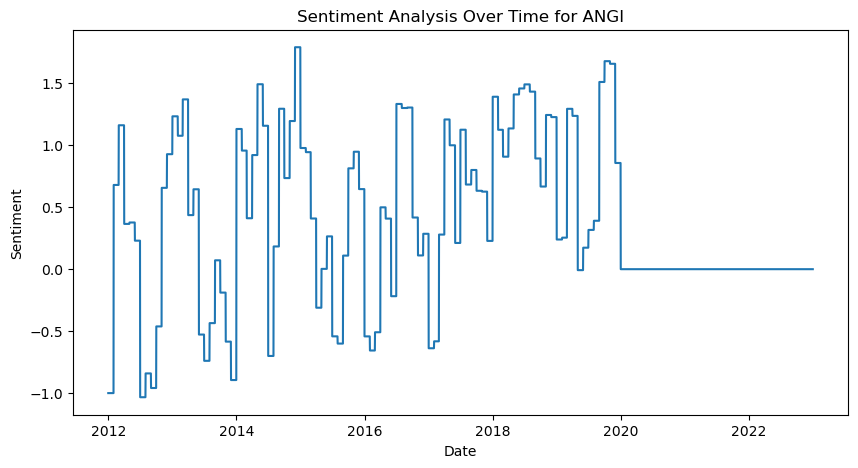

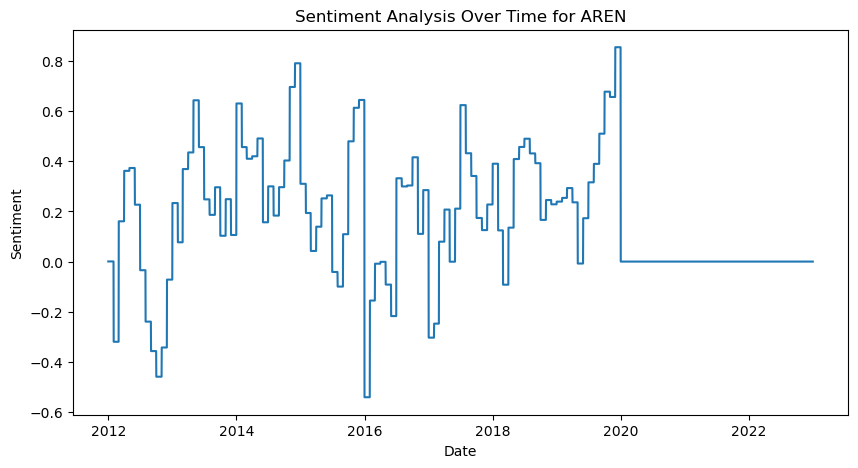

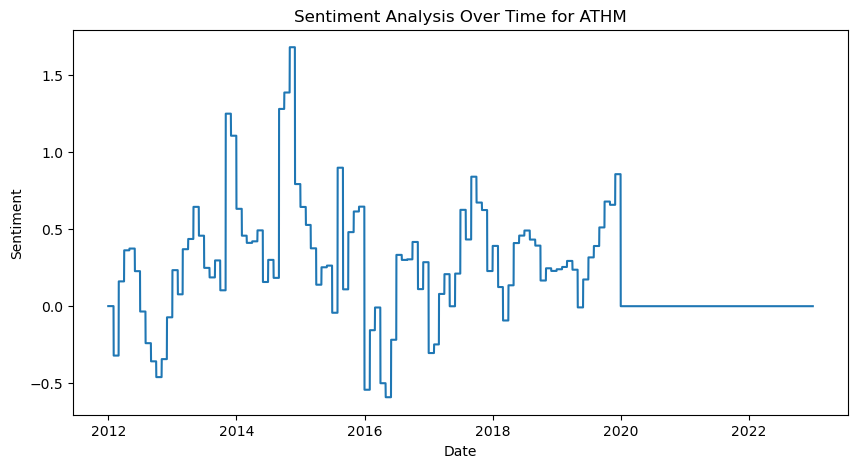

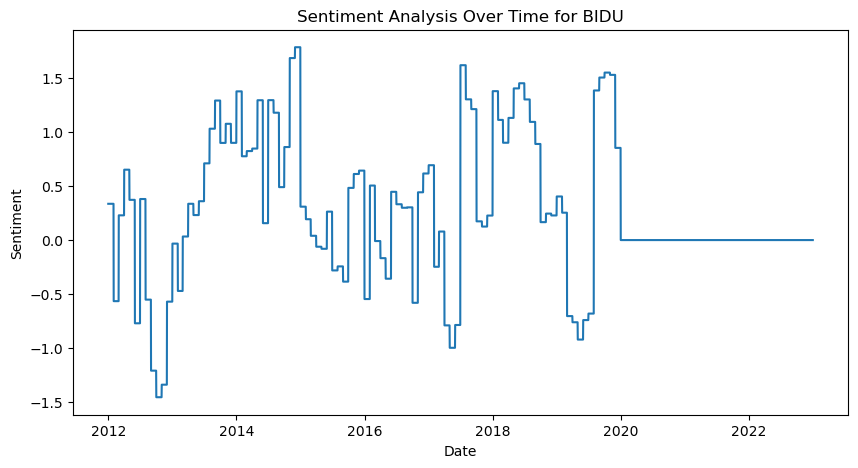

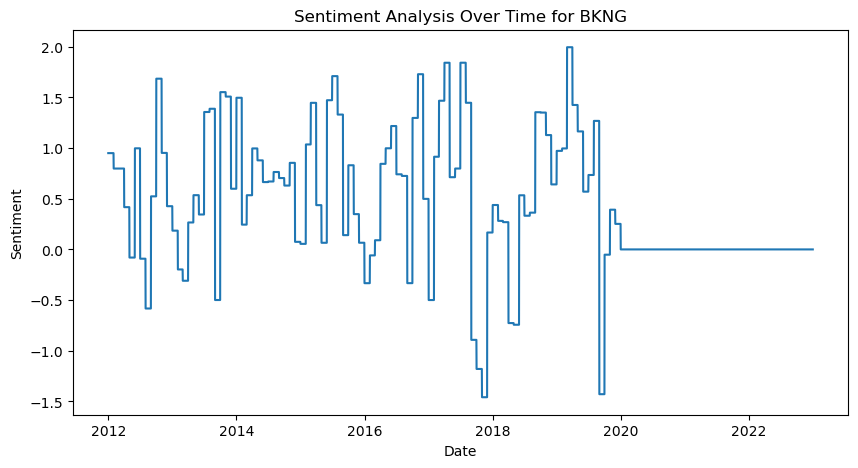

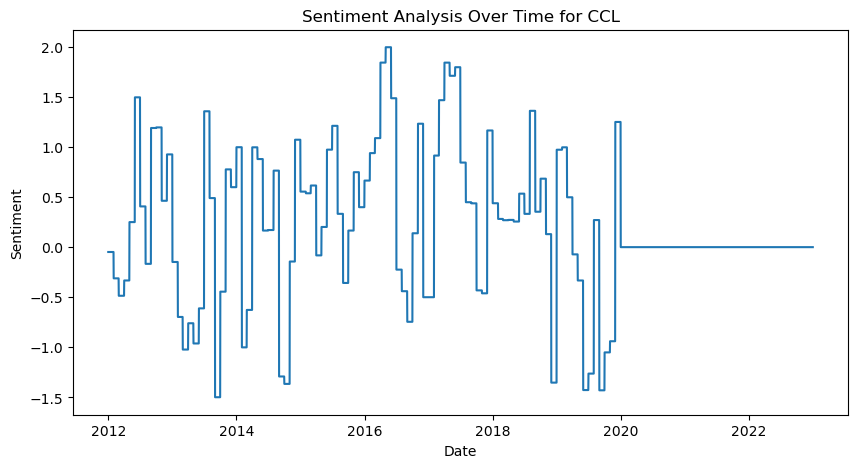

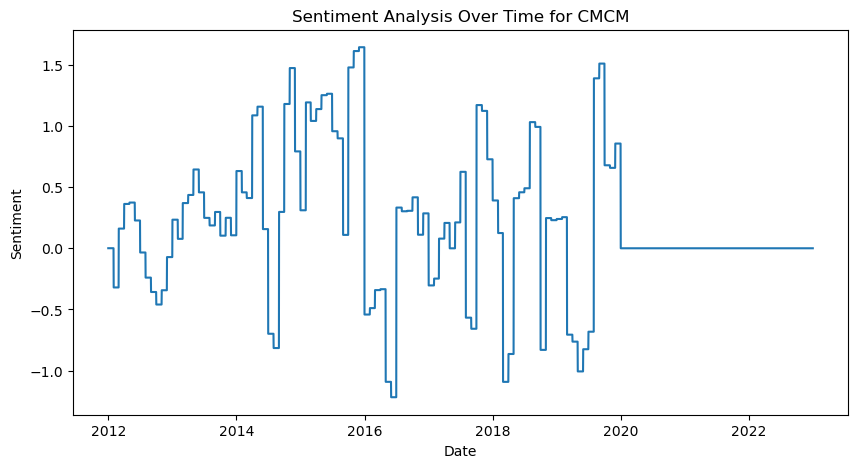

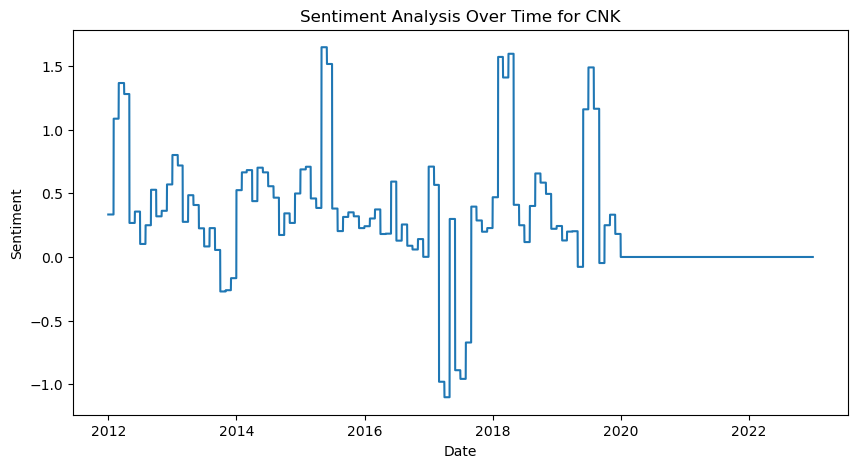

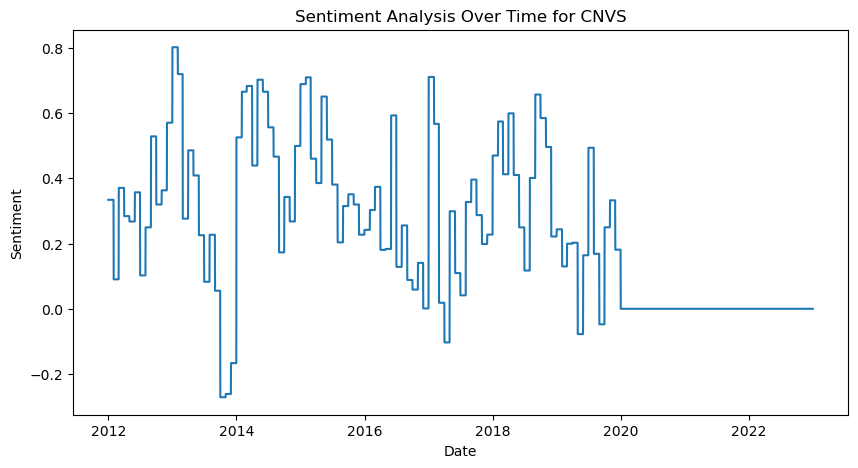

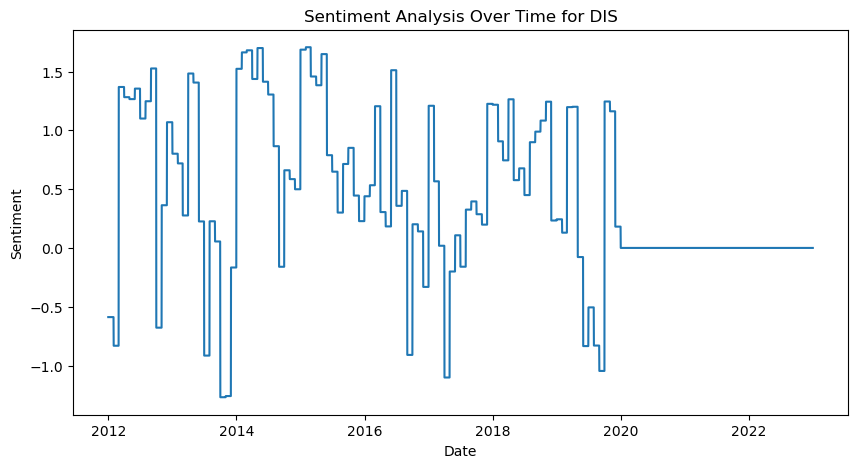

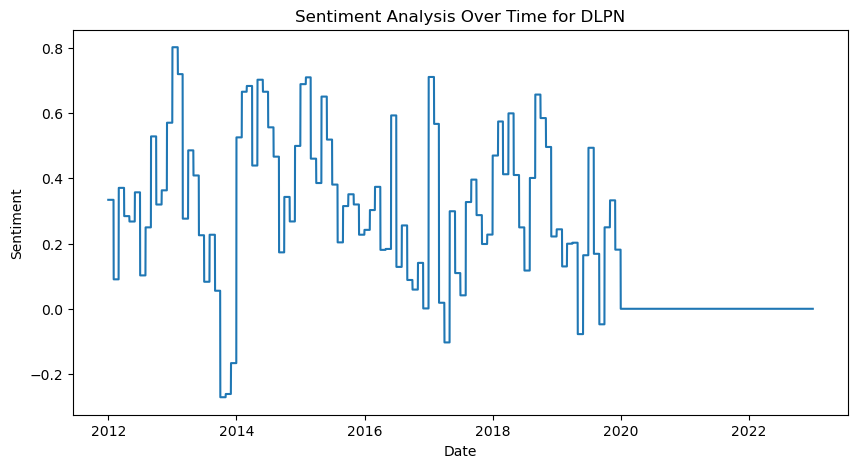

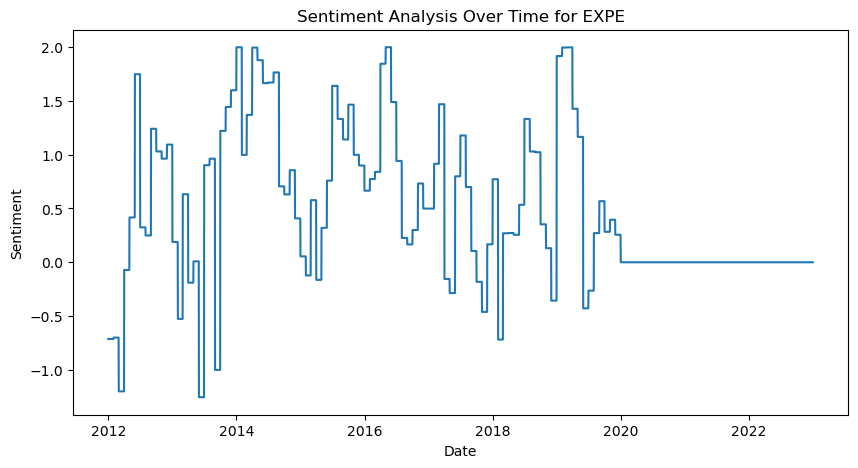

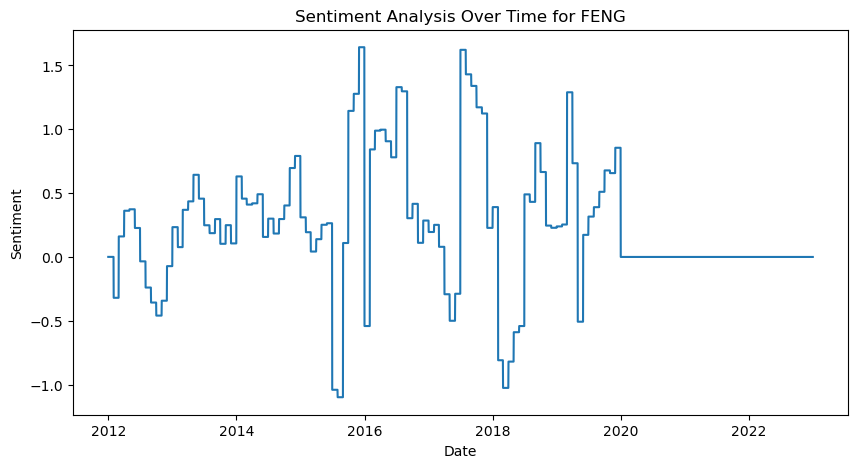

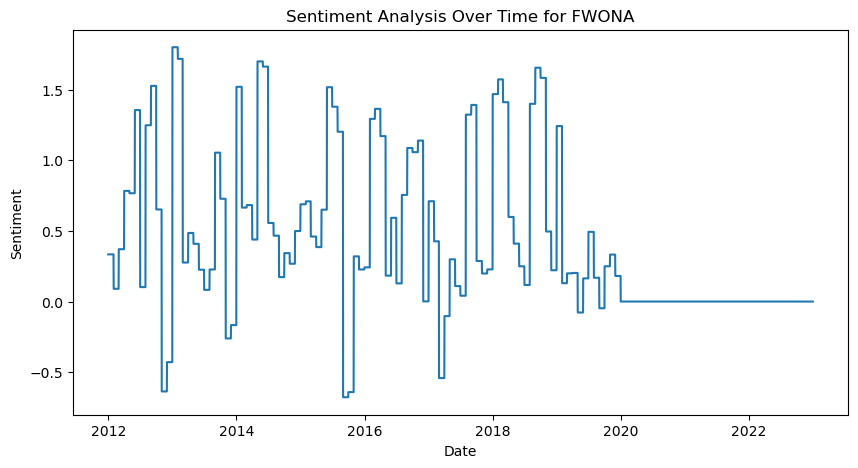

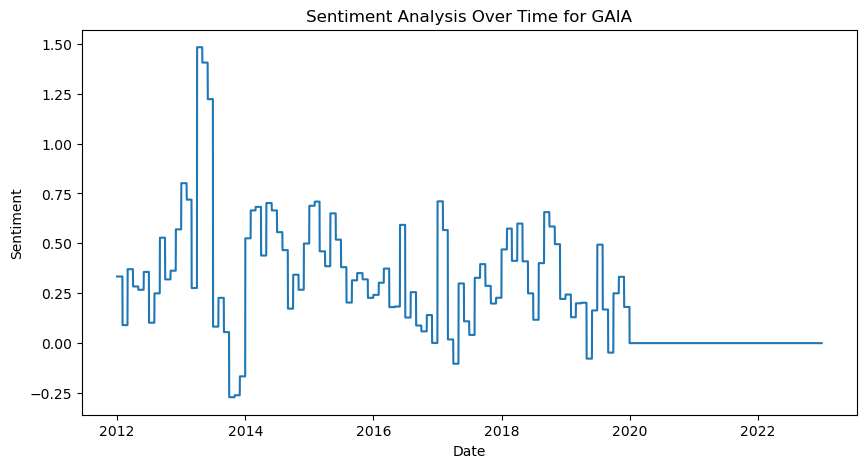

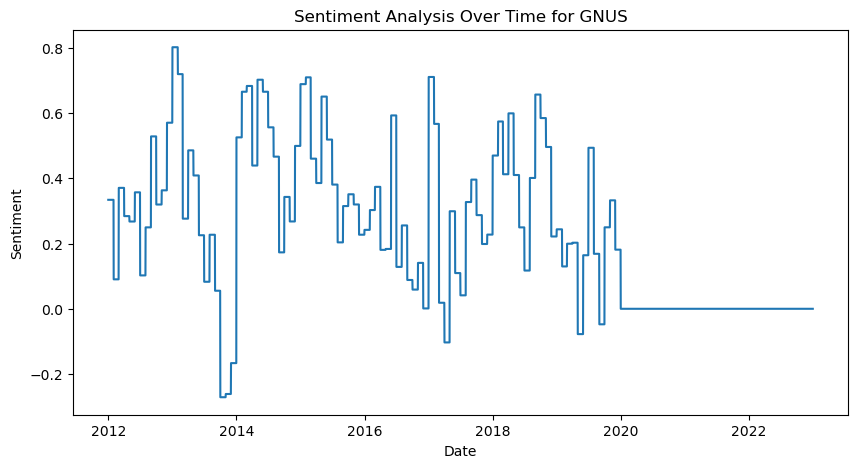

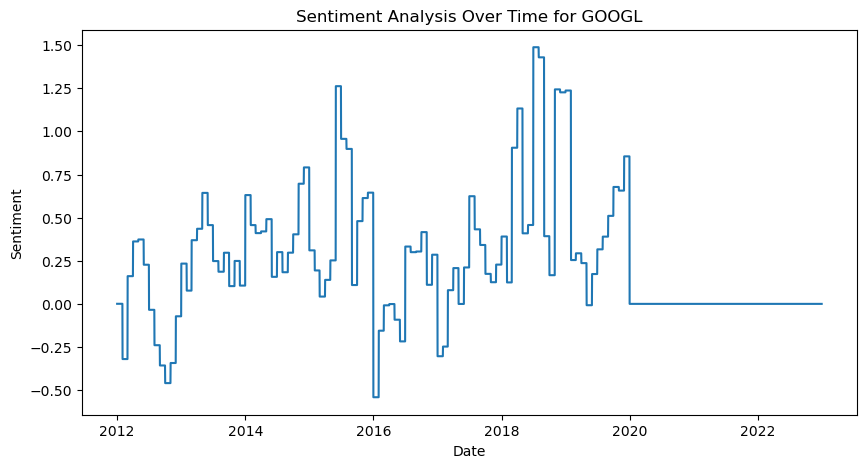

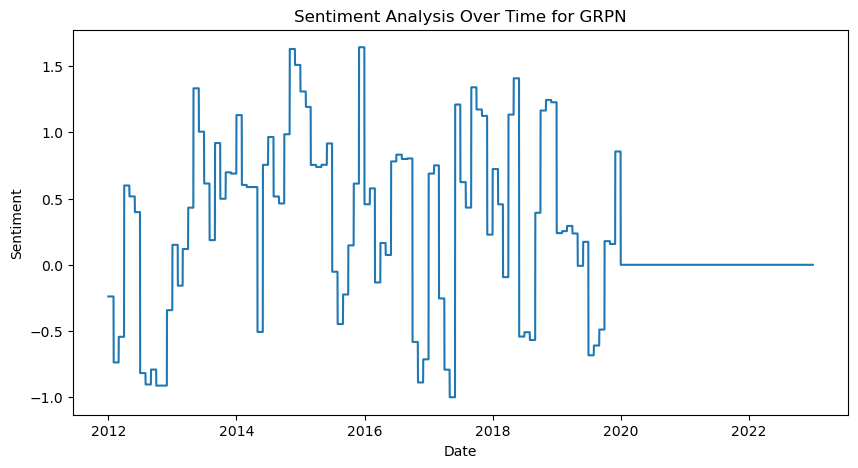

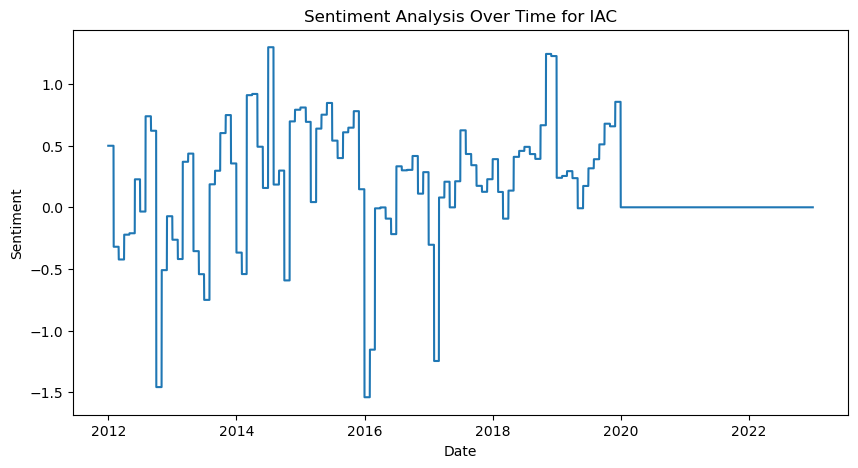

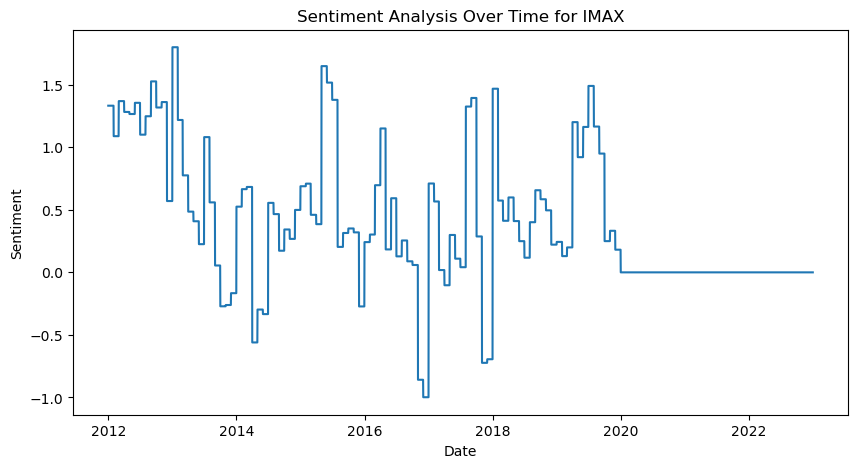

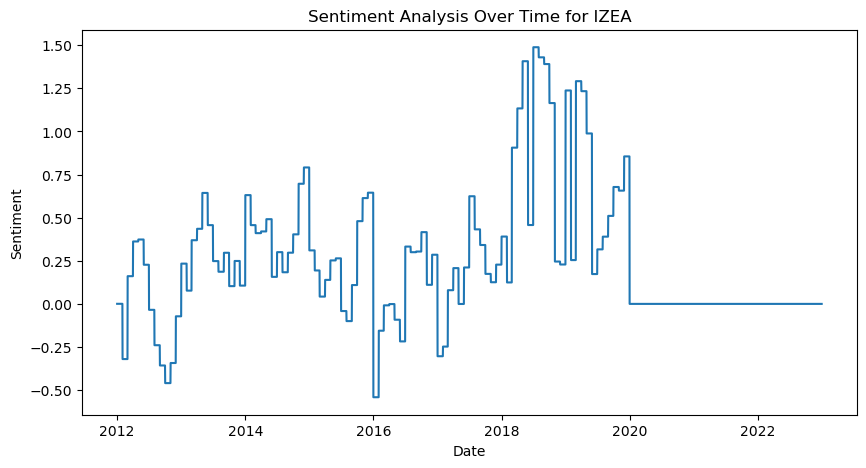

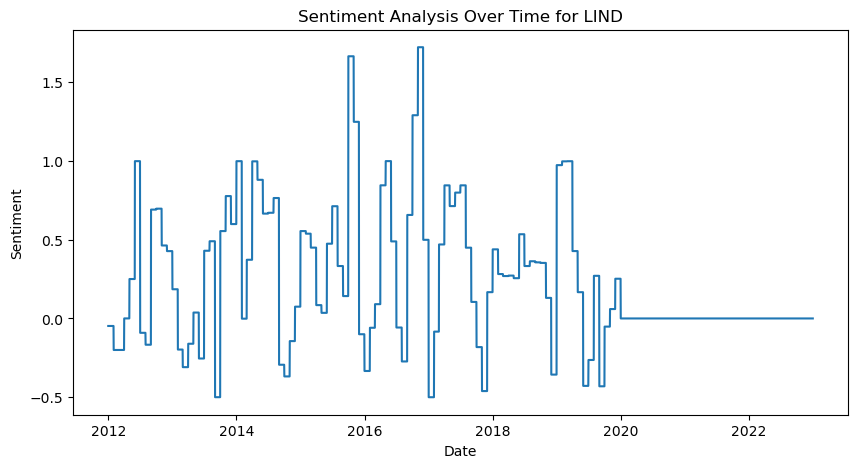

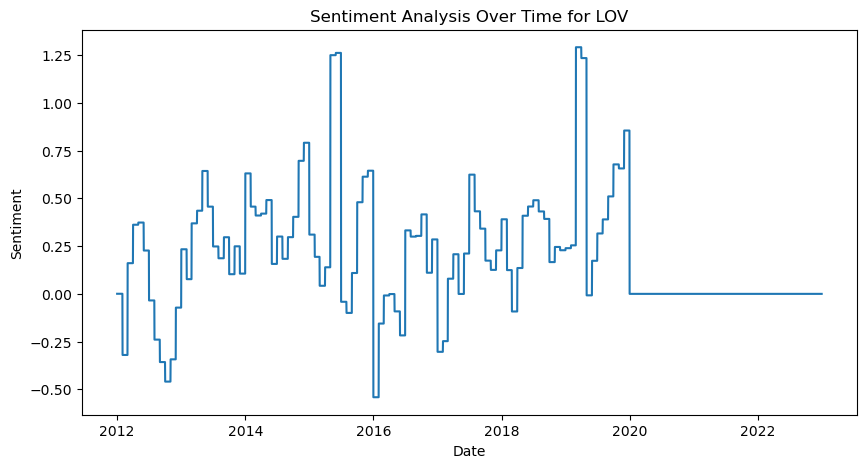

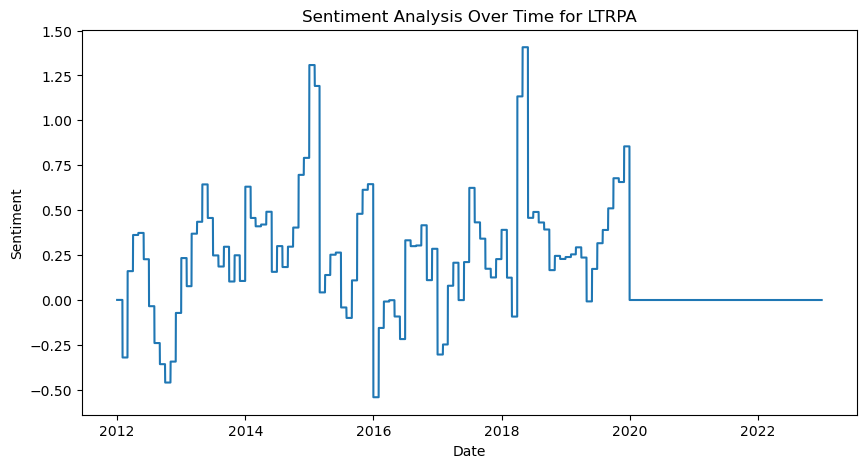

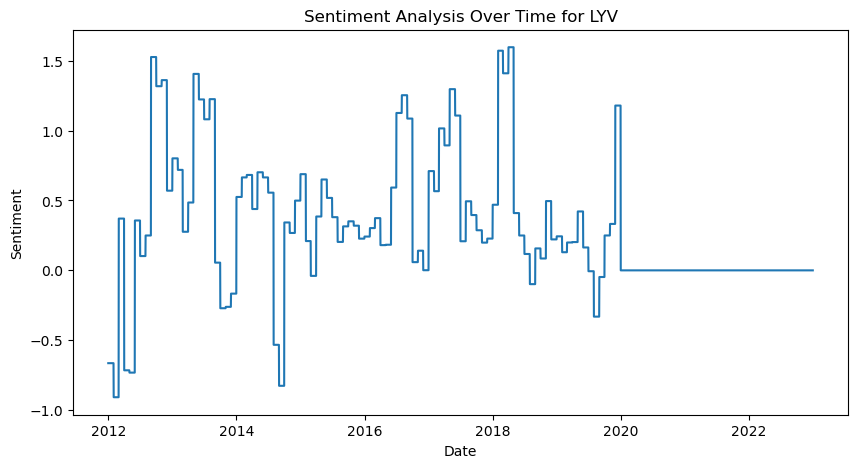

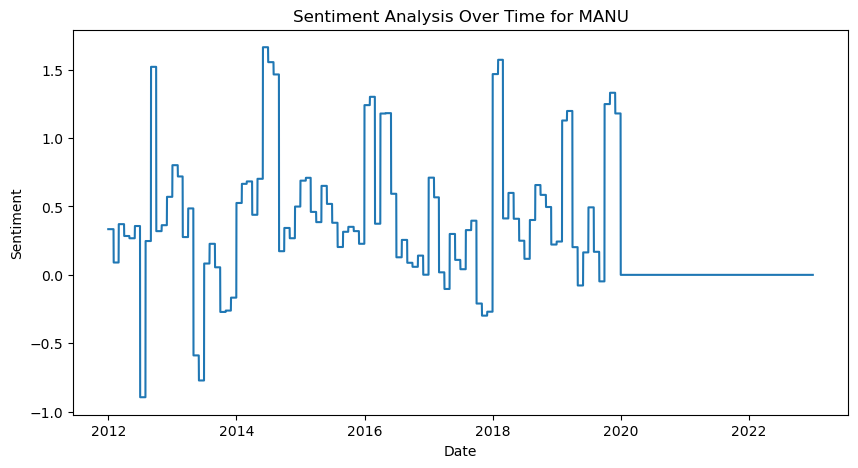

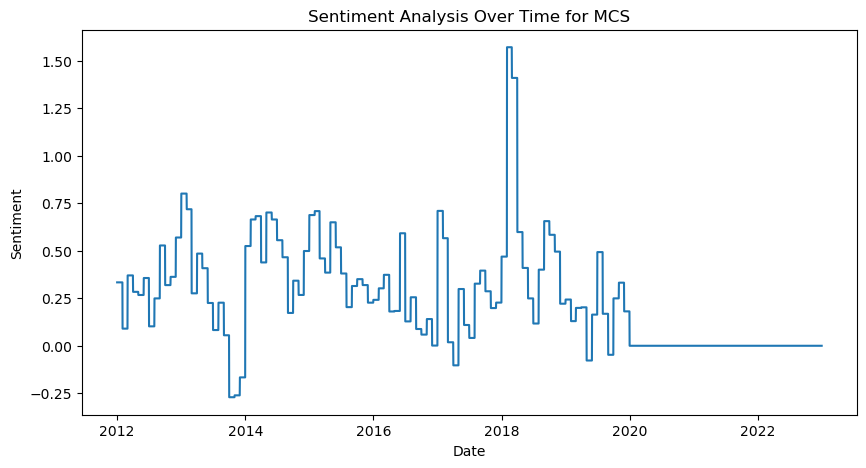

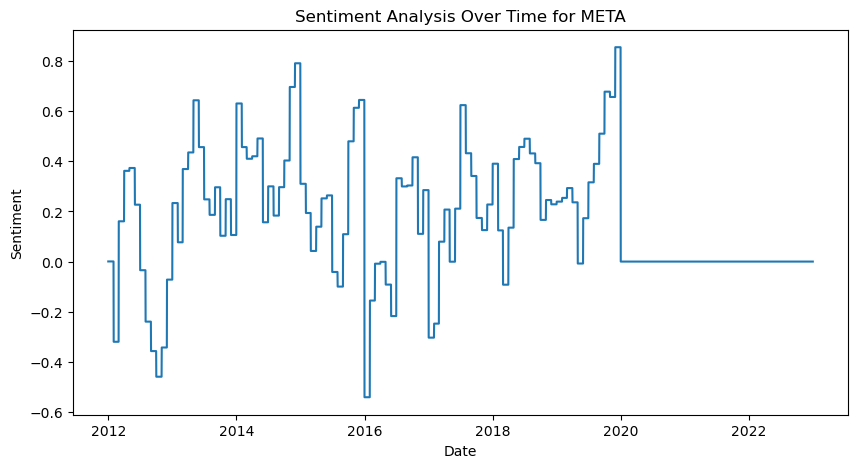

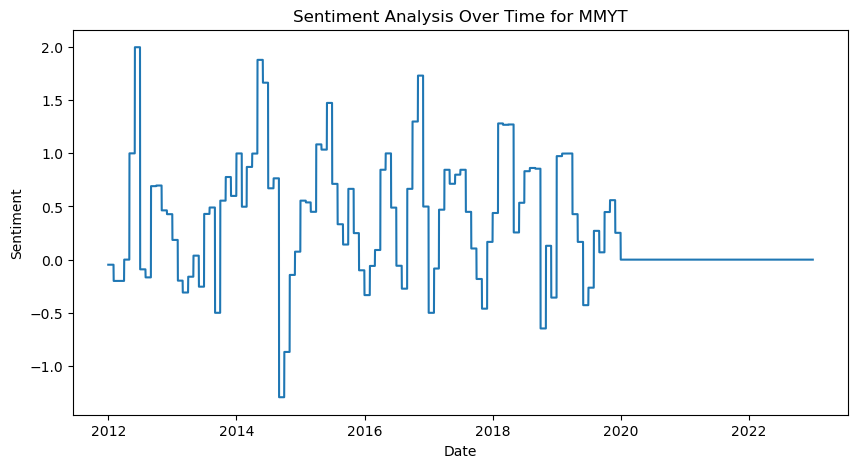

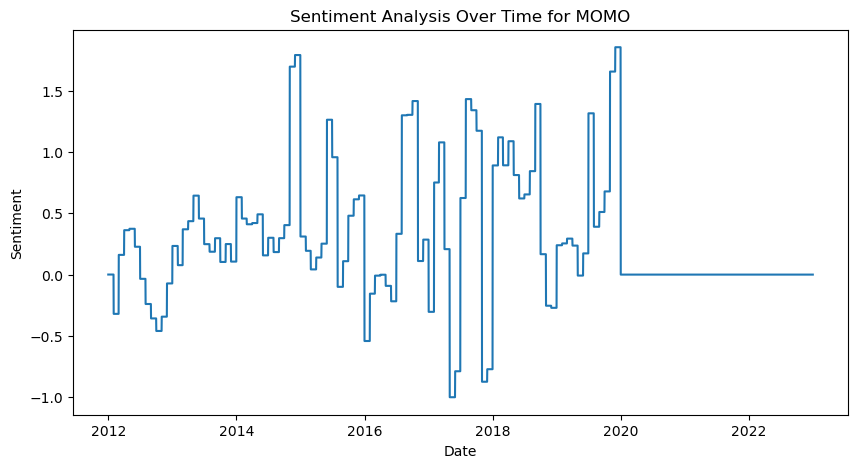

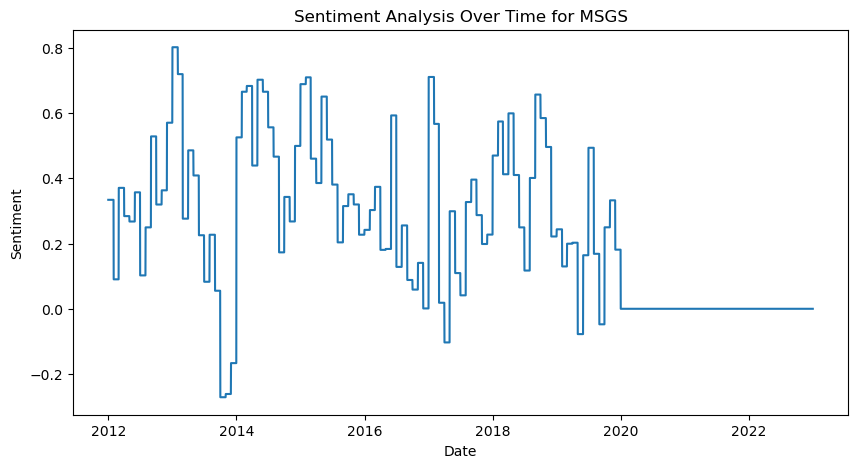

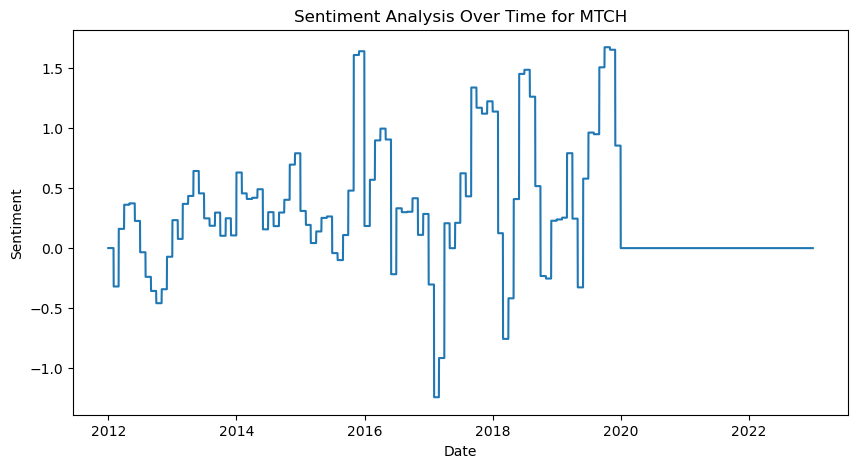

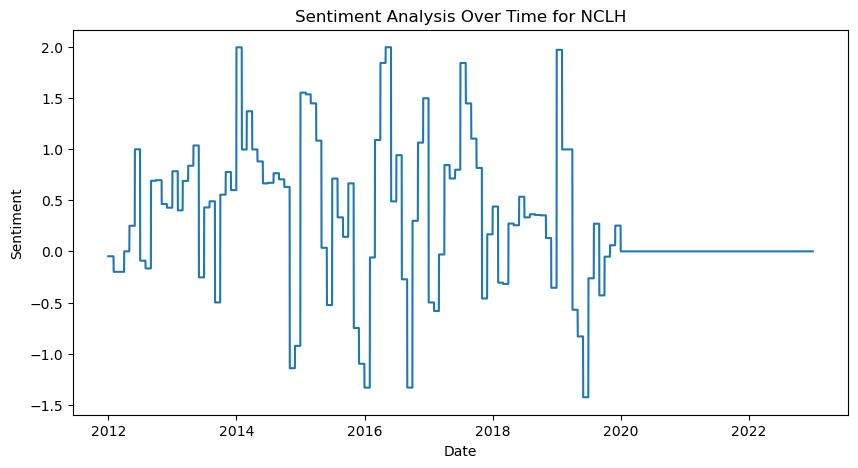

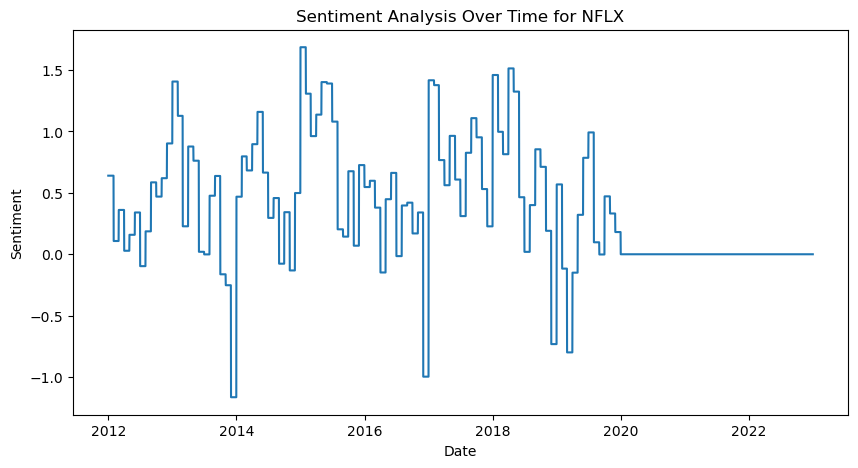

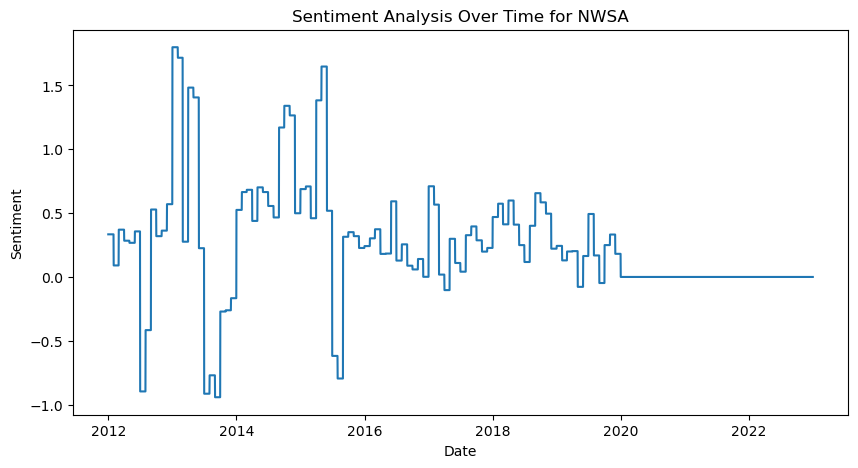

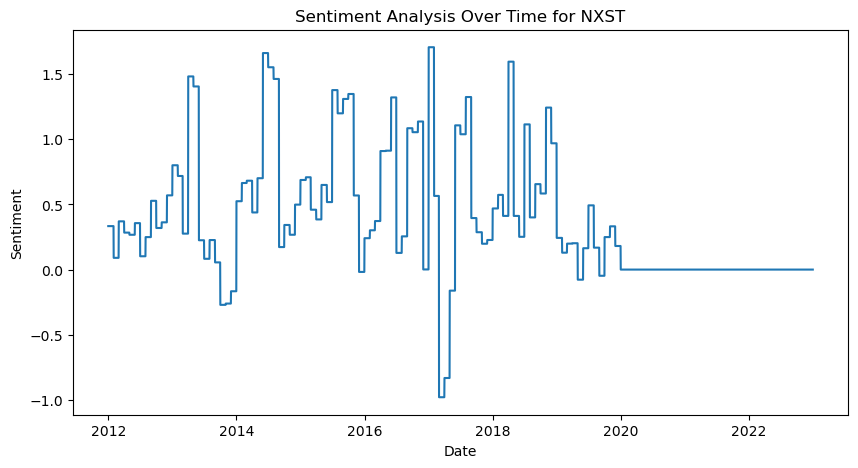

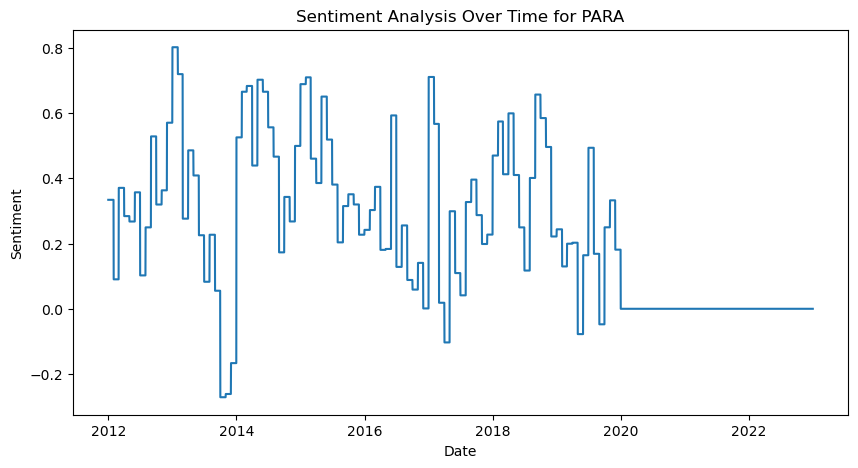

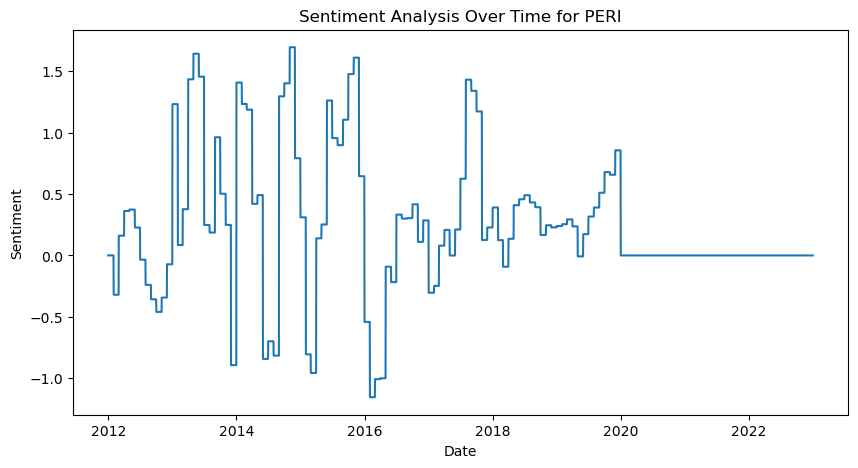

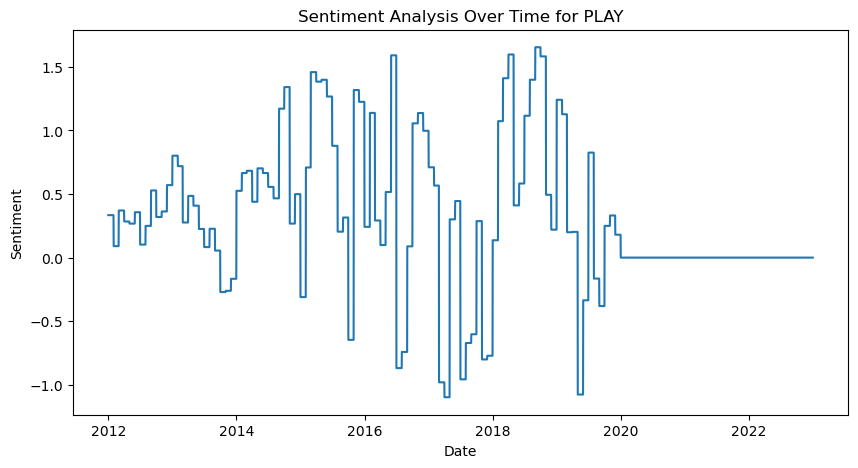

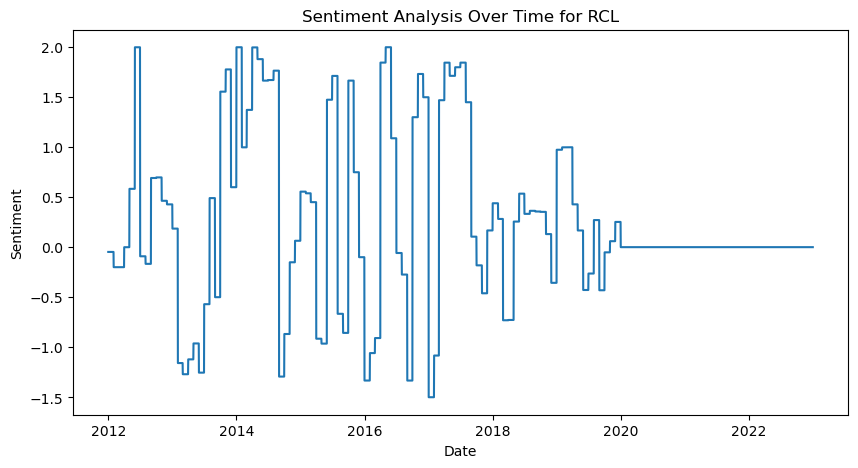

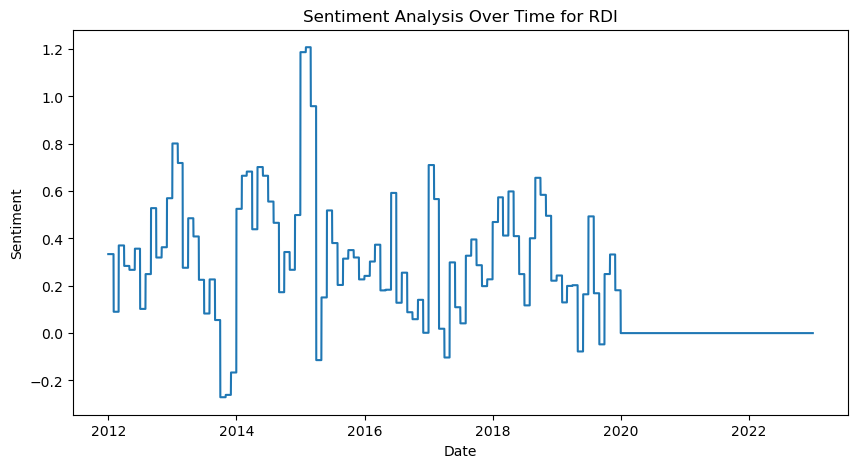

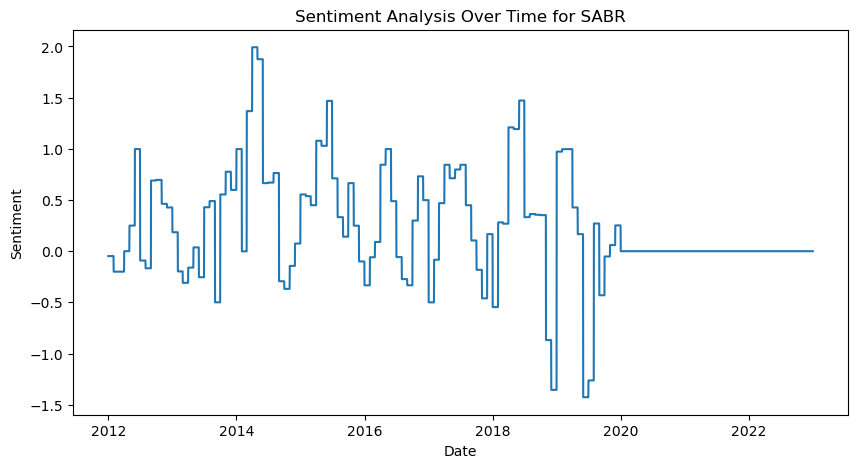

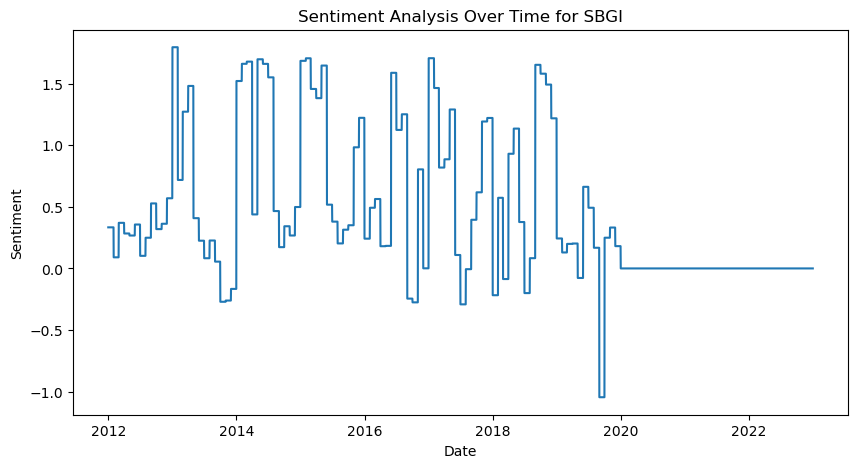

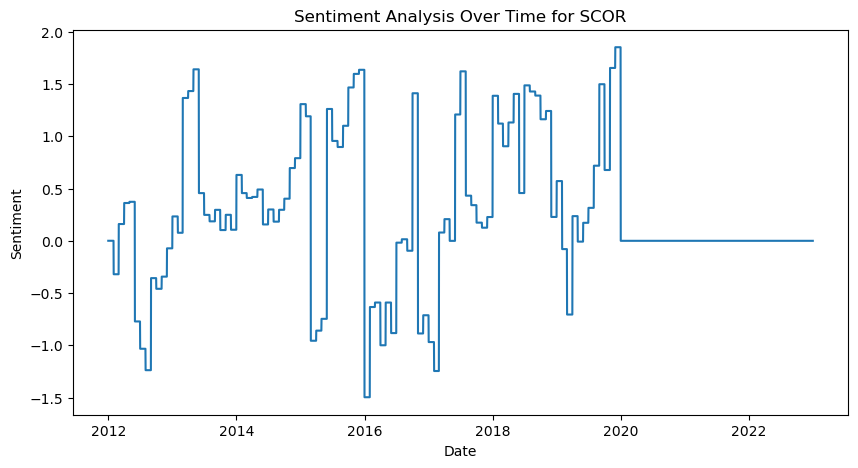

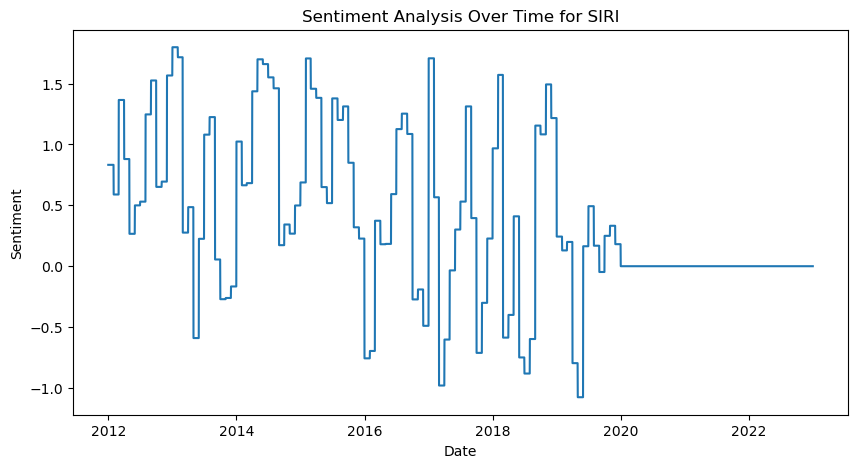

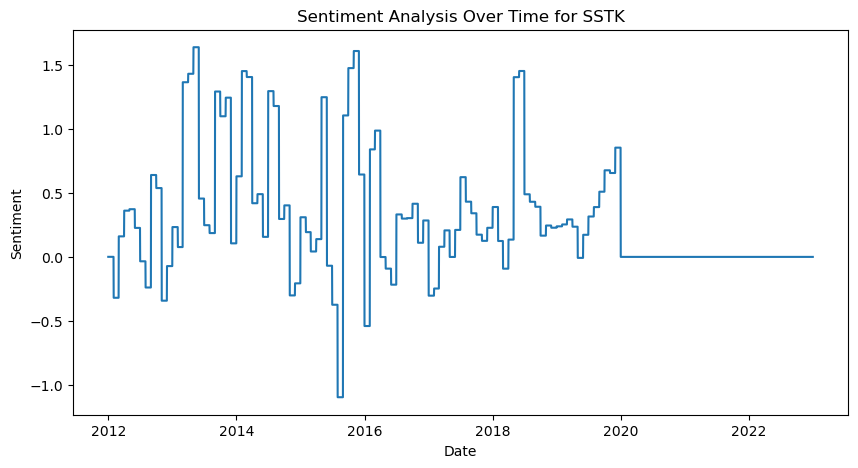

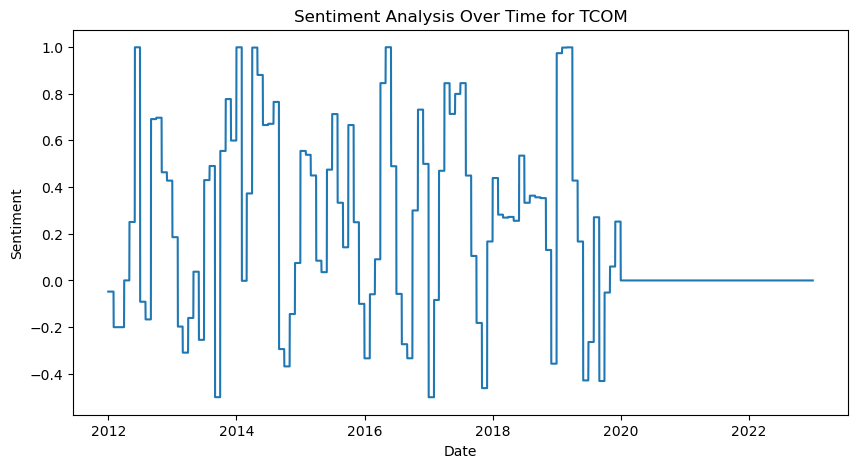

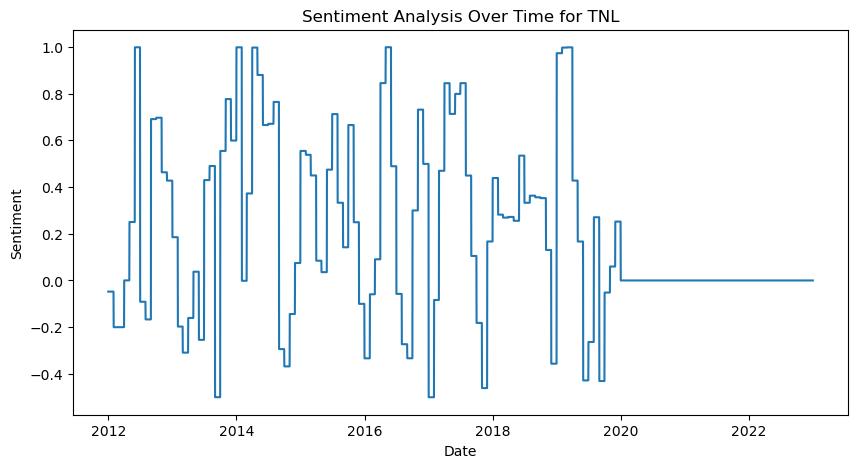

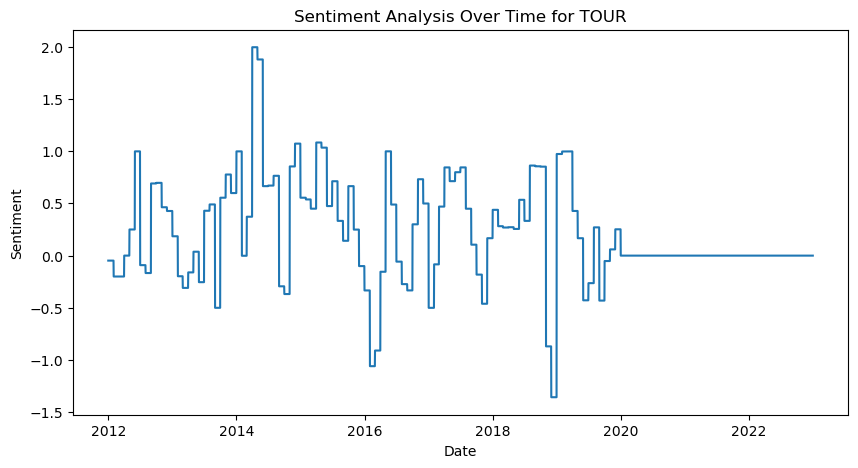

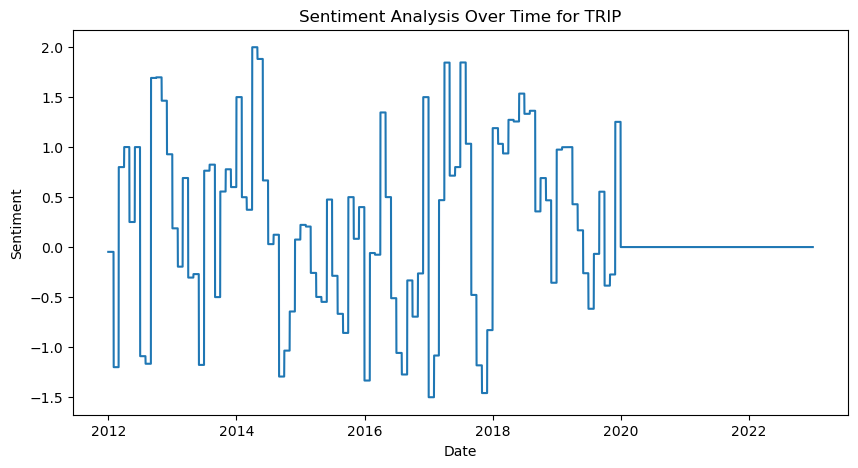

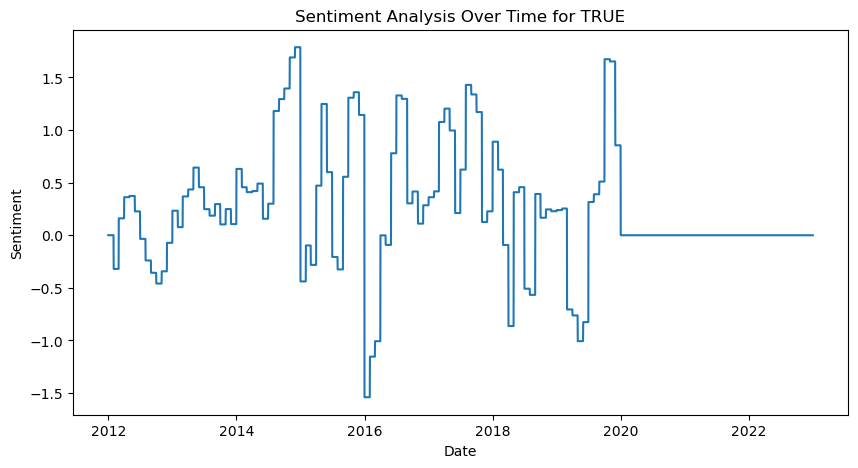

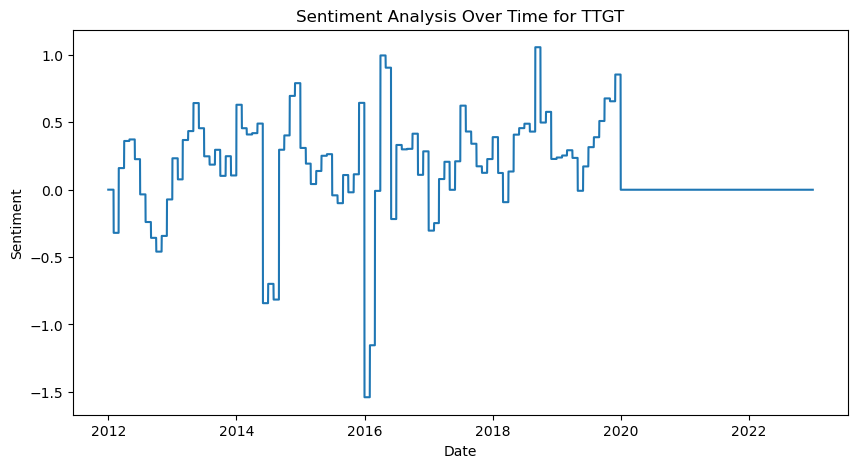

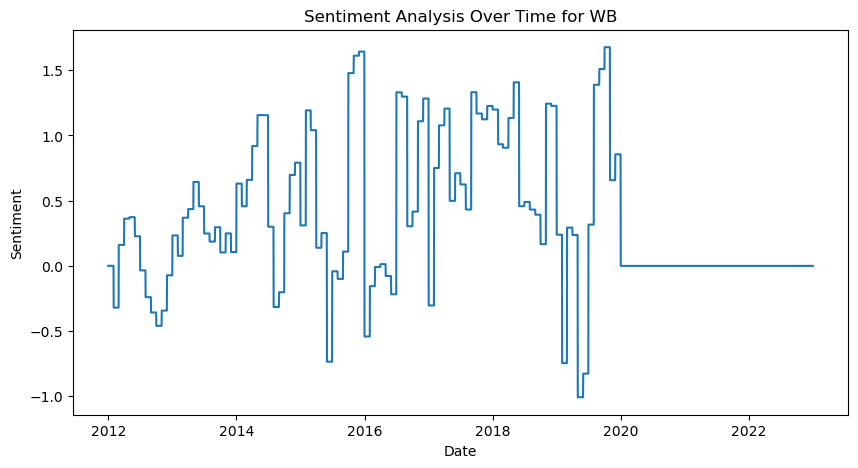

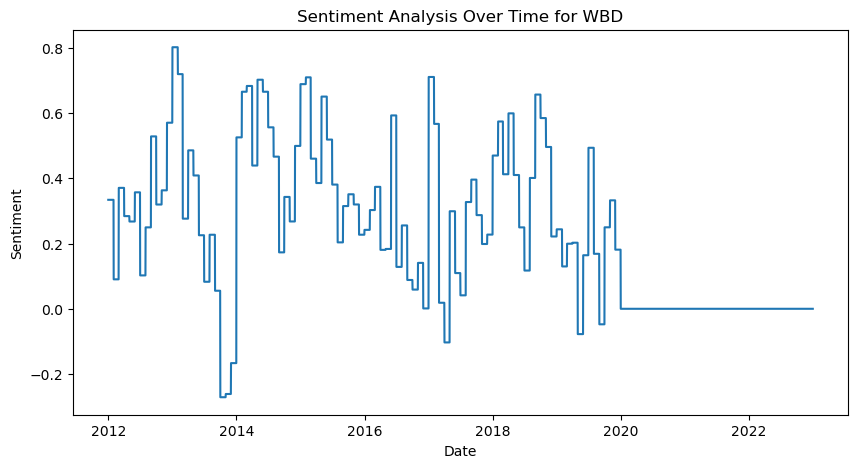

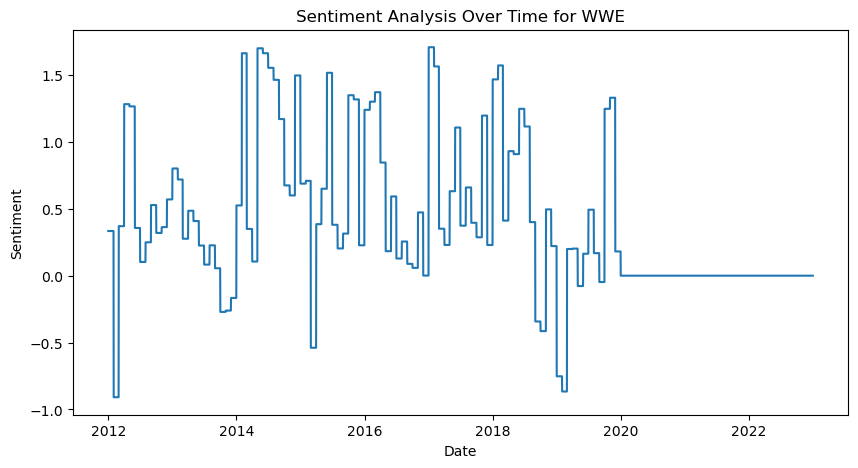

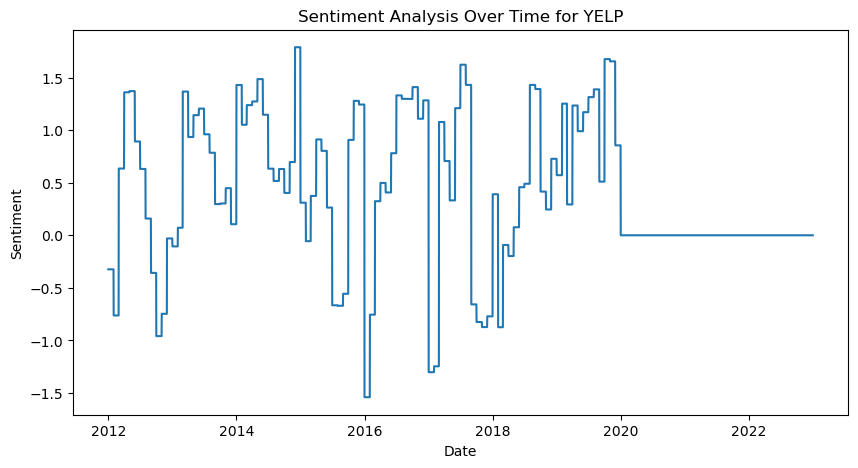

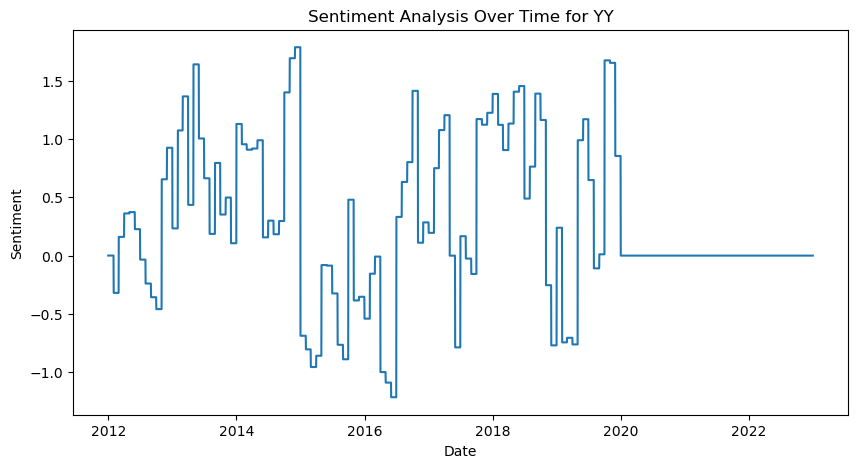

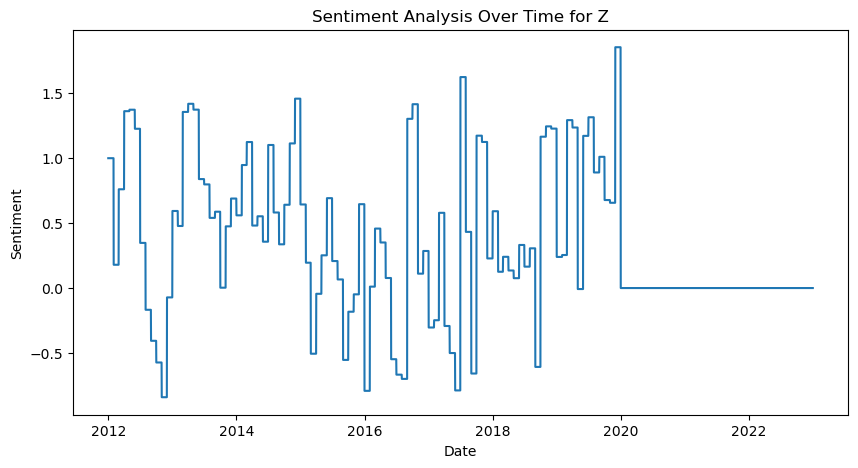

In [31]:
# plot sentiment distribution for each company
for company in selected_companies:
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df_sentiment[df_sentiment['Company'] == company], x='Date', y='sentiment')
    plt.title(f'Sentiment Analysis Over Time for {company}')
    plt.xlabel('Date')
    plt.ylabel('Sentiment')
    plt.show()

Merge Stock Data and News Headlines

In [32]:
# merge stock data and sentiment analysis
df_merged = pd.merge(df_stock, df_sentiment, left_on=['Company', 'Date'], right_on=['Company', 'Date'], how='inner')
df_merged = df_merged.drop(columns=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'start'])
df_merged = df_merged.set_index('Date') # set date as index
# fill missing values with 0
df_merged['daily_return'] = df_merged['daily_return'].fillna(0.0)
# move daily_return to the end
temp = df_merged.pop('daily_return')
df_merged['daily_return'] = temp

display(df_merged.head(5))
print(df_merged.shape)

Company  sentiment_company         industry  sentiment_industry  \
Date                                                                         
2020-12-10    ABNB                0.0  travel-services                 0.0   
2020-12-11    ABNB                0.0  travel-services                 0.0   
2020-12-14    ABNB                0.0  travel-services                 0.0   
2020-12-15    ABNB                0.0  travel-services                 0.0   
2020-12-16    ABNB                0.0  travel-services                 0.0   

            sentiment  company_name  daily_return  
Date                                               
2020-12-10        0.0  Airbnb, Inc.      0.000000  
2020-12-11        0.0  Airbnb, Inc.     -0.037731  
2020-12-14        0.0  Airbnb, Inc.     -0.066427  
2020-12-15        0.0  Airbnb, Inc.     -0.040000  
2020-12-16        0.0  Airbnb, Inc.      0.105689

(210896, 7)


In [33]:
# create separate dataframes for each company
df_merged_list = []

# create separate dataframes for selected companies
for company in selected_companies:
    df_merged_company = df_merged[df_merged["Company"] == company]
    df_merged_company = df_merged_company.sort_index() # sort by date
    df_merged_company = df_merged_company.dropna() # drop rows with NaN values
    df_merged_company = df_merged_company.drop(columns = ["Company", "industry", "company_name"]) # drop categorical features
    df_merged_list.append(df_merged_company)
print(len(df_merged_list))

# # create separate dataframes for all companies
# for company in companies:
#     df_merged_company = df_merged[df_merged["Company"] == company]
#     df_merged_company = df_merged_company.sort_index() # sort by date
#     df_merged_company = df_merged_company.dropna() # drop rows with NaN values
#     df_merged_company = df_merged_company.drop(columns = ["Company", "industry", "company_name"]) # drop categorical features
#     df_merged_list.append(df_merged_company)
# print(len(df_merged_list))

58


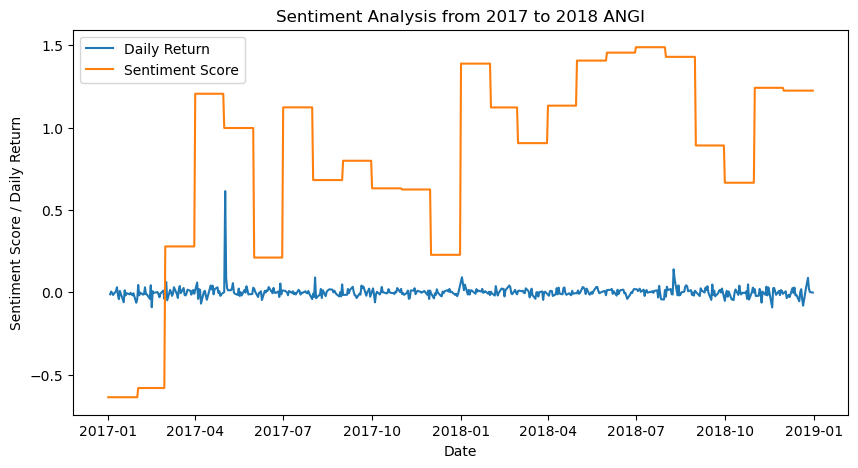

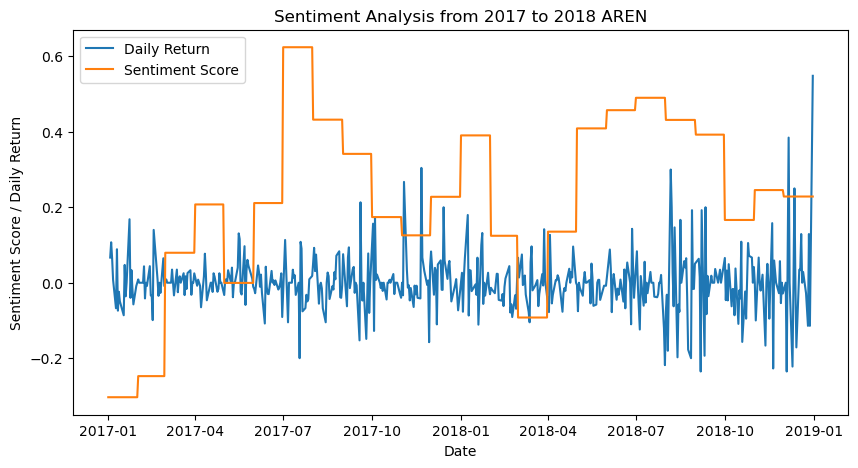

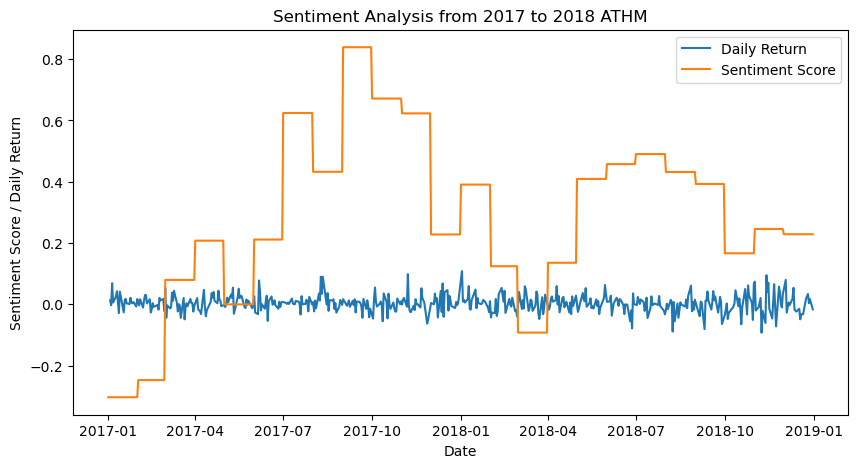

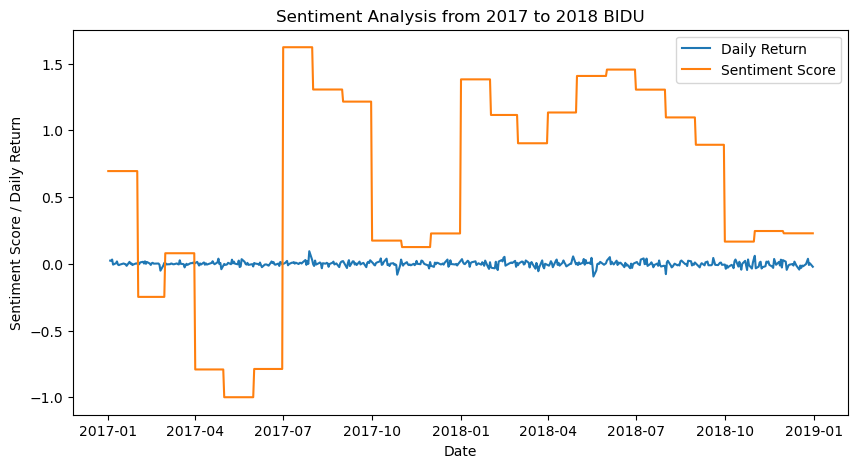

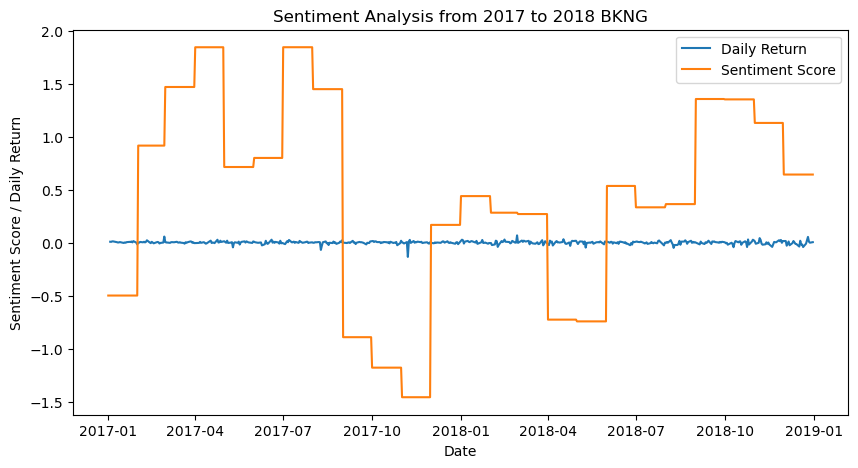

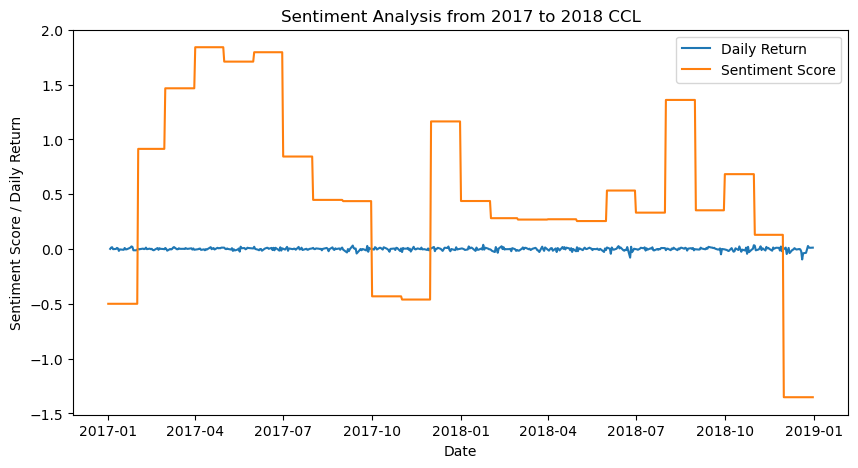

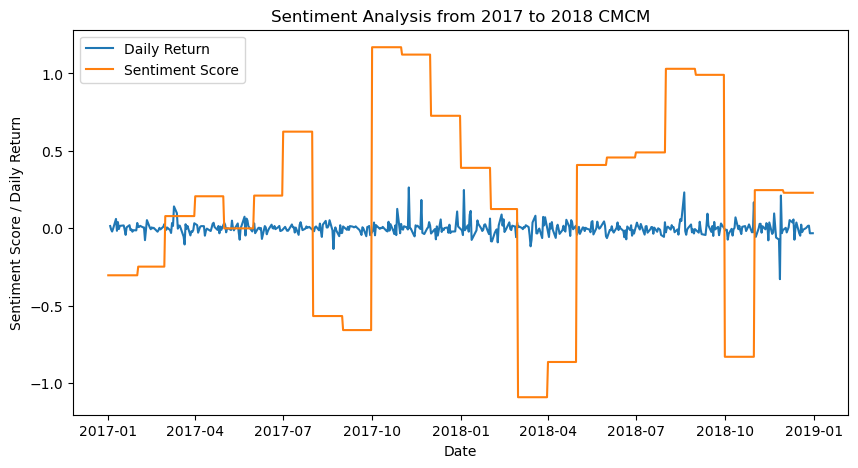

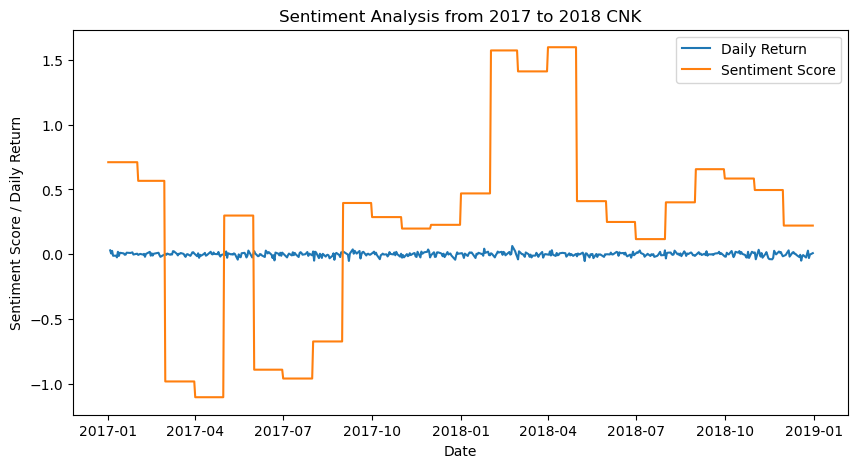

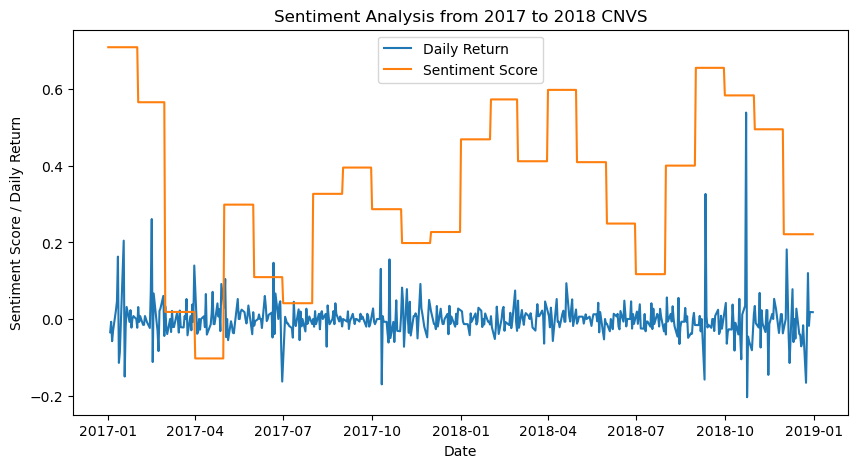

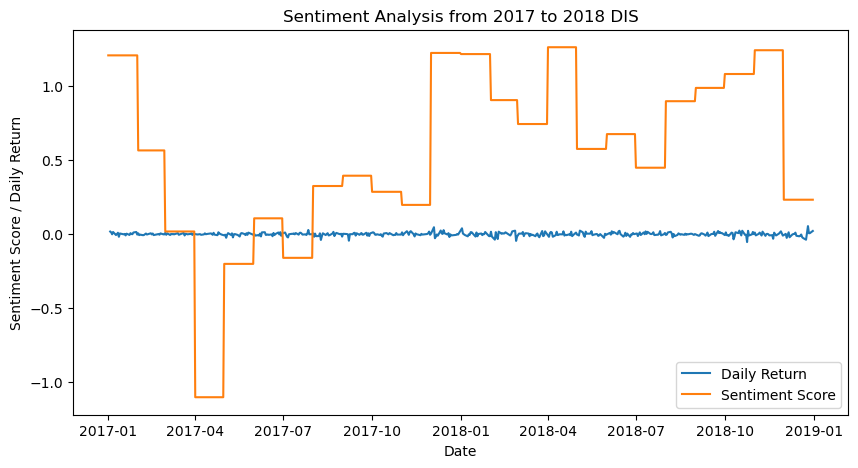

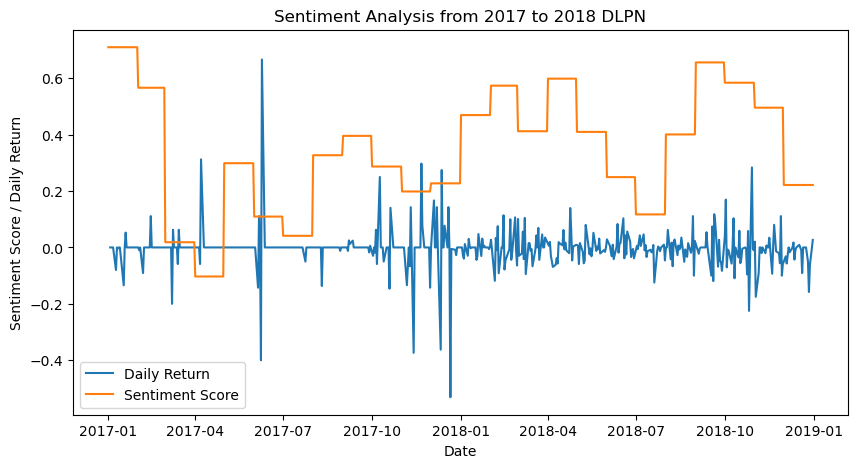

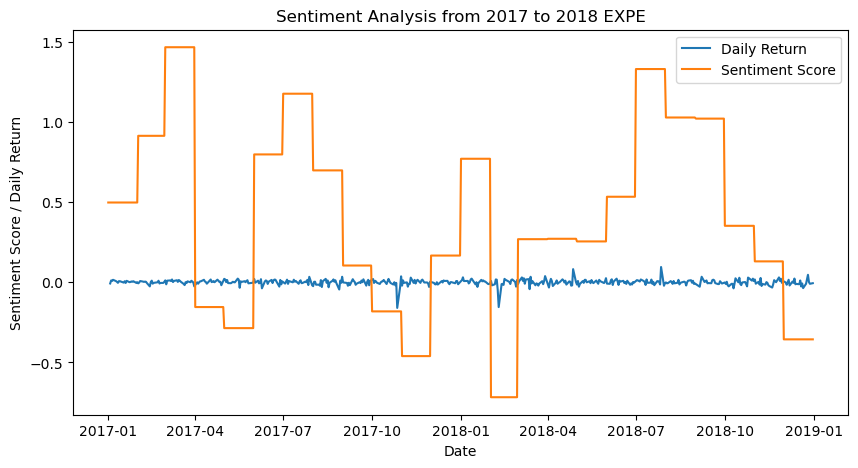

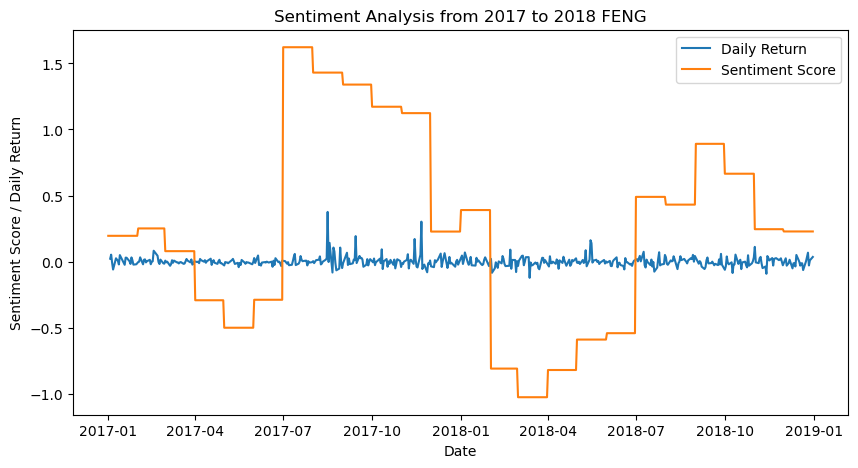

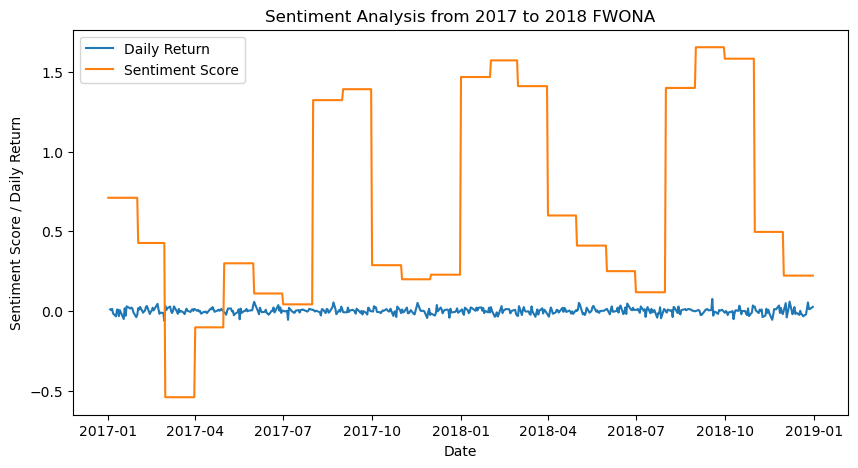

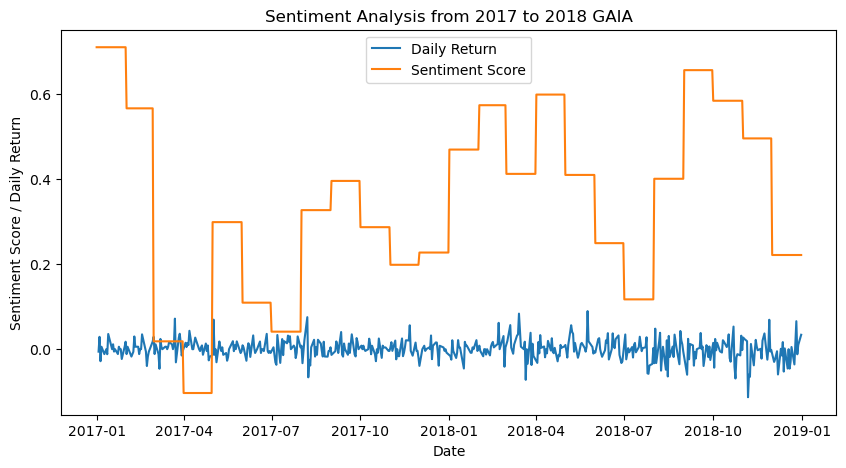

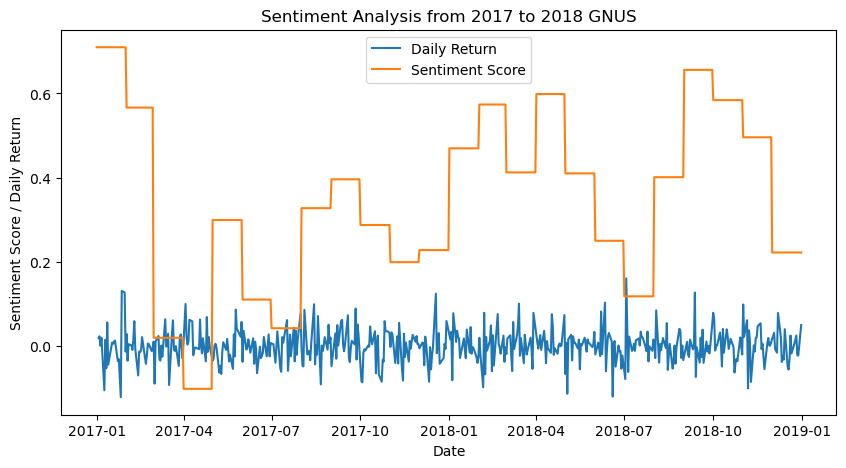

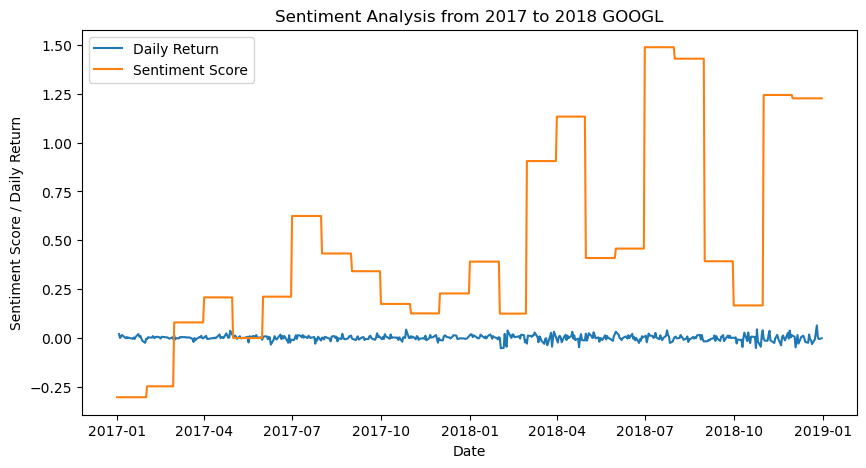

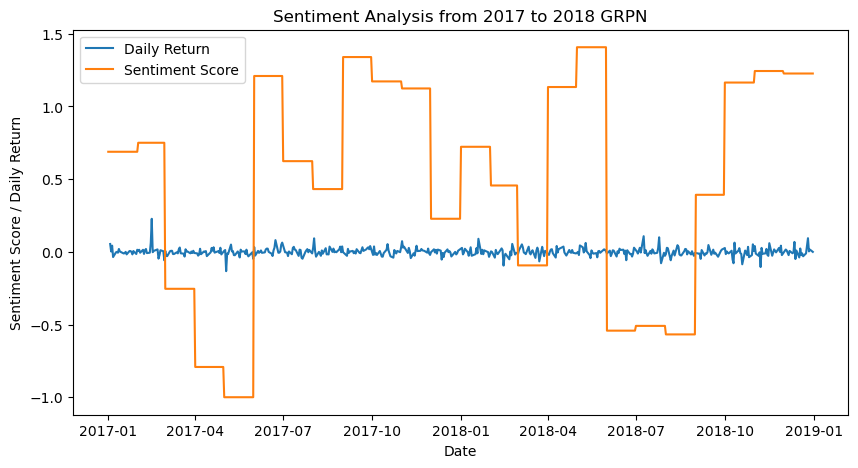

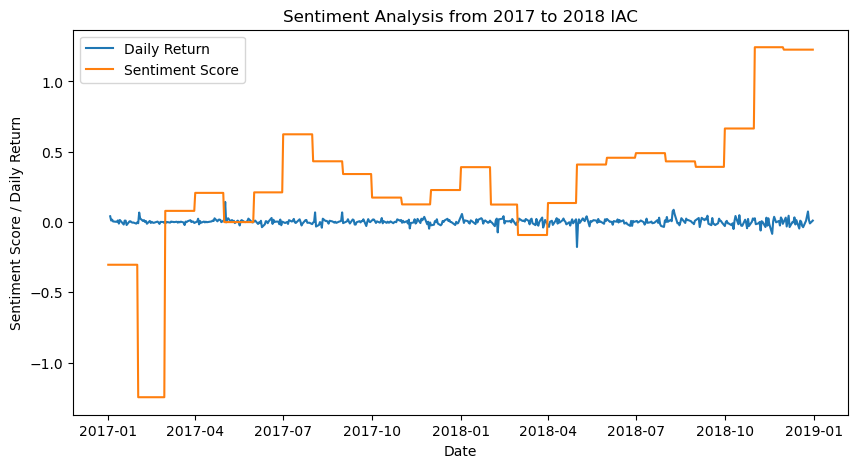

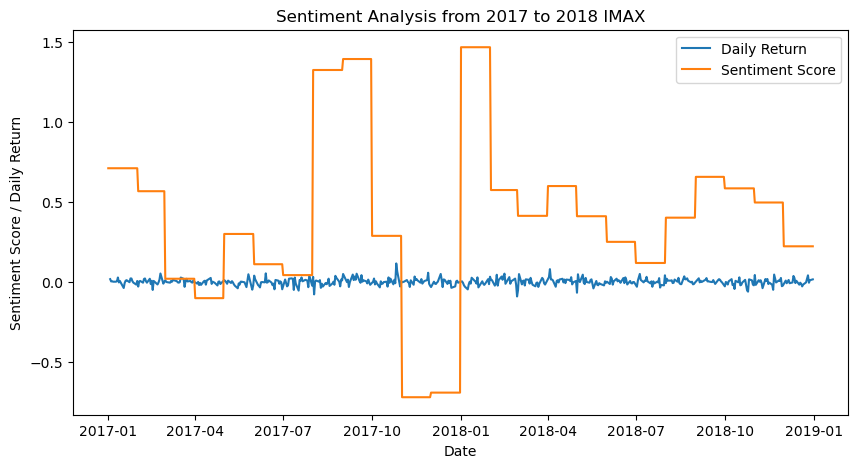

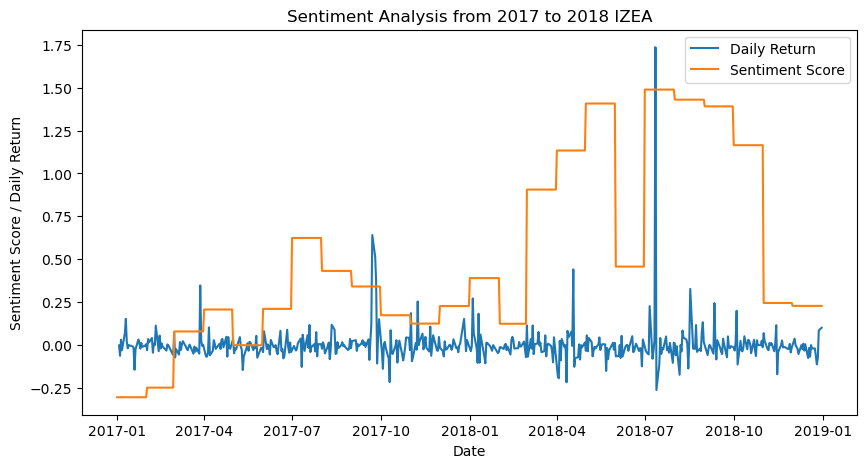

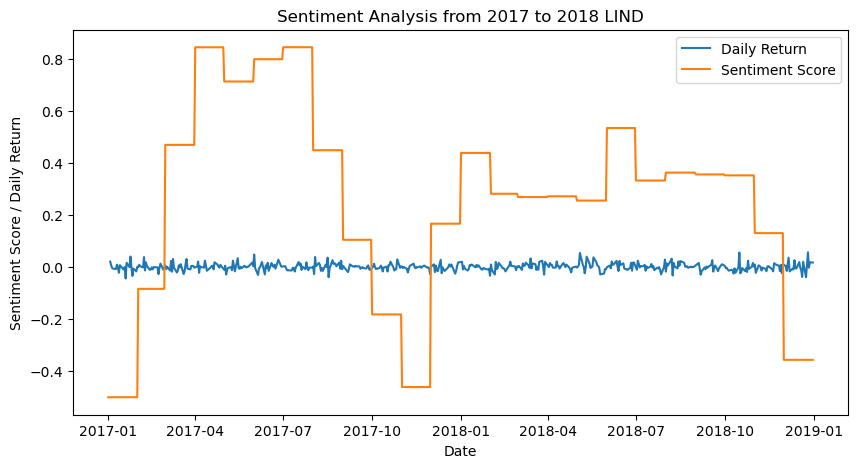

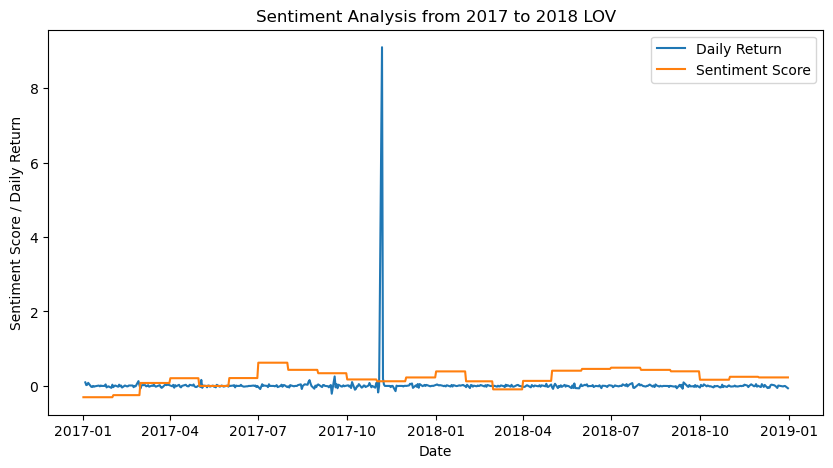

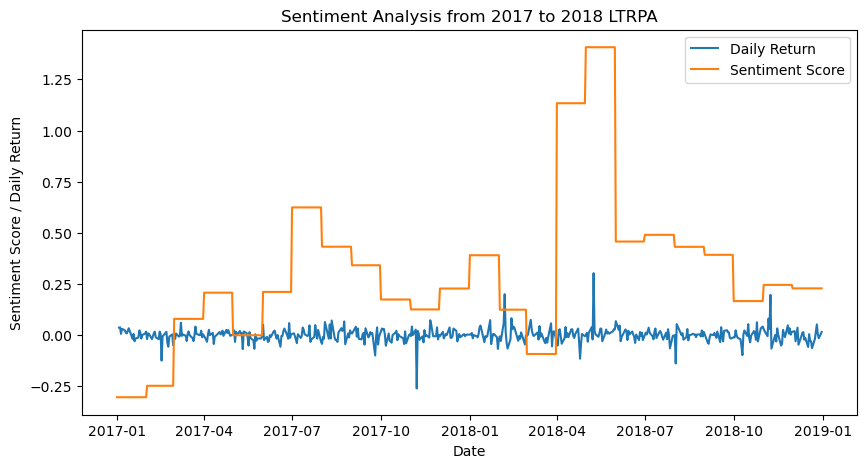

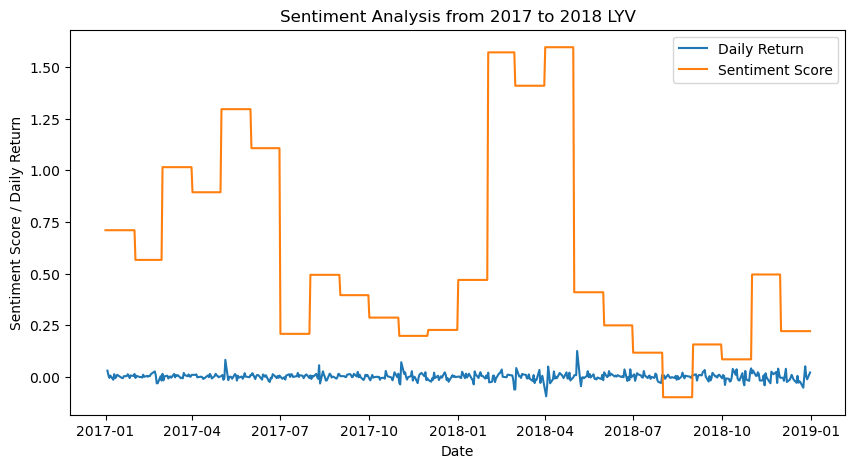

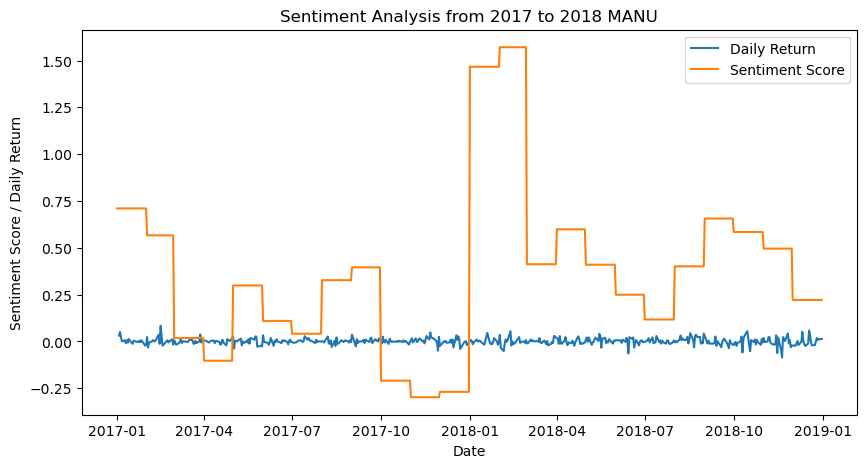

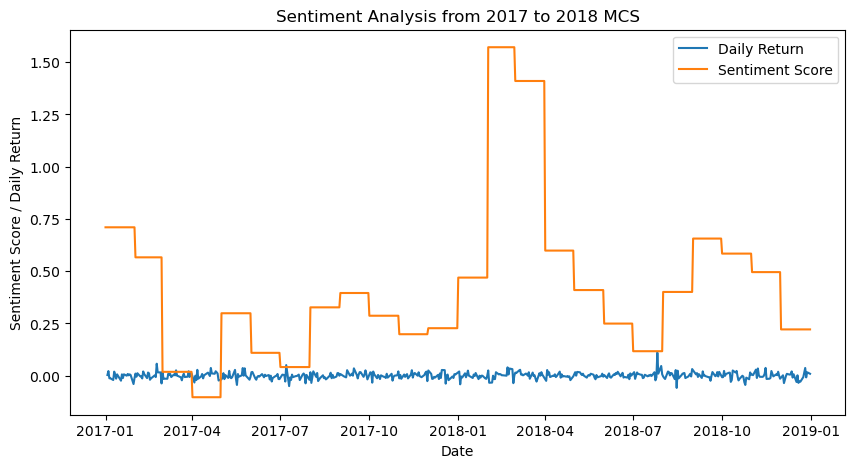

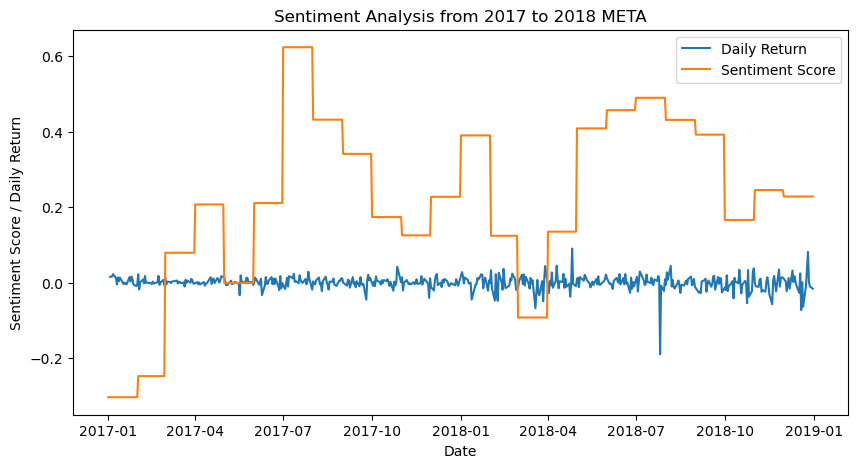

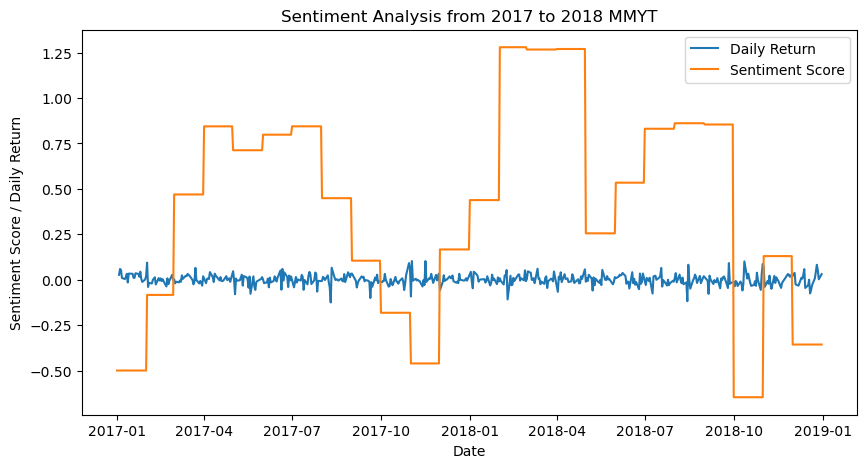

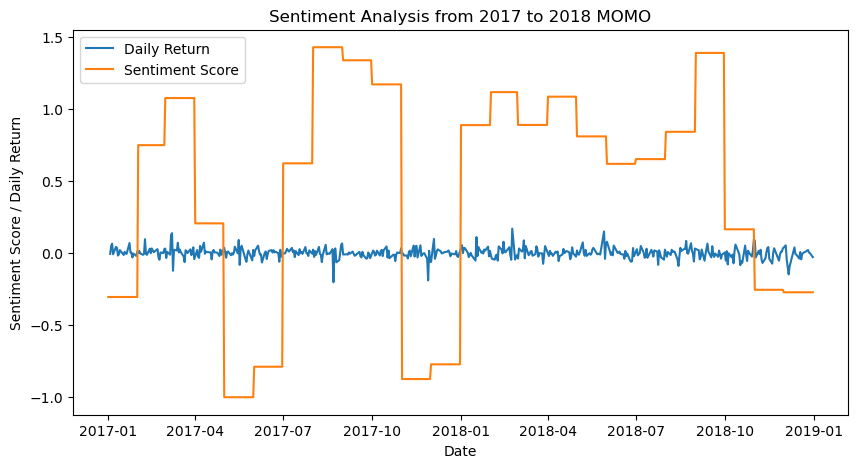

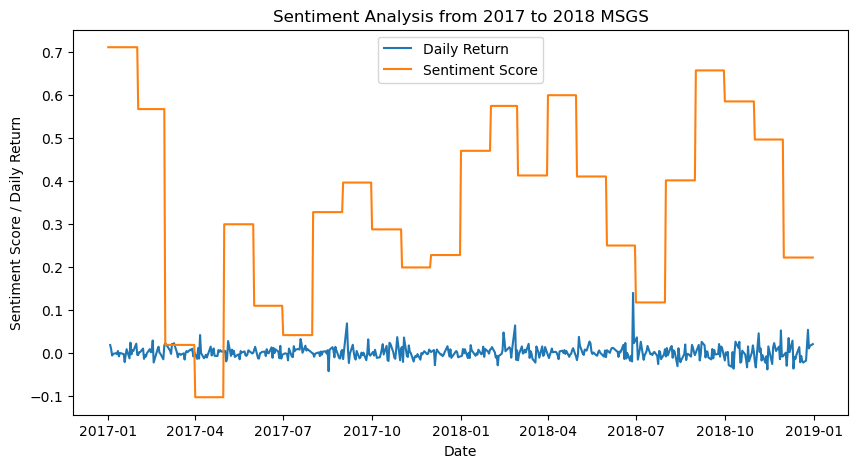

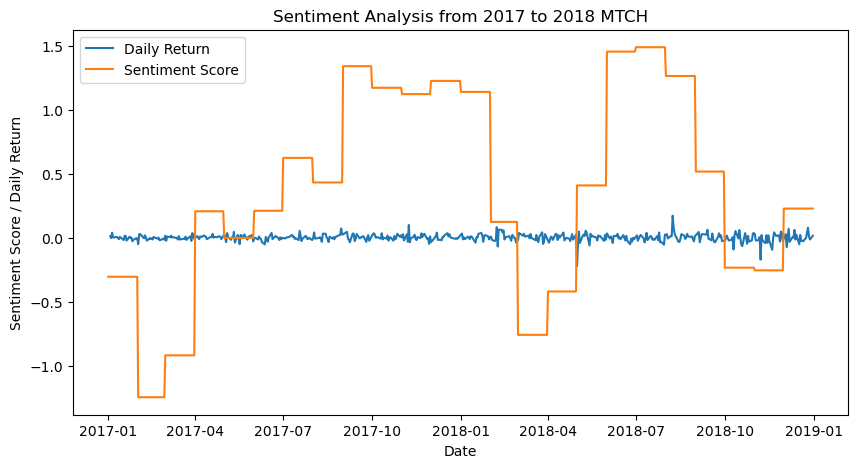

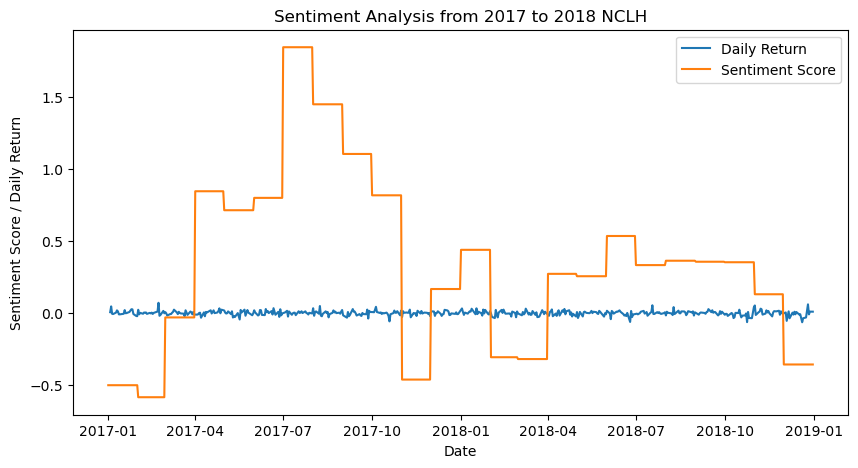

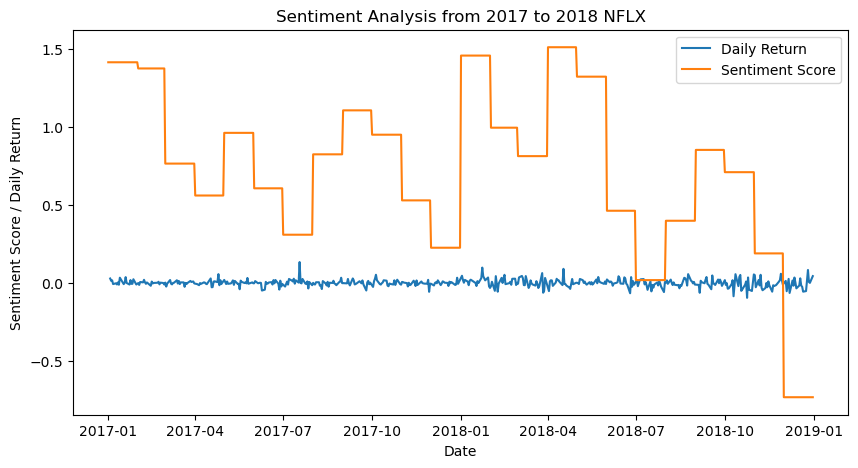

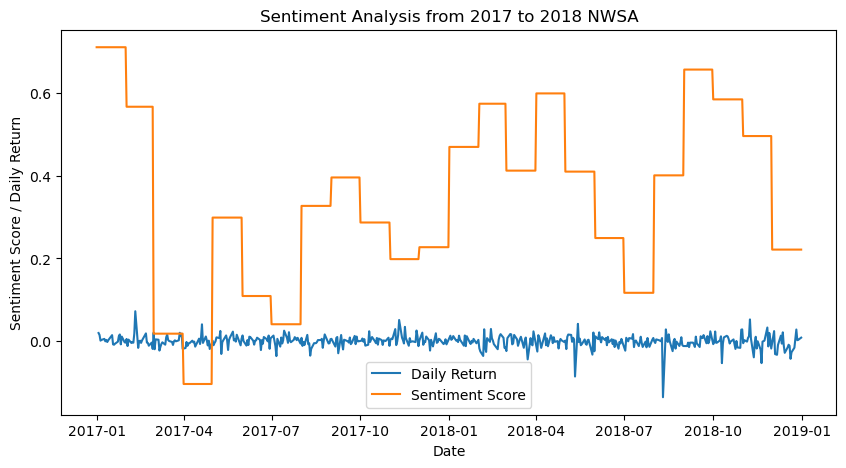

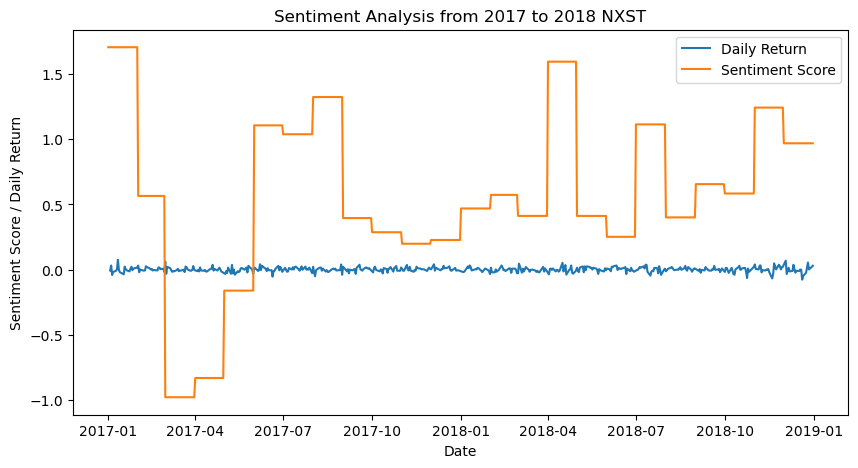

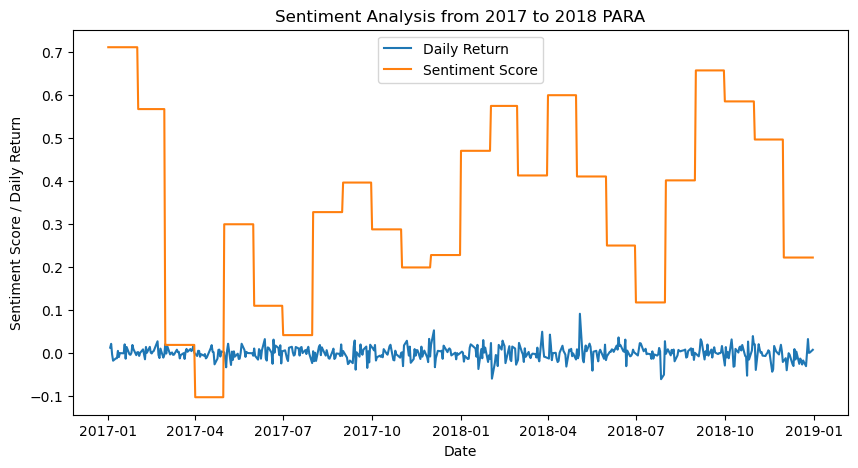

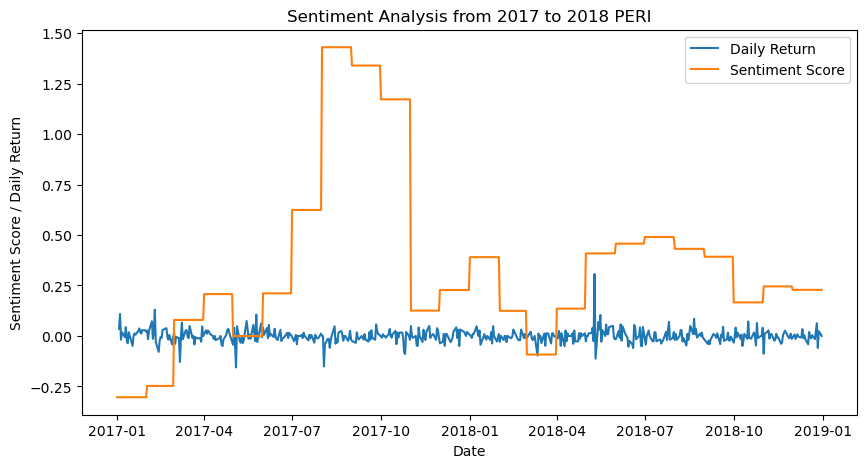

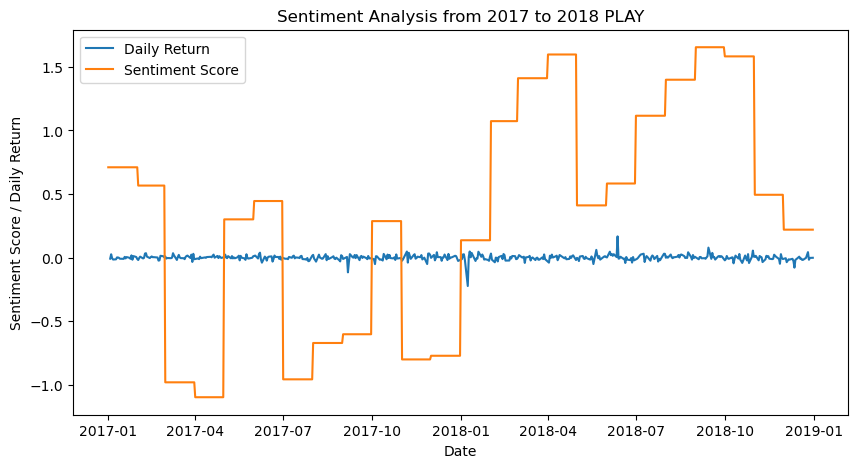

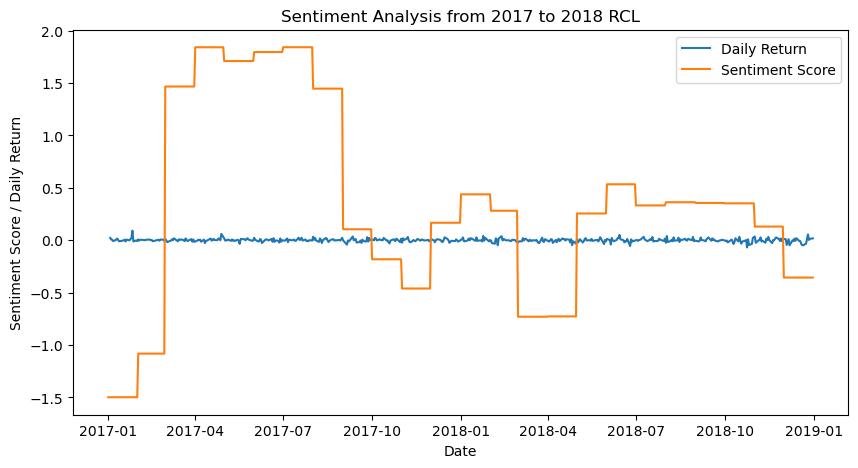

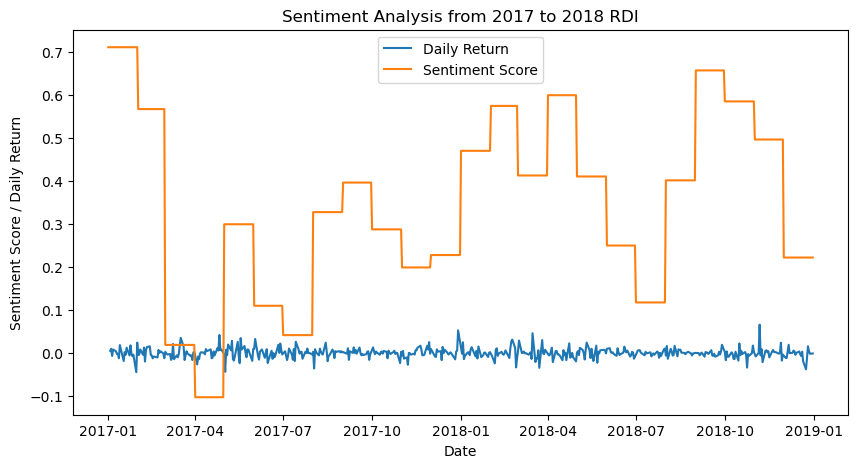

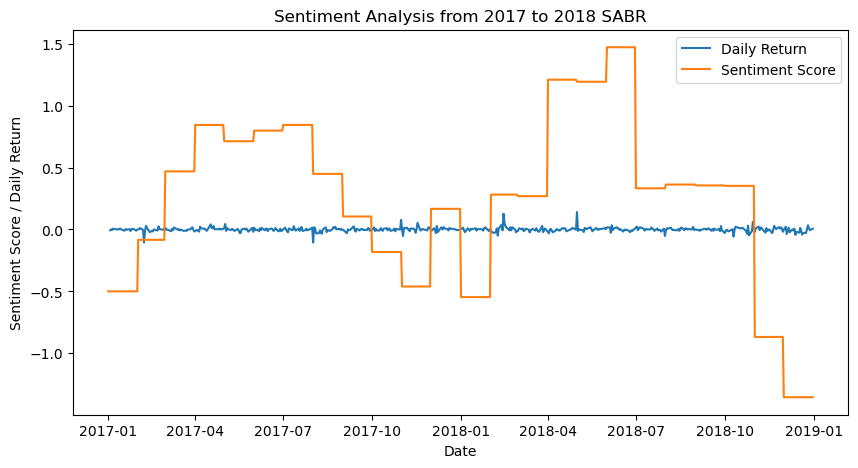

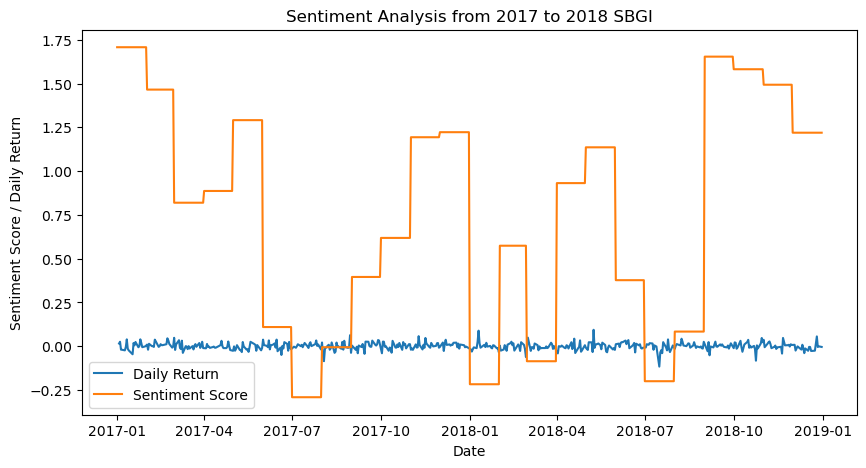

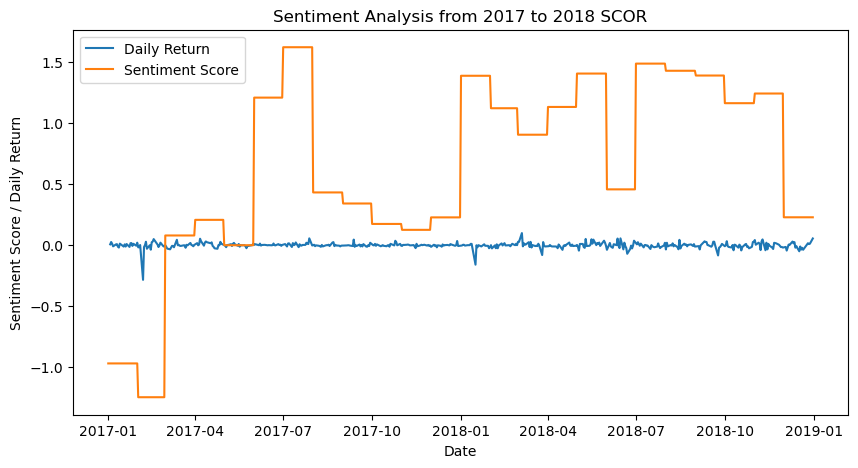

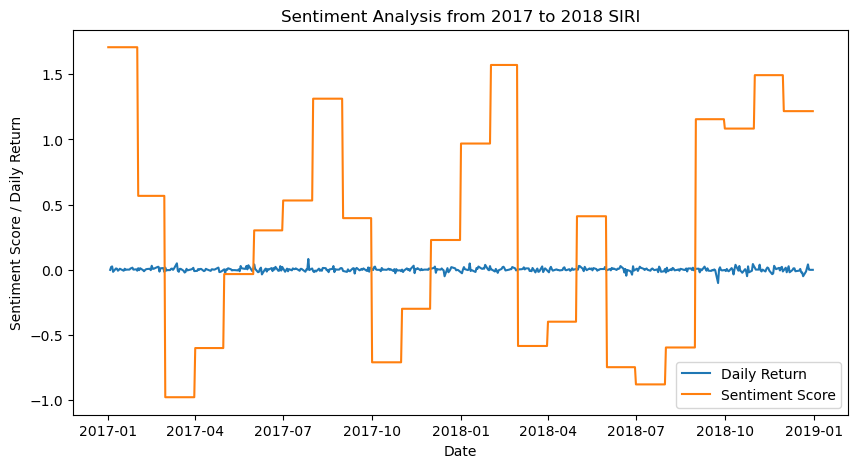

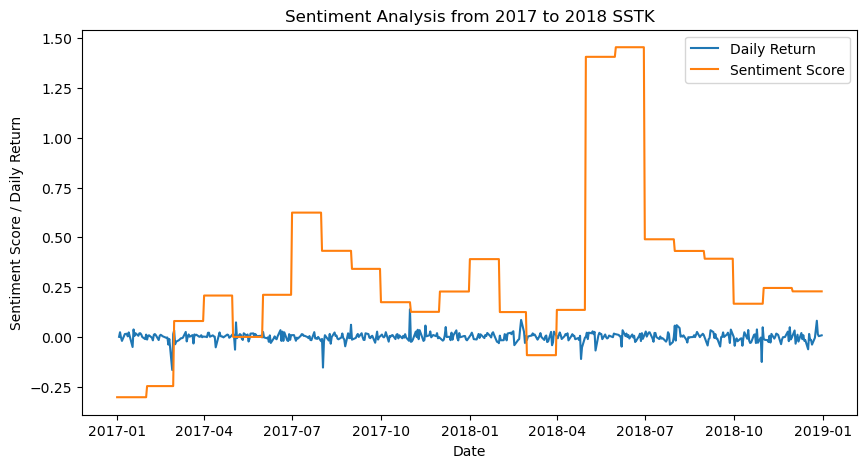

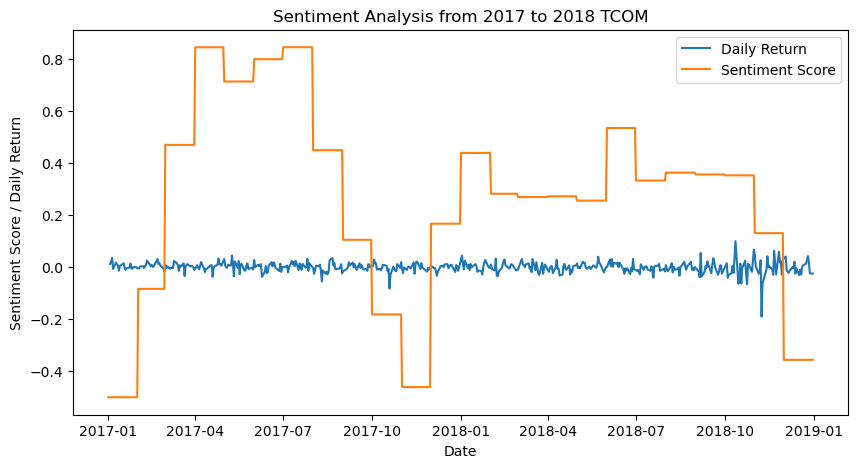

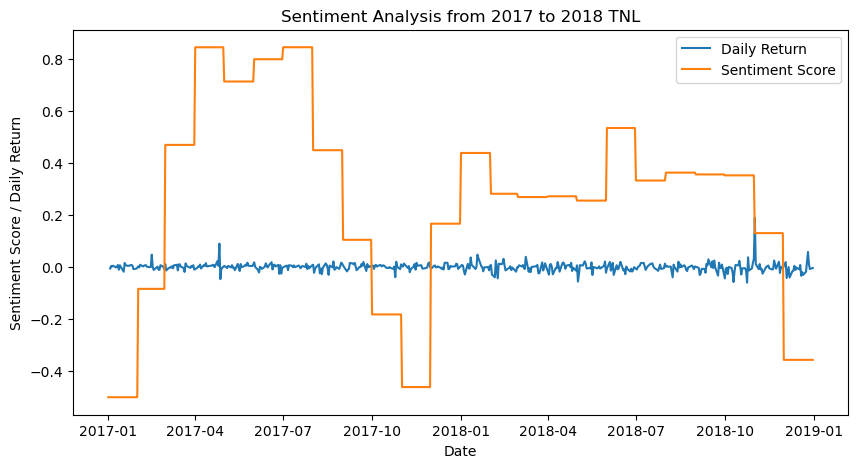

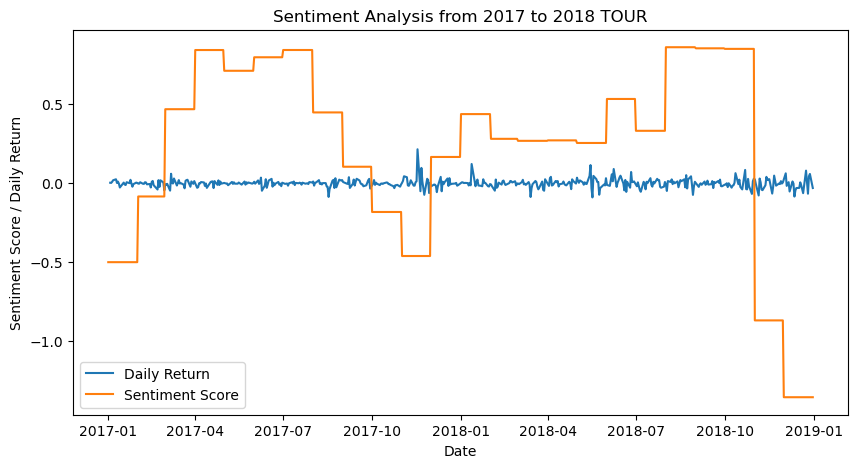

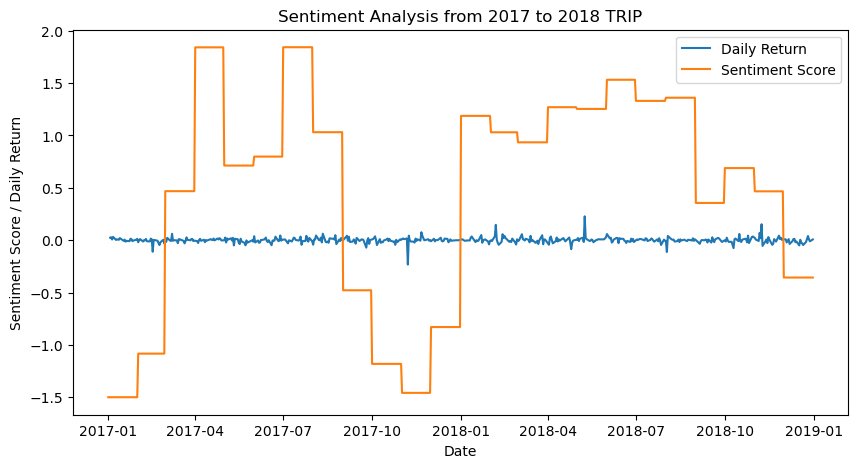

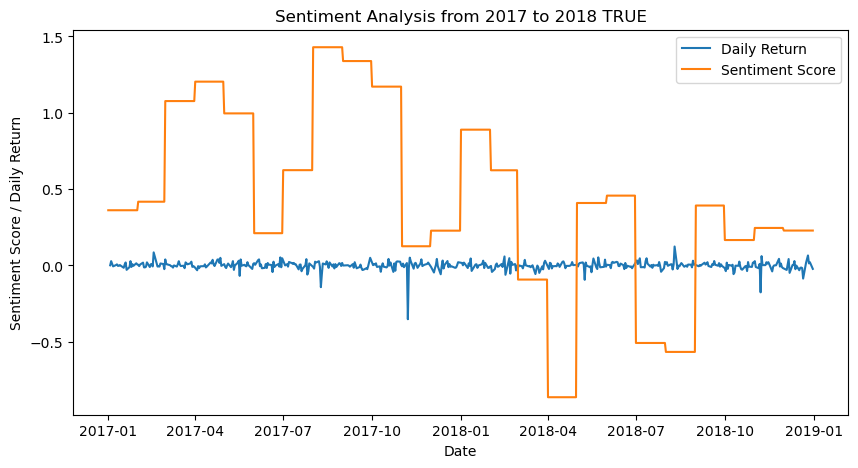

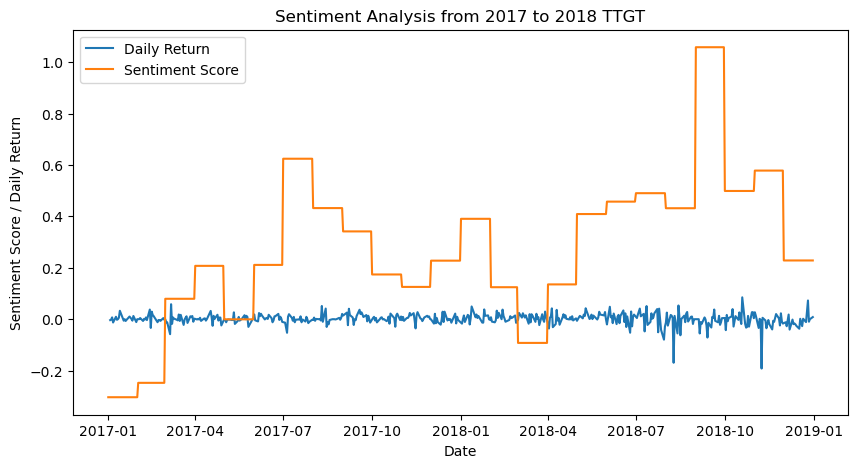

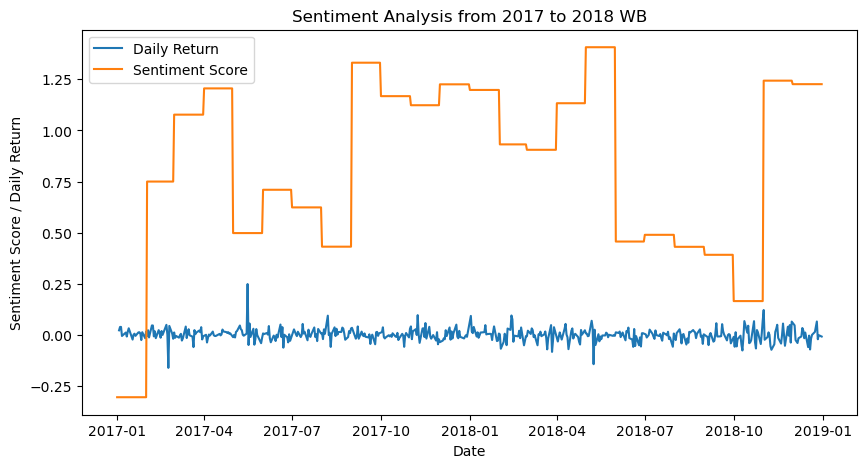

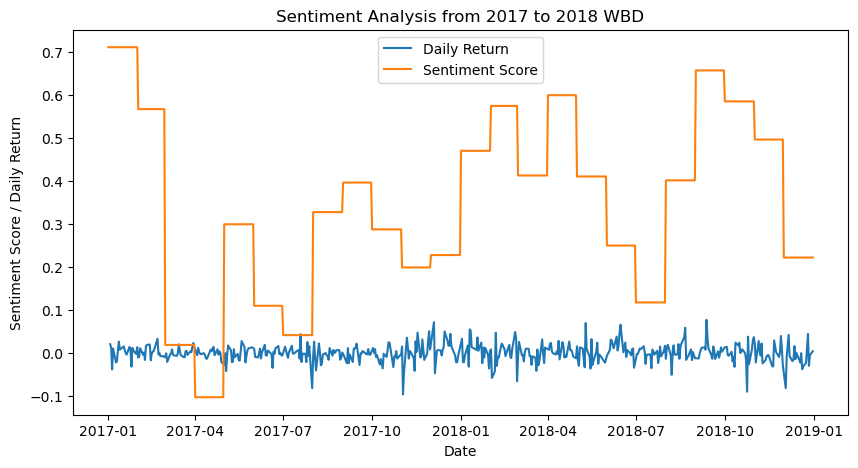

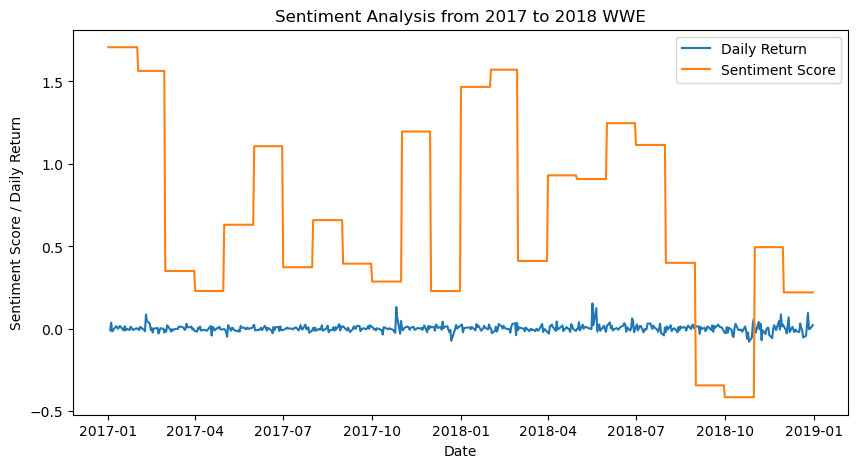

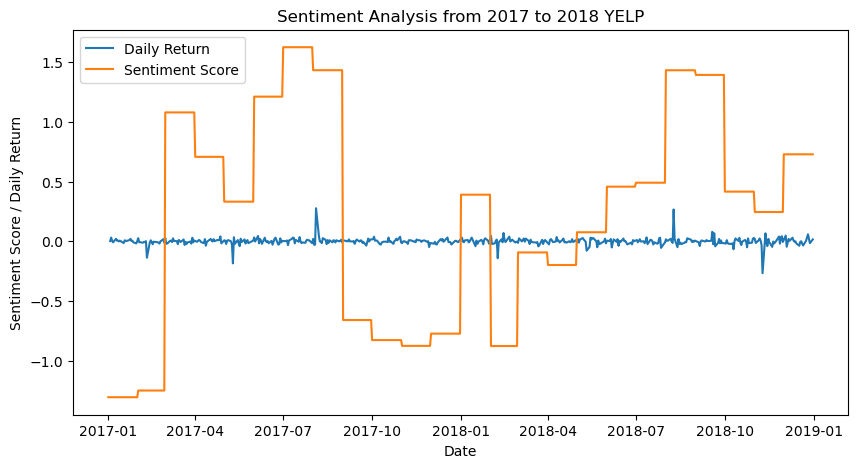

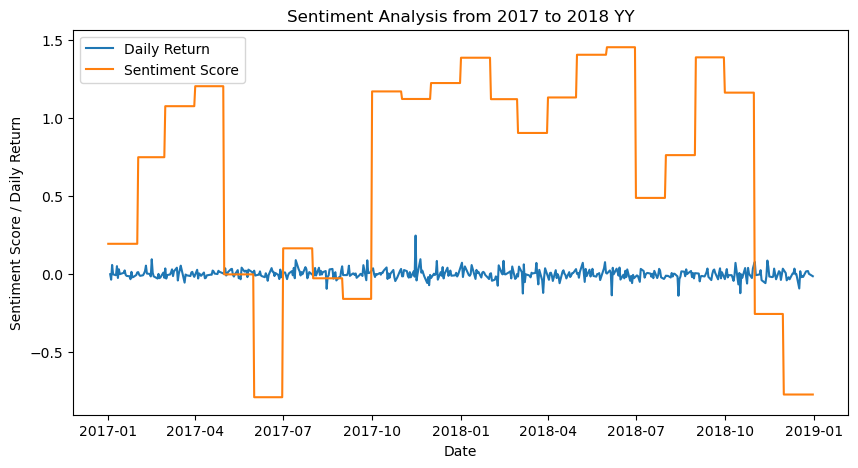

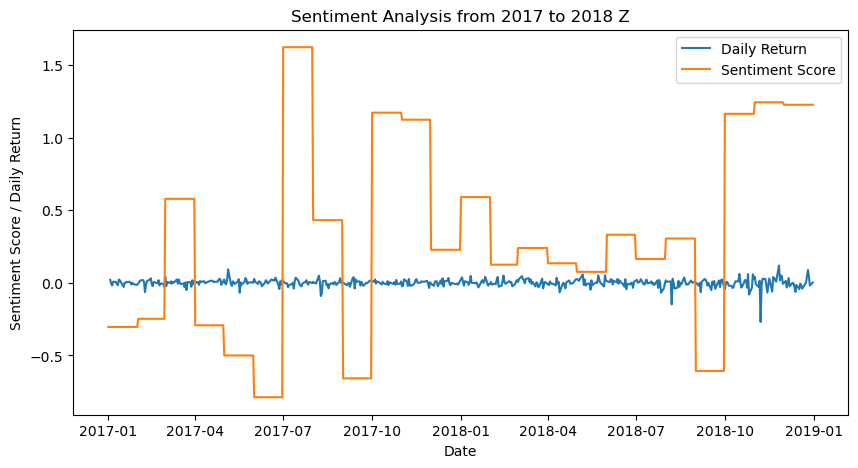

In [34]:
# plot sentiment distribution for each company
for company in selected_companies:
    temp = df_stock[df_stock['Company'] == company]
    start_date = '2017-01-01'
    end_date = '2018-12-31'
    stock = temp[(temp['Date'] >= start_date) & (temp['Date'] <= end_date)]
    stock = stock.rename(columns={"monthly_daily_return_median": "daily_return"})
    temp = df_sentiment[df_sentiment['Company'] == company]
    sentiment = temp[(temp['Date'] >= start_date) & (temp['Date'] <= end_date)]
    plt.figure(figsize=(10, 5))
    # sns.lineplot(data=df_sentiment[df_sentiment['Company'] == company], x='Date', y='sentiment')
    sns.lineplot(data=stock, x='Date', y='daily_return', label='Daily Return')
    sns.lineplot(data=sentiment, x='Date', y='sentiment', label='Sentiment Score')
    plt.title(f'Sentiment Analysis from 2017 to 2018 {company}')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score / Daily Return')
    plt.legend()
    plt.show()


Model and Dataset Class

In [35]:
# dataset class
class StockPriceDataset(Dataset):
    def __init__(self, data, window_size, output_dim):
        self.window_size = window_size
        self.data = data
        self.output_dim = output_dim
        self.normalize()
        self.sequenced_data = self.sequence_data()

    def normalize(self):
        
        # normalize data
        self.data["daily_return"] = (self.data["daily_return"] - self.data["daily_return"].min()) / (self.data["daily_return"].max() - self.data["daily_return"].min() + 1e-8)
        self.data["sentiment"] = (self.data["sentiment"] - self.data["sentiment"].min()) / (self.data["sentiment"].max() - self.data["sentiment"].min() + 1e-8)
        self.data["sentiment_company"] = (self.data["sentiment_company"] - self.data["sentiment_company"].min()) / (self.data["sentiment_company"].max() - self.data["sentiment_company"].min() + 1e-8)
        self.data["sentiment_industry"] = (self.data["sentiment_industry"] - self.data["sentiment_industry"].min()) / (self.data["sentiment_industry"].max() - self.data["sentiment_industry"].min() + 1e-8)

    # create sequences by seperating each month data into seperate sequence
    def sequence_data(self):
        data = self.data
        list_of_df = []
        temp = data.copy()
        temp = temp.reset_index()
        temp["Date"] = pd.to_datetime(temp["Date"])
        all_available_dates = temp["Date"].unique()
    
        for i in range(len(all_available_dates)):
            date = all_available_dates[i]
            temp_df = data[data.index == date]
            list_of_df.append(temp_df)
        return list_of_df
        

    def __len__(self):
        return len(self.sequenced_data) - self.window_size - self.output_dim + 1

    def __getitem__(self, idx):
        if self.window_size == 1:
            sequences = self.sequenced_data[idx]
            data = sequences
        else:
            sequences = self.sequenced_data[idx: idx + self.window_size]
            data = pd.concat(sequences, axis=0)
            # data = torch.nn.utils.rnn.pad_sequence([torch.tensor(seq.values).float() for seq in sequences], batch_first=True)
        x = data.iloc[:, :].values
        # x = data
        if self.window_size == 1:
            sequences_output = self.sequenced_data[idx: idx + self.output_dim]
            data_output = sequences_output[0]
        else:
            sequences_output = self.sequenced_data[idx : idx + self.window_size + self.output_dim]
            data_output = pd.concat(sequences_output, axis=0)
        y = data_output.iloc[-self.output_dim:, -1:].values
        return torch.tensor(x).float().to(device), torch.tensor(y).float().to(device)
        # return x.to(device), torch.tensor(y).float().to(device)
    
    def return_sequences(self, idx):
        return self.sequenced_data[idx: idx+1]

In [36]:
# LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout = dropout

        self.conv1 = nn.Conv1d(in_channels=input_dim, out_channels=2, kernel_size=3, stride=1)
        if num_layers == 1:
            self.lstm = nn.LSTM(2, hidden_dim, num_layers, batch_first=True, bidirectional=False)
        else:
            self.lstm = nn.LSTM(2, hidden_dim, num_layers, batch_first=True, dropout=dropout, bidirectional=False)
        self.fc = nn.Linear(hidden_dim, output_dim)

        # if num_layers == 1:
        #     self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=False)
        # else:
        #     self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout, bidirectional=False)
        # self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = x.permute(0, 2, 1)
        
        _, (hidden_n, _) = self.lstm(x)
        
        out = self.fc(hidden_n[-1, :, :])

        return out 

Create Dataset and DataLoader, Set Hyperparameters and Build Model

In [37]:
# Hyperparameters
window_size = 365  # sequence length for each input of time series data
# input_dim = df_merged.shape[1] # number of features
input_dim = 4
hidden_dim = 20 # number of hidden units
num_layers = 2 # number of LSTM layers
# output_dims = [30,90,180,360] # predict next specified days 
output_dims = [30,90,180,360] # predict next specified days
num_epochs = 20
batch_size = 32
learning_rate = 1e-3
dropout = 0.2
weight_decay = 1e-2
learning_rate_decay = 1e-1
learning_rate_step_size = 25
num_workers = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
save_every = 5
print("device: ", device)

device:  cuda


In [133]:
# create dataset and dataloader
output_dim = 180
# train, validation, test split
# temp = df_merged.iloc[:int(0.8*len(df_merged))]
# train = temp.iloc[:int(0.8*len(temp))]
# val = temp.iloc[int(0.8*len(temp)):]
# test = df_merged.iloc[int(0.8*len(df_merged)):]
# train = df_merged[(df_merged.index >= '2012-01-01') & (df_merged.index <= '2018-12-31')]
# val = df_merged[(df_merged.index >= '2019-01-01') & (df_merged.index <= '2021-11-30')]
# test = df_merged[(df_merged.index >= '2021-12-01') & (df_merged.index <= '2021-12-31')]
train = df_merged_company[(df_merged_company.index >= '2012-01-01') & (df_merged_company.index <= '2018-12-31')]
val = df_merged_company[(df_merged_company.index >= '2019-01-01') & (df_merged_company.index <= '2021-12-30')]
test = df_merged_company[(df_merged_company.index >= '2020-01-01') & (df_merged_company.index <= '2022-12-31')]

# create dataset
train = StockPriceDataset(train, window_size, output_dim)
val = StockPriceDataset(val, window_size, output_dim)
test = StockPriceDataset(test, window_size, output_dim)

# create dataloader
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, num_workers=num_workers)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# suppress SettingWithCopyWarning
pd.options.mode.chained_assignment = None

In [134]:
for item in test_loader:
    print(item[0].shape)
    print(item[1].shape)
    break

torch.Size([32, 365, 4])
torch.Size([32, 180, 1])


In [18]:
# initialize model, loss function, and optimizer
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim, dropout).to(device)
criterion = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=learning_rate_step_size, gamma=learning_rate_decay)


NameError: name 'output_dim' is not defined

Train Model

In [38]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    # plt.savefig("./dump/losses.png")
    # plt.close()

In [ ]:
# training loop
train_losses = []
val_losses = []
previous_val_loss = 0.0
val_loss_increase_count = 0
save_current_model = True
current_best_model = None
current_best_optimizer = None

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    num_train_batches = 0
    num_val_batches = 0

    # train model
    model.train()
    for sequence in train_loader:
        inputs, targets = sequence
        targets = targets.squeeze(-1) # remove last dimension
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        num_train_batches += 1
    
    # validate model
    model.eval()
    with torch.no_grad():
        for sequence in val_loader:
            inputs, targets = sequence
            targets = targets.squeeze(-1) # remove last dimension

            output = model(inputs)
            loss = criterion(output, targets)
            
            val_loss += loss.item()
            num_val_batches += 1
    
    if val_loss > previous_val_loss:
        val_loss_increase_count += 1
        print('Validation loss increased! ', val_loss_increase_count)
        if save_current_model:
            current_best_model = copy.deepcopy(model.state_dict())
            current_best_optimizer = copy.deepcopy(optimizer.state_dict())
            save_current_model = False
    else:
        val_loss_increase_count = 0
        save_current_model = True
    
    if val_loss_increase_count >= 5:
        # restore the best model
        model.load_state_dict(current_best_model)
        optimizer.load_state_dict(current_best_optimizer)
        val_loss_increase_count = 0
        # reduce learning rate
        for param_group in optimizer.param_groups:
            param_group['lr'] *= learning_rate_decay
    previous_val_loss = val_loss
    
    scheduler.step()
    train_loss /= num_train_batches
    val_loss /= num_val_batches
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, val_loss))
plot_losses(train_losses, val_losses)

In [ ]:
# Save the trained model
model_name = 'lstm-'
# company_name = 'apple-'
# company_name = 'microsoft-'
# company_name = 'google-'
# company_name = 'meta-'
company_name = 'yelp-'
predoction_months = '6-'
path = model_dir + model_name + company_name + predoction_months + '.pth'
torch.save(model.state_dict(), path)


In [62]:
# save dataset in pickle file
# test_dataset_name = 'test_dataset.pkl'
test_dataset_name = 'test_dataset-'
# company_name = 'apple-'
# company_name = 'microsoft-'
# company_name = 'google-'
# company_name = 'yelp-'
company_name = 'Meta-'
predoction_months = '30-'
path = data_dir + test_dataset_name + company_name + predoction_months + '.pkl'
with open(path, 'wb') as f:
    # pickle.dump(test, f)
    pickle.dump(train, f)

Epoch: 1 	Training Loss: 0.040789 	Validation Loss: 0.109972
Epoch: 2 	Training Loss: 0.015630 	Validation Loss: 0.065340
overwrite model
Epoch: 3 	Training Loss: 0.005101 	Validation Loss: 0.056066
overwrite model
Epoch: 4 	Training Loss: 0.003891 	Validation Loss: 0.054007
overwrite model
Epoch: 5 	Training Loss: 0.003507 	Validation Loss: 0.053103
overwrite model
Epoch: 6 	Training Loss: 0.003322 	Validation Loss: 0.052639
overwrite model
Epoch: 7 	Training Loss: 0.003224 	Validation Loss: 0.052409
overwrite model
Epoch: 8 	Training Loss: 0.003175 	Validation Loss: 0.052322
overwrite model
Epoch: 9 	Training Loss: 0.003155 	Validation Loss: 0.052326
Epoch: 10 	Training Loss: 0.003155 	Validation Loss: 0.052387
Epoch: 11 	Training Loss: 0.003166 	Validation Loss: 0.052482
Epoch: 12 	Training Loss: 0.003184 	Validation Loss: 0.052594
Epoch: 13 	Training Loss: 0.003204 	Validation Loss: 0.052710
Epoch: 14 	Training Loss: 0.003223 	Validation Loss: 0.052818
Epoch: 15 	Training Loss: 0.0

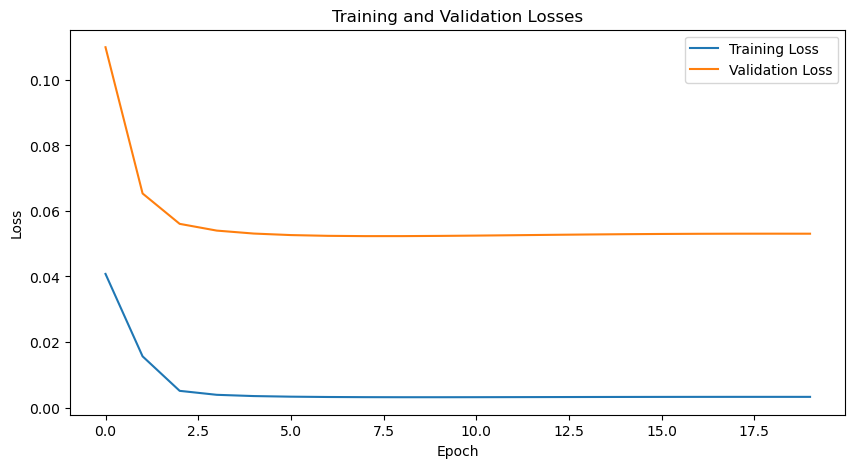

Epoch: 1 	Training Loss: 0.049719 	Validation Loss: 0.140122
Epoch: 2 	Training Loss: 0.034941 	Validation Loss: 0.116391
overwrite model
Epoch: 3 	Training Loss: 0.023132 	Validation Loss: 0.095144
overwrite model
Epoch: 4 	Training Loss: 0.014782 	Validation Loss: 0.081220
overwrite model
Epoch: 5 	Training Loss: 0.010585 	Validation Loss: 0.074357
overwrite model
Epoch: 6 	Training Loss: 0.008730 	Validation Loss: 0.071015
overwrite model
Epoch: 7 	Training Loss: 0.007858 	Validation Loss: 0.069361
overwrite model
Epoch: 8 	Training Loss: 0.007444 	Validation Loss: 0.068607
overwrite model
Epoch: 9 	Training Loss: 0.007268 	Validation Loss: 0.068365
overwrite model
Epoch: 10 	Training Loss: 0.007228 	Validation Loss: 0.068424
Epoch: 11 	Training Loss: 0.007266 	Validation Loss: 0.068657
Epoch: 12 	Training Loss: 0.007350 	Validation Loss: 0.068988
Epoch: 13 	Training Loss: 0.007459 	Validation Loss: 0.069367
Epoch: 14 	Training Loss: 0.007580 	Validation Loss: 0.069763
Epoch: 15 	Tr

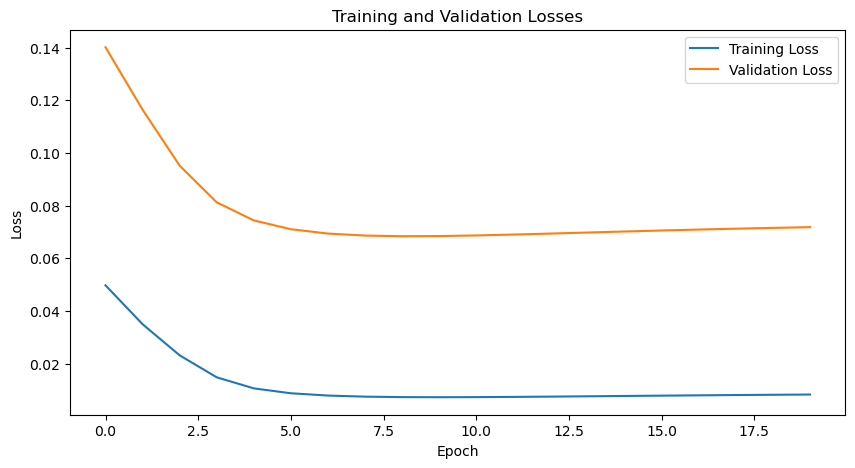

Epoch: 1 	Training Loss: 0.047463 	Validation Loss: 0.142525
Epoch: 2 	Training Loss: 0.037984 	Validation Loss: 0.129279
overwrite model
Epoch: 3 	Training Loss: 0.031370 	Validation Loss: 0.119038
overwrite model
Epoch: 4 	Training Loss: 0.026600 	Validation Loss: 0.111338
overwrite model
Epoch: 5 	Training Loss: 0.023241 	Validation Loss: 0.105754
overwrite model
Epoch: 6 	Training Loss: 0.020938 	Validation Loss: 0.101841
overwrite model
Epoch: 7 	Training Loss: 0.019399 	Validation Loss: 0.099182
overwrite model
Epoch: 8 	Training Loss: 0.018395 	Validation Loss: 0.097432
overwrite model
Epoch: 9 	Training Loss: 0.017757 	Validation Loss: 0.096321
overwrite model
Epoch: 10 	Training Loss: 0.017367 	Validation Loss: 0.095653
overwrite model
Epoch: 11 	Training Loss: 0.017143 	Validation Loss: 0.095285
overwrite model
Epoch: 12 	Training Loss: 0.017028 	Validation Loss: 0.095120
overwrite model
Epoch: 13 	Training Loss: 0.016986 	Validation Loss: 0.095089
overwrite model
Epoch: 14 	

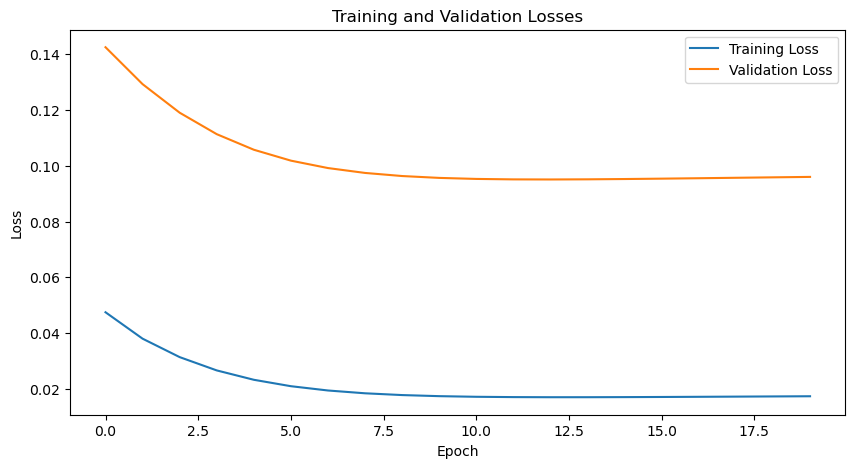

Epoch: 1 	Training Loss: 0.048380 	Validation Loss: 0.145774
Epoch: 2 	Training Loss: 0.042247 	Validation Loss: 0.138861
overwrite model
Epoch: 3 	Training Loss: 0.038159 	Validation Loss: 0.133548
overwrite model
Epoch: 4 	Training Loss: 0.035193 	Validation Loss: 0.129354
overwrite model
Epoch: 5 	Training Loss: 0.032990 	Validation Loss: 0.126061
overwrite model
Epoch: 6 	Training Loss: 0.031348 	Validation Loss: 0.123512
overwrite model
Epoch: 7 	Training Loss: 0.030131 	Validation Loss: 0.121575
overwrite model
Epoch: 8 	Training Loss: 0.029240 	Validation Loss: 0.120132
overwrite model
Epoch: 9 	Training Loss: 0.028597 	Validation Loss: 0.119081
overwrite model
Epoch: 10 	Training Loss: 0.028141 	Validation Loss: 0.118330
overwrite model
Epoch: 11 	Training Loss: 0.027823 	Validation Loss: 0.117806
overwrite model
Epoch: 12 	Training Loss: 0.027605 	Validation Loss: 0.117448
overwrite model
Epoch: 13 	Training Loss: 0.027459 	Validation Loss: 0.117207
overwrite model
Epoch: 14 	

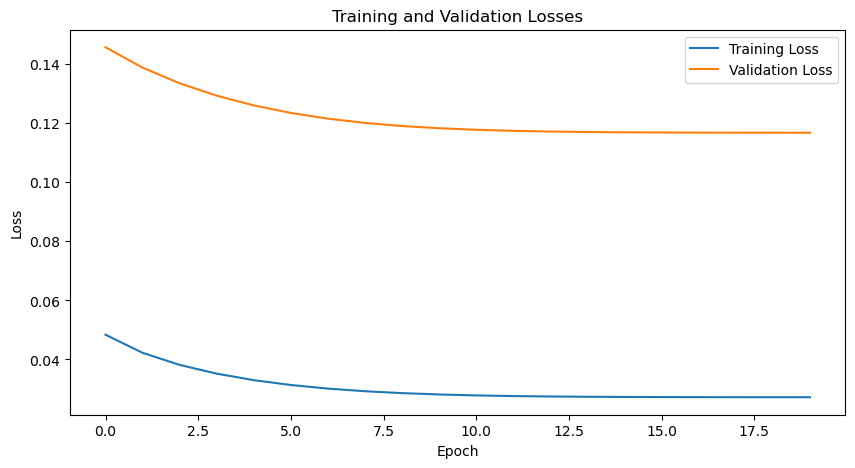

Epoch: 1 	Training Loss: 0.022219 	Validation Loss: 0.074709
Epoch: 2 	Training Loss: 0.009375 	Validation Loss: 0.057660
overwrite model
Epoch: 3 	Training Loss: 0.005049 	Validation Loss: 0.051312
overwrite model
Epoch: 4 	Training Loss: 0.003694 	Validation Loss: 0.048548
overwrite model
Epoch: 5 	Training Loss: 0.003090 	Validation Loss: 0.046935
overwrite model
Epoch: 6 	Training Loss: 0.002718 	Validation Loss: 0.045763
overwrite model
Epoch: 7 	Training Loss: 0.002428 	Validation Loss: 0.044731
overwrite model
Epoch: 8 	Training Loss: 0.002166 	Validation Loss: 0.043726
overwrite model
Epoch: 9 	Training Loss: 0.001923 	Validation Loss: 0.042758
overwrite model
Epoch: 10 	Training Loss: 0.001711 	Validation Loss: 0.041896
overwrite model
Epoch: 11 	Training Loss: 0.001544 	Validation Loss: 0.041196
overwrite model
Epoch: 12 	Training Loss: 0.001424 	Validation Loss: 0.040674
overwrite model
Epoch: 13 	Training Loss: 0.001344 	Validation Loss: 0.040313
overwrite model
Epoch: 14 	

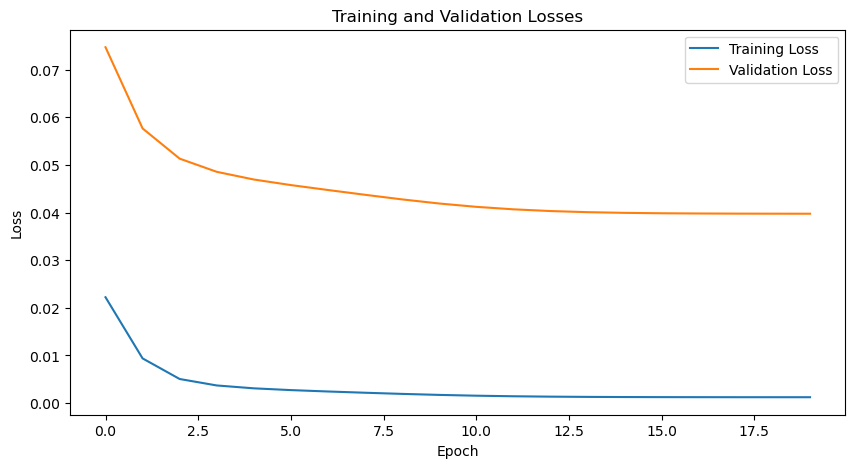

Epoch: 1 	Training Loss: 0.020022 	Validation Loss: 0.078455
Epoch: 2 	Training Loss: 0.013560 	Validation Loss: 0.069823
overwrite model
Epoch: 3 	Training Loss: 0.009884 	Validation Loss: 0.063944
overwrite model
Epoch: 4 	Training Loss: 0.007663 	Validation Loss: 0.059927
overwrite model
Epoch: 5 	Training Loss: 0.006279 	Validation Loss: 0.057134
overwrite model
Epoch: 6 	Training Loss: 0.005373 	Validation Loss: 0.055125
overwrite model
Epoch: 7 	Training Loss: 0.004758 	Validation Loss: 0.053662
overwrite model
Epoch: 8 	Training Loss: 0.004341 	Validation Loss: 0.052617
overwrite model
Epoch: 9 	Training Loss: 0.004063 	Validation Loss: 0.051898
overwrite model
Epoch: 10 	Training Loss: 0.003885 	Validation Loss: 0.051423
overwrite model
Epoch: 11 	Training Loss: 0.003773 	Validation Loss: 0.051119
overwrite model
Epoch: 12 	Training Loss: 0.003705 	Validation Loss: 0.050931
overwrite model
Epoch: 13 	Training Loss: 0.003664 	Validation Loss: 0.050818
overwrite model
Epoch: 14 	

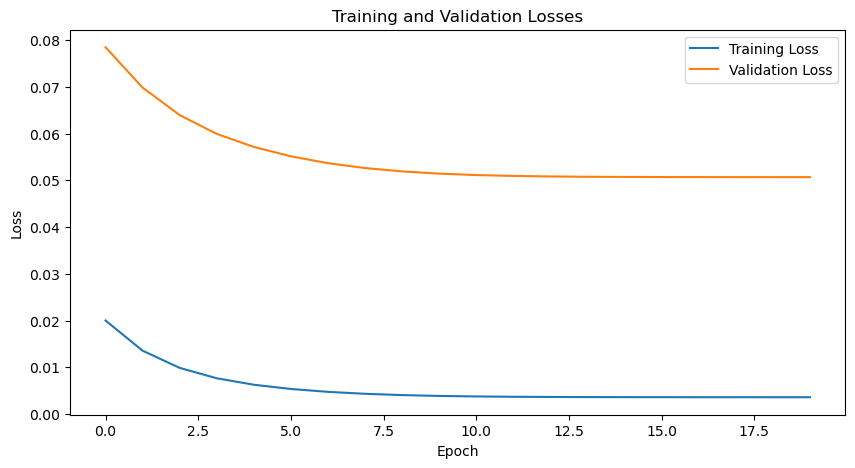

Epoch: 1 	Training Loss: 0.019574 	Validation Loss: 0.079640
Epoch: 2 	Training Loss: 0.014461 	Validation Loss: 0.073376
overwrite model
Epoch: 3 	Training Loss: 0.011556 	Validation Loss: 0.069064
overwrite model
Epoch: 4 	Training Loss: 0.009712 	Validation Loss: 0.065971
overwrite model
Epoch: 5 	Training Loss: 0.008500 	Validation Loss: 0.063758
overwrite model
Epoch: 6 	Training Loss: 0.007699 	Validation Loss: 0.062198
overwrite model
Epoch: 7 	Training Loss: 0.007172 	Validation Loss: 0.061119
overwrite model
Epoch: 8 	Training Loss: 0.006829 	Validation Loss: 0.060388
overwrite model
Epoch: 9 	Training Loss: 0.006608 	Validation Loss: 0.059903
overwrite model
Epoch: 10 	Training Loss: 0.006467 	Validation Loss: 0.059590
overwrite model
Epoch: 11 	Training Loss: 0.006380 	Validation Loss: 0.059393
overwrite model
Epoch: 12 	Training Loss: 0.006326 	Validation Loss: 0.059271
overwrite model
Epoch: 13 	Training Loss: 0.006294 	Validation Loss: 0.059199
overwrite model
Epoch: 14 	

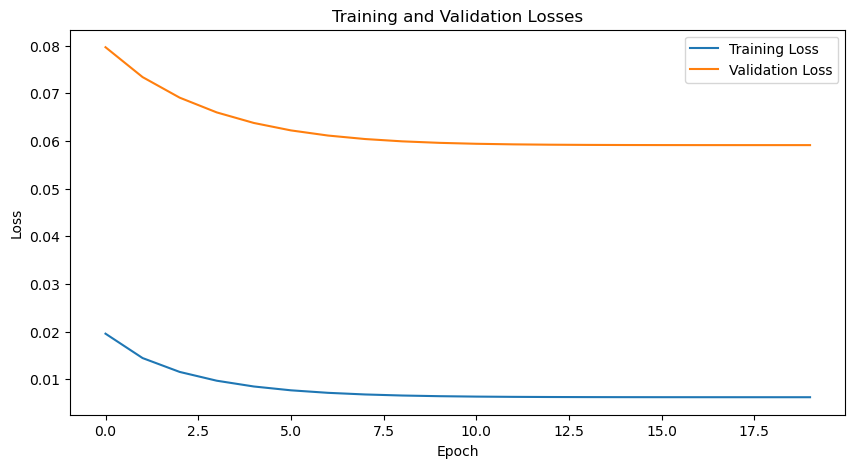

Epoch: 1 	Training Loss: 0.022734 	Validation Loss: 0.085970
Epoch: 2 	Training Loss: 0.017420 	Validation Loss: 0.080659
overwrite model
Epoch: 3 	Training Loss: 0.014486 	Validation Loss: 0.077153
overwrite model
Epoch: 4 	Training Loss: 0.012672 	Validation Loss: 0.074648
overwrite model
Epoch: 5 	Training Loss: 0.011491 	Validation Loss: 0.072806
overwrite model
Epoch: 6 	Training Loss: 0.010698 	Validation Loss: 0.071434
overwrite model
Epoch: 7 	Training Loss: 0.010155 	Validation Loss: 0.070419
overwrite model
Epoch: 8 	Training Loss: 0.009781 	Validation Loss: 0.069679
overwrite model
Epoch: 9 	Training Loss: 0.009524 	Validation Loss: 0.069153
overwrite model
Epoch: 10 	Training Loss: 0.009350 	Validation Loss: 0.068790
overwrite model
Epoch: 11 	Training Loss: 0.009234 	Validation Loss: 0.068547
overwrite model
Epoch: 12 	Training Loss: 0.009159 	Validation Loss: 0.068388
overwrite model
Epoch: 13 	Training Loss: 0.009111 	Validation Loss: 0.068288
overwrite model
Epoch: 14 	

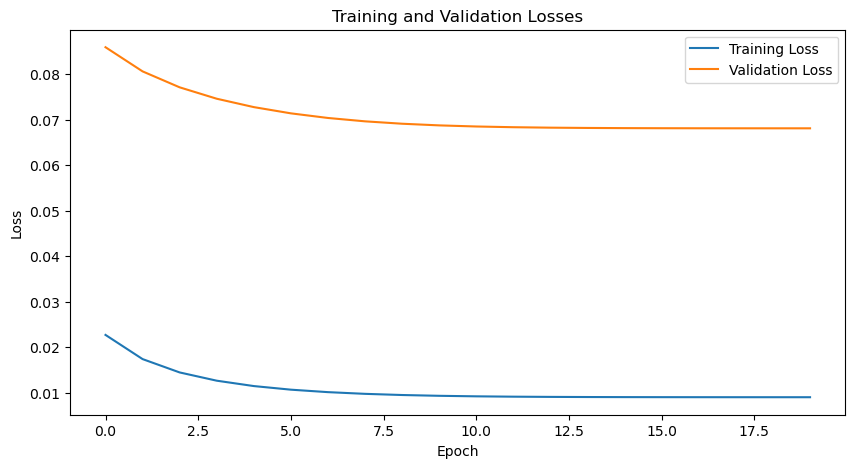

Epoch: 1 	Training Loss: 0.102833 	Validation Loss: 0.097405
Epoch: 2 	Training Loss: 0.055085 	Validation Loss: 0.037840
overwrite model
Epoch: 3 	Training Loss: 0.013914 	Validation Loss: 0.013414
overwrite model
Epoch: 4 	Training Loss: 0.007256 	Validation Loss: 0.011667
overwrite model
Epoch: 5 	Training Loss: 0.006602 	Validation Loss: 0.011173
overwrite model
Epoch: 6 	Training Loss: 0.006336 	Validation Loss: 0.010957
overwrite model
Epoch: 7 	Training Loss: 0.006175 	Validation Loss: 0.010839
overwrite model
Epoch: 8 	Training Loss: 0.006069 	Validation Loss: 0.010783
overwrite model
Epoch: 9 	Training Loss: 0.005997 	Validation Loss: 0.010765
overwrite model
Epoch: 10 	Training Loss: 0.005946 	Validation Loss: 0.010771
Epoch: 11 	Training Loss: 0.005911 	Validation Loss: 0.010788
Epoch: 12 	Training Loss: 0.005889 	Validation Loss: 0.010811
Epoch: 13 	Training Loss: 0.005875 	Validation Loss: 0.010838
Epoch: 14 	Training Loss: 0.005869 	Validation Loss: 0.010866
Epoch: 15 	Tr

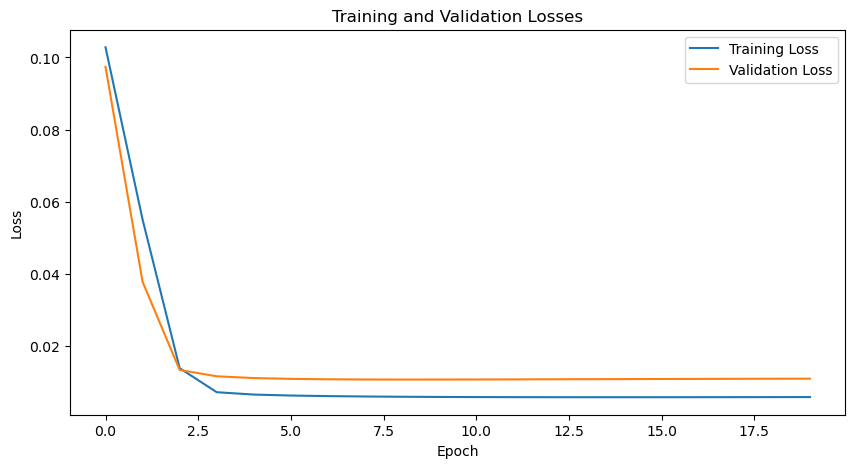

Epoch: 1 	Training Loss: 0.102943 	Validation Loss: 0.110698
Epoch: 2 	Training Loss: 0.084020 	Validation Loss: 0.091195
overwrite model
Epoch: 3 	Training Loss: 0.064911 	Validation Loss: 0.067214
overwrite model
Epoch: 4 	Training Loss: 0.040168 	Validation Loss: 0.035974
overwrite model
Epoch: 5 	Training Loss: 0.017330 	Validation Loss: 0.018556
overwrite model
Epoch: 6 	Training Loss: 0.010370 	Validation Loss: 0.015354
overwrite model
Epoch: 7 	Training Loss: 0.008776 	Validation Loss: 0.014227
overwrite model
Epoch: 8 	Training Loss: 0.008020 	Validation Loss: 0.013752
overwrite model
Epoch: 9 	Training Loss: 0.007570 	Validation Loss: 0.013485
overwrite model
Epoch: 10 	Training Loss: 0.007267 	Validation Loss: 0.013225
overwrite model
Epoch: 11 	Training Loss: 0.007047 	Validation Loss: 0.012942
overwrite model
Epoch: 12 	Training Loss: 0.006885 	Validation Loss: 0.012676
overwrite model
Epoch: 13 	Training Loss: 0.006765 	Validation Loss: 0.012447
overwrite model
Epoch: 14 	

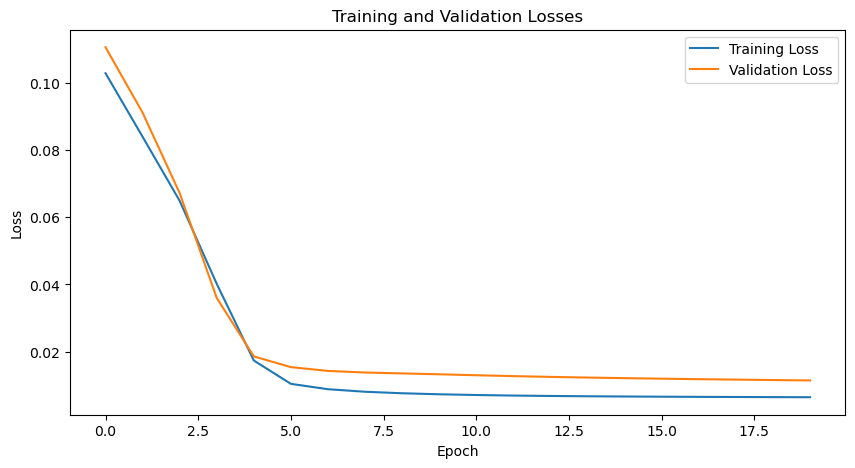

Epoch: 1 	Training Loss: 0.107913 	Validation Loss: 0.118357
Epoch: 2 	Training Loss: 0.093997 	Validation Loss: 0.103687
overwrite model
Epoch: 3 	Training Loss: 0.079630 	Validation Loss: 0.086279
overwrite model
Epoch: 4 	Training Loss: 0.060577 	Validation Loss: 0.060197
overwrite model
Epoch: 5 	Training Loss: 0.033511 	Validation Loss: 0.029006
overwrite model
Epoch: 6 	Training Loss: 0.015413 	Validation Loss: 0.019276
overwrite model
Epoch: 7 	Training Loss: 0.011153 	Validation Loss: 0.016793
overwrite model
Epoch: 8 	Training Loss: 0.009646 	Validation Loss: 0.015610
overwrite model
Epoch: 9 	Training Loss: 0.008852 	Validation Loss: 0.014770
overwrite model
Epoch: 10 	Training Loss: 0.008370 	Validation Loss: 0.014145
overwrite model
Epoch: 11 	Training Loss: 0.008069 	Validation Loss: 0.013725
overwrite model
Epoch: 12 	Training Loss: 0.007877 	Validation Loss: 0.013440
overwrite model
Epoch: 13 	Training Loss: 0.007753 	Validation Loss: 0.013246
overwrite model
Epoch: 14 	

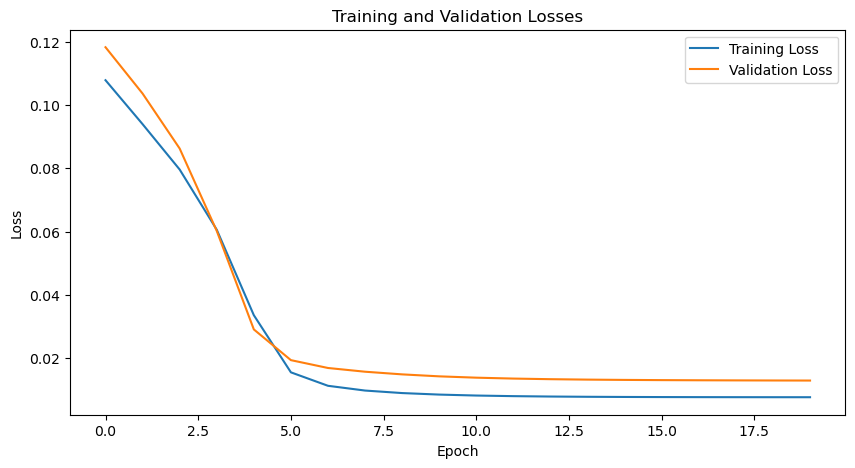

Epoch: 1 	Training Loss: 0.111015 	Validation Loss: 0.126215
Epoch: 2 	Training Loss: 0.103050 	Validation Loss: 0.118682
overwrite model
Epoch: 3 	Training Loss: 0.096608 	Validation Loss: 0.112261
overwrite model
Epoch: 4 	Training Loss: 0.090996 	Validation Loss: 0.106496
overwrite model
Epoch: 5 	Training Loss: 0.085898 	Validation Loss: 0.101135
overwrite model
Epoch: 6 	Training Loss: 0.081072 	Validation Loss: 0.095879
overwrite model
Epoch: 7 	Training Loss: 0.076198 	Validation Loss: 0.090320
overwrite model
Epoch: 8 	Training Loss: 0.070823 	Validation Loss: 0.083829
overwrite model
Epoch: 9 	Training Loss: 0.064223 	Validation Loss: 0.075343
overwrite model
Epoch: 10 	Training Loss: 0.055193 	Validation Loss: 0.063143
overwrite model
Epoch: 11 	Training Loss: 0.042431 	Validation Loss: 0.046550
overwrite model
Epoch: 12 	Training Loss: 0.028285 	Validation Loss: 0.032335
overwrite model
Epoch: 13 	Training Loss: 0.019541 	Validation Loss: 0.025862
overwrite model
Epoch: 14 	

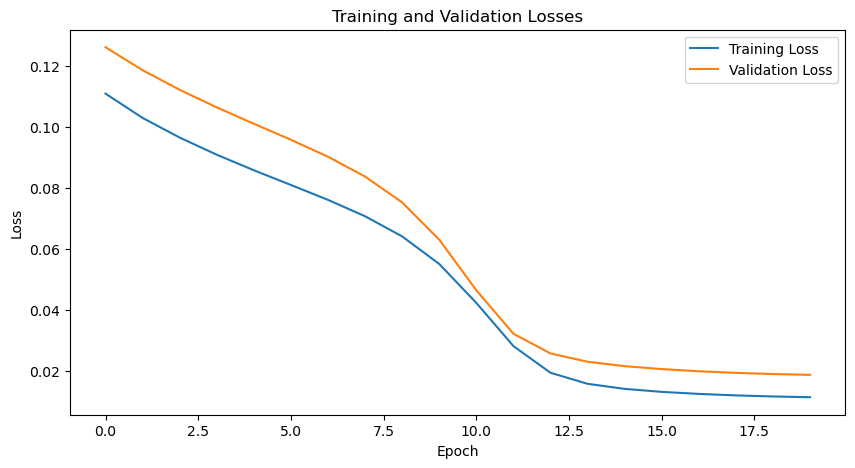

Epoch: 1 	Training Loss: 0.123164 	Validation Loss: 0.060981
Epoch: 2 	Training Loss: 0.023163 	Validation Loss: 0.006554
overwrite model
Epoch: 3 	Training Loss: 0.005185 	Validation Loss: 0.005837
overwrite model
Epoch: 4 	Training Loss: 0.004395 	Validation Loss: 0.005633
overwrite model
Epoch: 5 	Training Loss: 0.004079 	Validation Loss: 0.005571
overwrite model
Epoch: 6 	Training Loss: 0.003909 	Validation Loss: 0.005540
overwrite model
Epoch: 7 	Training Loss: 0.003806 	Validation Loss: 0.005503
overwrite model
Epoch: 8 	Training Loss: 0.003738 	Validation Loss: 0.005456
overwrite model
Epoch: 9 	Training Loss: 0.003690 	Validation Loss: 0.005409
overwrite model
Epoch: 10 	Training Loss: 0.003656 	Validation Loss: 0.005371
overwrite model
Epoch: 11 	Training Loss: 0.003634 	Validation Loss: 0.005344
overwrite model
Epoch: 12 	Training Loss: 0.003622 	Validation Loss: 0.005327
overwrite model
Epoch: 13 	Training Loss: 0.003616 	Validation Loss: 0.005317
overwrite model
Epoch: 14 	

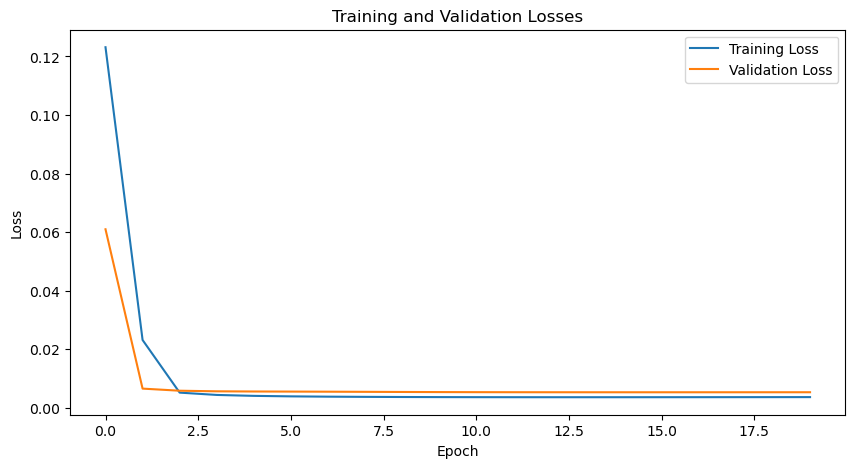

Epoch: 1 	Training Loss: 0.141909 	Validation Loss: 0.105350
Epoch: 2 	Training Loss: 0.077831 	Validation Loss: 0.024989
overwrite model
Epoch: 3 	Training Loss: 0.011872 	Validation Loss: 0.008272
overwrite model
Epoch: 4 	Training Loss: 0.006616 	Validation Loss: 0.007301
overwrite model
Epoch: 5 	Training Loss: 0.005595 	Validation Loss: 0.006964
overwrite model
Epoch: 6 	Training Loss: 0.005096 	Validation Loss: 0.006743
overwrite model
Epoch: 7 	Training Loss: 0.004800 	Validation Loss: 0.006520
overwrite model
Epoch: 8 	Training Loss: 0.004608 	Validation Loss: 0.006333
overwrite model
Epoch: 9 	Training Loss: 0.004484 	Validation Loss: 0.006217
overwrite model
Epoch: 10 	Training Loss: 0.004406 	Validation Loss: 0.006156
overwrite model
Epoch: 11 	Training Loss: 0.004357 	Validation Loss: 0.006126
overwrite model
Epoch: 12 	Training Loss: 0.004325 	Validation Loss: 0.006112
overwrite model
Epoch: 13 	Training Loss: 0.004302 	Validation Loss: 0.006103
overwrite model
Epoch: 14 	

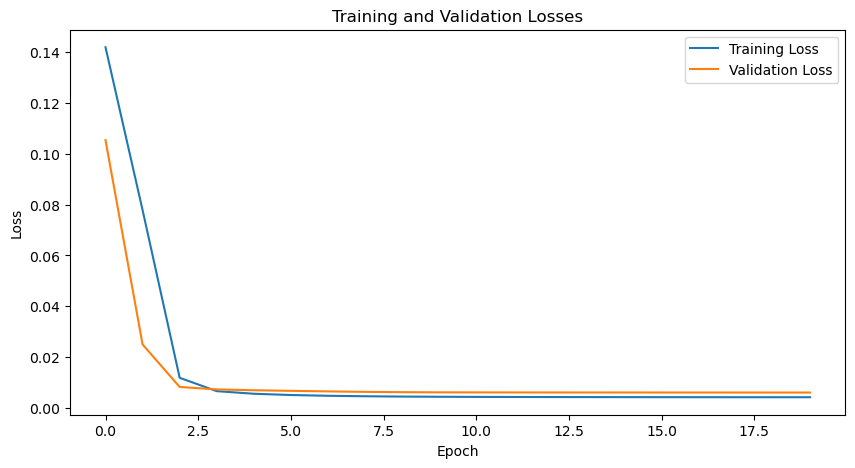

Epoch: 1 	Training Loss: 0.157989 	Validation Loss: 0.129792
Epoch: 2 	Training Loss: 0.124209 	Validation Loss: 0.089184
overwrite model
Epoch: 3 	Training Loss: 0.055628 	Validation Loss: 0.017216
overwrite model
Epoch: 4 	Training Loss: 0.012681 	Validation Loss: 0.010812
overwrite model
Epoch: 5 	Training Loss: 0.008935 	Validation Loss: 0.009524
overwrite model
Epoch: 6 	Training Loss: 0.007618 	Validation Loss: 0.008988
overwrite model
Epoch: 7 	Training Loss: 0.006938 	Validation Loss: 0.008686
overwrite model
Epoch: 8 	Training Loss: 0.006542 	Validation Loss: 0.008460
overwrite model
Epoch: 9 	Training Loss: 0.006291 	Validation Loss: 0.008275
overwrite model
Epoch: 10 	Training Loss: 0.006127 	Validation Loss: 0.008135
overwrite model
Epoch: 11 	Training Loss: 0.006030 	Validation Loss: 0.008048
overwrite model
Epoch: 12 	Training Loss: 0.005980 	Validation Loss: 0.008000
overwrite model
Epoch: 13 	Training Loss: 0.005956 	Validation Loss: 0.007972
overwrite model
Epoch: 14 	

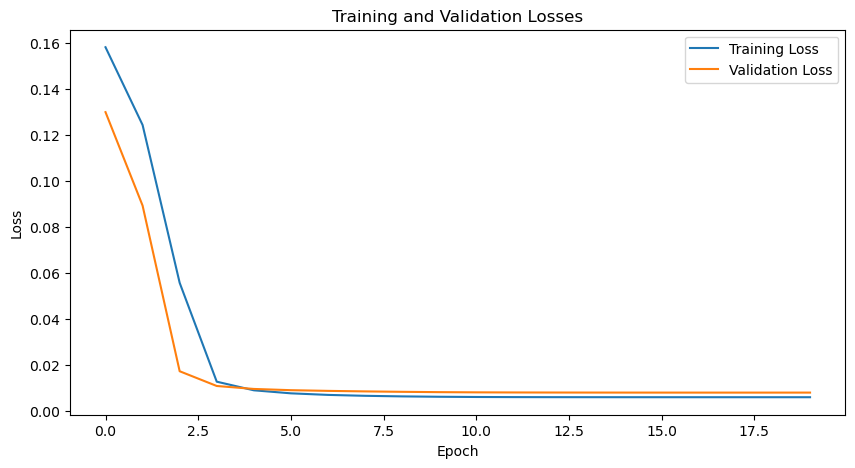

Epoch: 1 	Training Loss: 0.146689 	Validation Loss: 0.124430
Epoch: 2 	Training Loss: 0.130422 	Validation Loss: 0.110527
overwrite model
Epoch: 3 	Training Loss: 0.114746 	Validation Loss: 0.093779
overwrite model
Epoch: 4 	Training Loss: 0.089169 	Validation Loss: 0.057679
overwrite model
Epoch: 5 	Training Loss: 0.038234 	Validation Loss: 0.017956
overwrite model
Epoch: 6 	Training Loss: 0.016479 	Validation Loss: 0.012914
overwrite model
Epoch: 7 	Training Loss: 0.012950 	Validation Loss: 0.011534
overwrite model
Epoch: 8 	Training Loss: 0.011708 	Validation Loss: 0.010947
overwrite model
Epoch: 9 	Training Loss: 0.011127 	Validation Loss: 0.010650
overwrite model
Epoch: 10 	Training Loss: 0.010821 	Validation Loss: 0.010486
overwrite model
Epoch: 11 	Training Loss: 0.010651 	Validation Loss: 0.010391
overwrite model
Epoch: 12 	Training Loss: 0.010553 	Validation Loss: 0.010334
overwrite model
Epoch: 13 	Training Loss: 0.010495 	Validation Loss: 0.010299
overwrite model
Epoch: 14 	

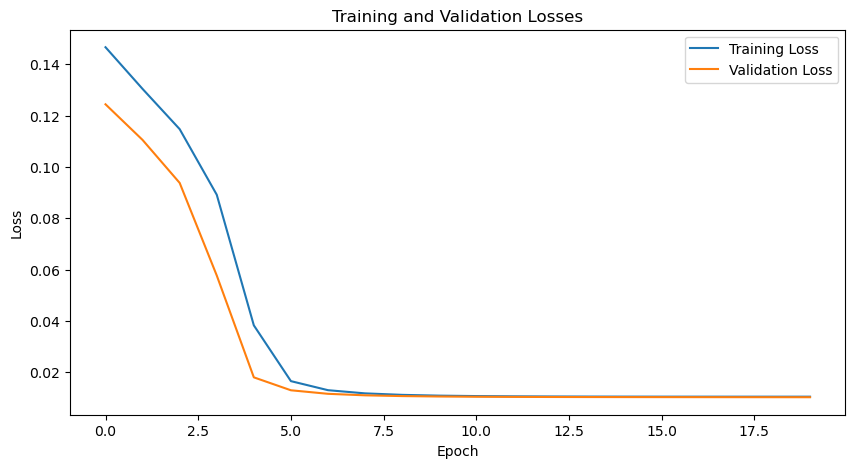

Epoch: 1 	Training Loss: 0.153285 	Validation Loss: 0.024476
Epoch: 2 	Training Loss: 0.028064 	Validation Loss: 0.014504
overwrite model
Epoch: 3 	Training Loss: 0.003884 	Validation Loss: 0.017021
Epoch: 4 	Training Loss: 0.003084 	Validation Loss: 0.018508
Epoch: 5 	Training Loss: 0.002778 	Validation Loss: 0.019652
Epoch: 6 	Training Loss: 0.002600 	Validation Loss: 0.020649
Epoch: 7 	Training Loss: 0.002485 	Validation Loss: 0.021353
Epoch: 8 	Training Loss: 0.002416 	Validation Loss: 0.021634
Epoch: 9 	Training Loss: 0.002375 	Validation Loss: 0.021772
Epoch: 10 	Training Loss: 0.002350 	Validation Loss: 0.021896
Epoch: 11 	Training Loss: 0.002335 	Validation Loss: 0.022019
Epoch: 12 	Training Loss: 0.002326 	Validation Loss: 0.022137
Epoch: 13 	Training Loss: 0.002321 	Validation Loss: 0.022243
Epoch: 14 	Training Loss: 0.002319 	Validation Loss: 0.022326
Epoch: 15 	Training Loss: 0.002319 	Validation Loss: 0.022385
Epoch: 16 	Training Loss: 0.002321 	Validation Loss: 0.022422
E

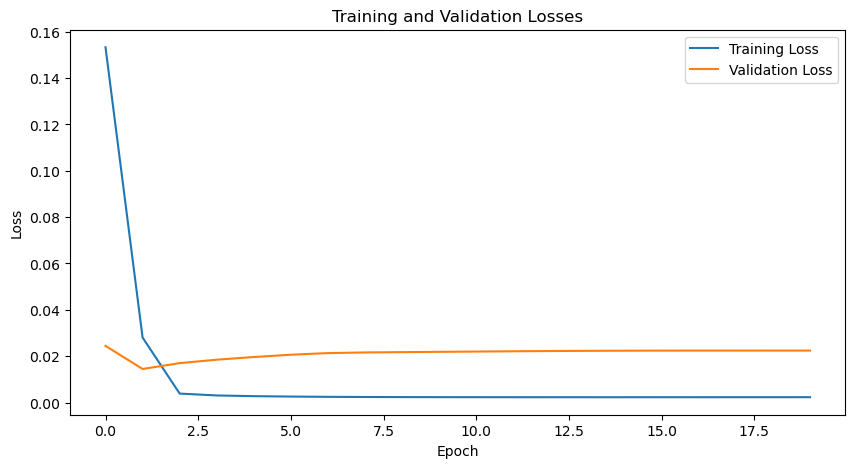

Epoch: 1 	Training Loss: 0.159847 	Validation Loss: 0.042740
Epoch: 2 	Training Loss: 0.070578 	Validation Loss: 0.007847
overwrite model
Epoch: 3 	Training Loss: 0.008990 	Validation Loss: 0.011728
Epoch: 4 	Training Loss: 0.005446 	Validation Loss: 0.014050
Epoch: 5 	Training Loss: 0.004368 	Validation Loss: 0.015758
Epoch: 6 	Training Loss: 0.003837 	Validation Loss: 0.016814
Epoch: 7 	Training Loss: 0.003555 	Validation Loss: 0.017328
Epoch: 8 	Training Loss: 0.003396 	Validation Loss: 0.017705
Epoch: 9 	Training Loss: 0.003304 	Validation Loss: 0.018002
Epoch: 10 	Training Loss: 0.003251 	Validation Loss: 0.018220
Epoch: 11 	Training Loss: 0.003220 	Validation Loss: 0.018375
Epoch: 12 	Training Loss: 0.003202 	Validation Loss: 0.018481
Epoch: 13 	Training Loss: 0.003191 	Validation Loss: 0.018549
Epoch: 14 	Training Loss: 0.003185 	Validation Loss: 0.018592
Epoch: 15 	Training Loss: 0.003181 	Validation Loss: 0.018616
Epoch: 16 	Training Loss: 0.003179 	Validation Loss: 0.018625
E

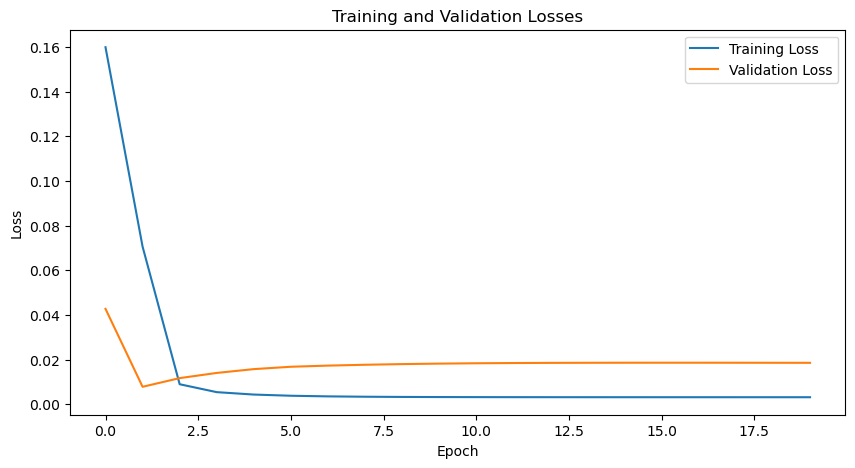

Epoch: 1 	Training Loss: 0.180546 	Validation Loss: 0.063755
Epoch: 2 	Training Loss: 0.148165 	Validation Loss: 0.044059
overwrite model
Epoch: 3 	Training Loss: 0.101469 	Validation Loss: 0.011683
overwrite model
Epoch: 4 	Training Loss: 0.029859 	Validation Loss: 0.006096
overwrite model
Epoch: 5 	Training Loss: 0.010457 	Validation Loss: 0.009025
Epoch: 6 	Training Loss: 0.007601 	Validation Loss: 0.010767
Epoch: 7 	Training Loss: 0.006391 	Validation Loss: 0.011935
Epoch: 8 	Training Loss: 0.005767 	Validation Loss: 0.012574
Epoch: 9 	Training Loss: 0.005471 	Validation Loss: 0.012883
Epoch: 10 	Training Loss: 0.005333 	Validation Loss: 0.013037
Epoch: 11 	Training Loss: 0.005265 	Validation Loss: 0.013120
Epoch: 12 	Training Loss: 0.005229 	Validation Loss: 0.013172
Epoch: 13 	Training Loss: 0.005210 	Validation Loss: 0.013208
Epoch: 14 	Training Loss: 0.005198 	Validation Loss: 0.013234
Epoch: 15 	Training Loss: 0.005192 	Validation Loss: 0.013257
Epoch: 16 	Training Loss: 0.005

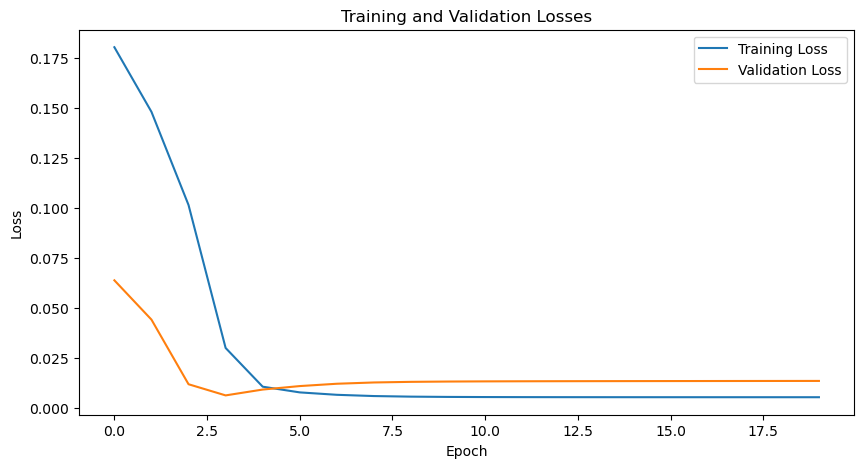

Epoch: 1 	Training Loss: 0.186671 	Validation Loss: 0.071442
Epoch: 2 	Training Loss: 0.168828 	Validation Loss: 0.060817
overwrite model
Epoch: 3 	Training Loss: 0.152424 	Validation Loss: 0.050426
overwrite model
Epoch: 4 	Training Loss: 0.131368 	Validation Loss: 0.034110
overwrite model
Epoch: 5 	Training Loss: 0.080367 	Validation Loss: 0.004836
overwrite model
Epoch: 6 	Training Loss: 0.023816 	Validation Loss: 0.004733
overwrite model
Epoch: 7 	Training Loss: 0.014472 	Validation Loss: 0.005918
Epoch: 8 	Training Loss: 0.012362 	Validation Loss: 0.006608
Epoch: 9 	Training Loss: 0.011361 	Validation Loss: 0.007034
Epoch: 10 	Training Loss: 0.010838 	Validation Loss: 0.007260
Epoch: 11 	Training Loss: 0.010592 	Validation Loss: 0.007364
Epoch: 12 	Training Loss: 0.010478 	Validation Loss: 0.007415
Epoch: 13 	Training Loss: 0.010421 	Validation Loss: 0.007441
Epoch: 14 	Training Loss: 0.010390 	Validation Loss: 0.007455
Epoch: 15 	Training Loss: 0.010373 	Validation Loss: 0.007463

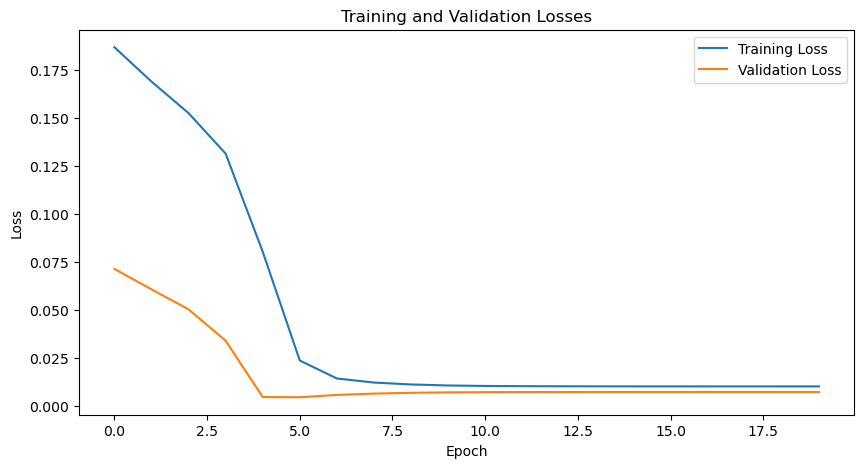

Epoch: 1 	Training Loss: 0.137768 	Validation Loss: 0.014403
Epoch: 2 	Training Loss: 0.011808 	Validation Loss: 0.007462
overwrite model
Epoch: 3 	Training Loss: 0.004267 	Validation Loss: 0.009305
Epoch: 4 	Training Loss: 0.003843 	Validation Loss: 0.009925
Epoch: 5 	Training Loss: 0.003629 	Validation Loss: 0.010283
Epoch: 6 	Training Loss: 0.003500 	Validation Loss: 0.010706
Epoch: 7 	Training Loss: 0.003409 	Validation Loss: 0.011212
Epoch: 8 	Training Loss: 0.003344 	Validation Loss: 0.011690
Epoch: 9 	Training Loss: 0.003303 	Validation Loss: 0.012023
Epoch: 10 	Training Loss: 0.003276 	Validation Loss: 0.012285
Epoch: 11 	Training Loss: 0.003259 	Validation Loss: 0.012504
Epoch: 12 	Training Loss: 0.003247 	Validation Loss: 0.012684
Epoch: 13 	Training Loss: 0.003240 	Validation Loss: 0.012826
Epoch: 14 	Training Loss: 0.003235 	Validation Loss: 0.012918
Epoch: 15 	Training Loss: 0.003232 	Validation Loss: 0.012965
Epoch: 16 	Training Loss: 0.003231 	Validation Loss: 0.012968
E

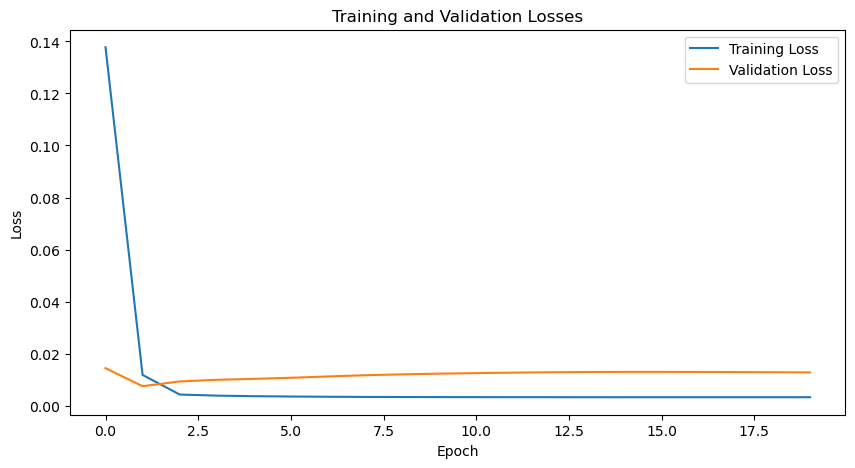

Epoch: 1 	Training Loss: 0.197184 	Validation Loss: 0.080935
Epoch: 2 	Training Loss: 0.111307 	Validation Loss: 0.007014
overwrite model
Epoch: 3 	Training Loss: 0.010957 	Validation Loss: 0.005456
overwrite model
Epoch: 4 	Training Loss: 0.006115 	Validation Loss: 0.006595
Epoch: 5 	Training Loss: 0.005230 	Validation Loss: 0.007222
Epoch: 6 	Training Loss: 0.004832 	Validation Loss: 0.007769
Epoch: 7 	Training Loss: 0.004600 	Validation Loss: 0.008272
Epoch: 8 	Training Loss: 0.004452 	Validation Loss: 0.008681
Epoch: 9 	Training Loss: 0.004350 	Validation Loss: 0.009001
Epoch: 10 	Training Loss: 0.004278 	Validation Loss: 0.009255
Epoch: 11 	Training Loss: 0.004226 	Validation Loss: 0.009449
Epoch: 12 	Training Loss: 0.004190 	Validation Loss: 0.009578
Epoch: 13 	Training Loss: 0.004168 	Validation Loss: 0.009642
Epoch: 14 	Training Loss: 0.004156 	Validation Loss: 0.009660
Epoch: 15 	Training Loss: 0.004151 	Validation Loss: 0.009652
Epoch: 16 	Training Loss: 0.004147 	Validation 

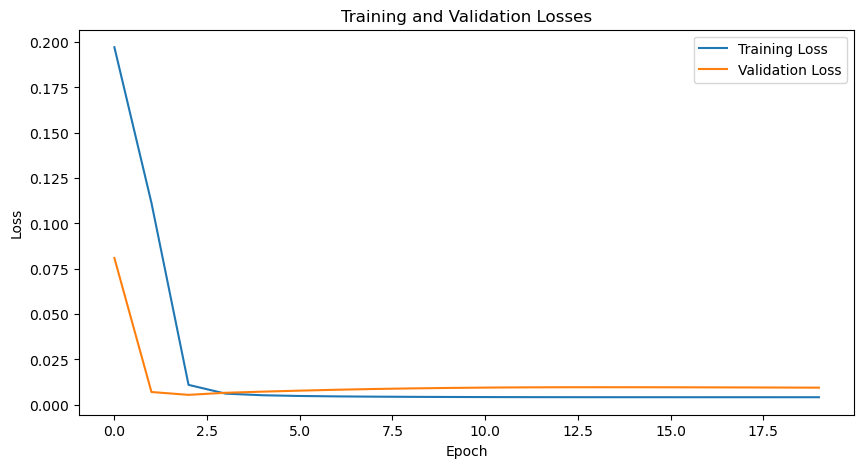

Epoch: 1 	Training Loss: 0.195904 	Validation Loss: 0.087007
Epoch: 2 	Training Loss: 0.152237 	Validation Loss: 0.048226
overwrite model
Epoch: 3 	Training Loss: 0.062783 	Validation Loss: 0.002793
overwrite model
Epoch: 4 	Training Loss: 0.012210 	Validation Loss: 0.003410
Epoch: 5 	Training Loss: 0.008743 	Validation Loss: 0.004172
Epoch: 6 	Training Loss: 0.007571 	Validation Loss: 0.004644
Epoch: 7 	Training Loss: 0.007005 	Validation Loss: 0.004983
Epoch: 8 	Training Loss: 0.006693 	Validation Loss: 0.005239
Epoch: 9 	Training Loss: 0.006512 	Validation Loss: 0.005431
Epoch: 10 	Training Loss: 0.006404 	Validation Loss: 0.005569
Epoch: 11 	Training Loss: 0.006339 	Validation Loss: 0.005669
Epoch: 12 	Training Loss: 0.006300 	Validation Loss: 0.005744
Epoch: 13 	Training Loss: 0.006276 	Validation Loss: 0.005801
Epoch: 14 	Training Loss: 0.006261 	Validation Loss: 0.005848
Epoch: 15 	Training Loss: 0.006252 	Validation Loss: 0.005886
Epoch: 16 	Training Loss: 0.006247 	Validation 

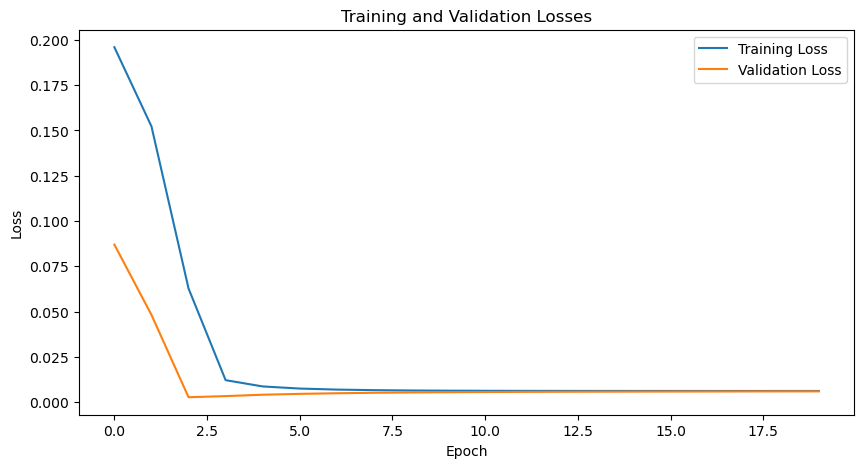

Epoch: 1 	Training Loss: 0.206273 	Validation Loss: 0.098509
Epoch: 2 	Training Loss: 0.183047 	Validation Loss: 0.082610
overwrite model
Epoch: 3 	Training Loss: 0.157511 	Validation Loss: 0.060001
overwrite model
Epoch: 4 	Training Loss: 0.101362 	Validation Loss: 0.012852
overwrite model
Epoch: 5 	Training Loss: 0.030423 	Validation Loss: 0.001972
overwrite model
Epoch: 6 	Training Loss: 0.016480 	Validation Loss: 0.002057
Epoch: 7 	Training Loss: 0.014013 	Validation Loss: 0.002249
Epoch: 8 	Training Loss: 0.013004 	Validation Loss: 0.002374
Epoch: 9 	Training Loss: 0.012510 	Validation Loss: 0.002449
Epoch: 10 	Training Loss: 0.012236 	Validation Loss: 0.002495
Epoch: 11 	Training Loss: 0.012075 	Validation Loss: 0.002523
Epoch: 12 	Training Loss: 0.011977 	Validation Loss: 0.002540
Epoch: 13 	Training Loss: 0.011917 	Validation Loss: 0.002551
Epoch: 14 	Training Loss: 0.011880 	Validation Loss: 0.002558
Epoch: 15 	Training Loss: 0.011856 	Validation Loss: 0.002563
Epoch: 16 	Trai

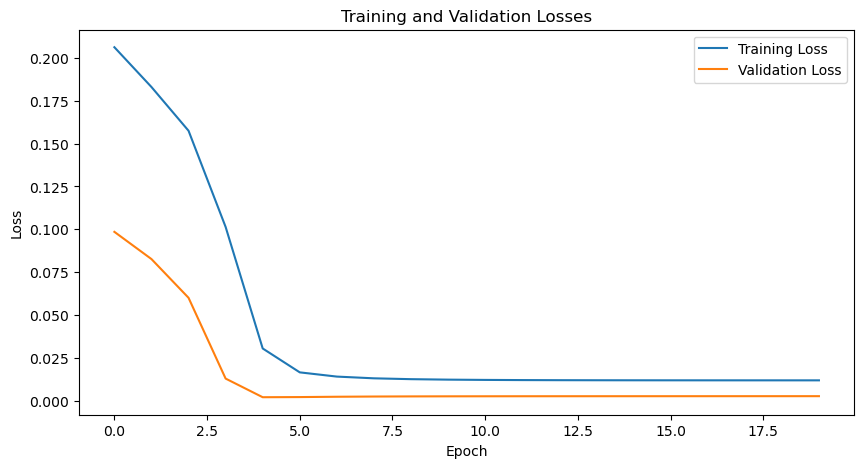

Epoch: 1 	Training Loss: 0.110753 	Validation Loss: 0.077455
Epoch: 2 	Training Loss: 0.055737 	Validation Loss: 0.018845
overwrite model
Epoch: 3 	Training Loss: 0.008862 	Validation Loss: 0.002963
overwrite model
Epoch: 4 	Training Loss: 0.004018 	Validation Loss: 0.002420
overwrite model
Epoch: 5 	Training Loss: 0.003476 	Validation Loss: 0.002286
overwrite model
Epoch: 6 	Training Loss: 0.003240 	Validation Loss: 0.002190
overwrite model
Epoch: 7 	Training Loss: 0.003078 	Validation Loss: 0.002123
overwrite model
Epoch: 8 	Training Loss: 0.002965 	Validation Loss: 0.002072
overwrite model
Epoch: 9 	Training Loss: 0.002879 	Validation Loss: 0.002039
overwrite model
Epoch: 10 	Training Loss: 0.002818 	Validation Loss: 0.002007
overwrite model
Epoch: 11 	Training Loss: 0.002771 	Validation Loss: 0.001983
overwrite model
Epoch: 12 	Training Loss: 0.002738 	Validation Loss: 0.001963
overwrite model
Epoch: 13 	Training Loss: 0.002714 	Validation Loss: 0.001948
overwrite model
Epoch: 14 	

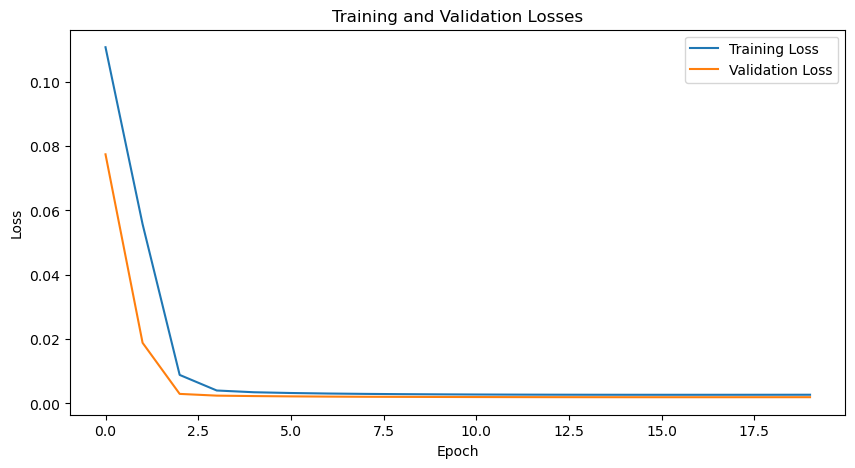

Epoch: 1 	Training Loss: 0.115749 	Validation Loss: 0.094857
Epoch: 2 	Training Loss: 0.090195 	Validation Loss: 0.066599
overwrite model
Epoch: 3 	Training Loss: 0.053587 	Validation Loss: 0.025740
overwrite model
Epoch: 4 	Training Loss: 0.016339 	Validation Loss: 0.006686
overwrite model
Epoch: 5 	Training Loss: 0.007623 	Validation Loss: 0.004761
overwrite model
Epoch: 6 	Training Loss: 0.005880 	Validation Loss: 0.003840
overwrite model
Epoch: 7 	Training Loss: 0.004973 	Validation Loss: 0.003341
overwrite model
Epoch: 8 	Training Loss: 0.004436 	Validation Loss: 0.003009
overwrite model
Epoch: 9 	Training Loss: 0.004083 	Validation Loss: 0.002778
overwrite model
Epoch: 10 	Training Loss: 0.003842 	Validation Loss: 0.002621
overwrite model
Epoch: 11 	Training Loss: 0.003673 	Validation Loss: 0.002509
overwrite model
Epoch: 12 	Training Loss: 0.003552 	Validation Loss: 0.002430
overwrite model
Epoch: 13 	Training Loss: 0.003464 	Validation Loss: 0.002372
overwrite model
Epoch: 14 	

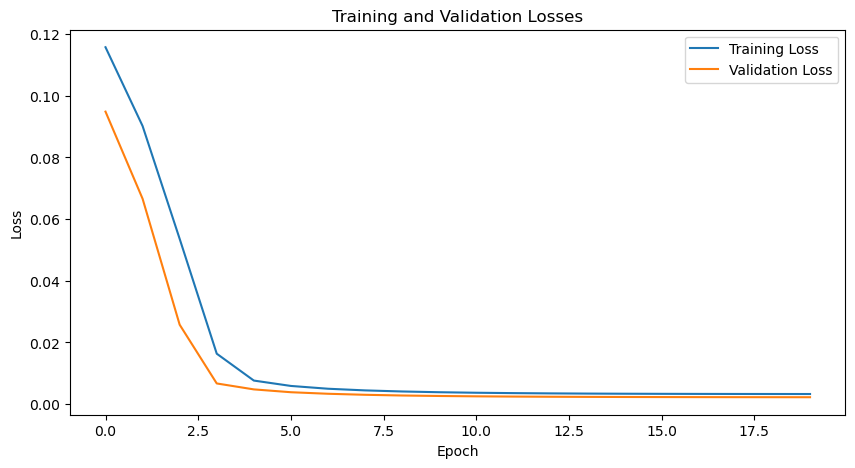

Epoch: 1 	Training Loss: 0.106787 	Validation Loss: 0.092116
Epoch: 2 	Training Loss: 0.094904 	Validation Loss: 0.081377
overwrite model
Epoch: 3 	Training Loss: 0.083422 	Validation Loss: 0.069858
overwrite model
Epoch: 4 	Training Loss: 0.070210 	Validation Loss: 0.055717
overwrite model
Epoch: 5 	Training Loss: 0.052738 	Validation Loss: 0.036355
overwrite model
Epoch: 6 	Training Loss: 0.030710 	Validation Loss: 0.017186
overwrite model
Epoch: 7 	Training Loss: 0.015629 	Validation Loss: 0.009586
overwrite model
Epoch: 8 	Training Loss: 0.010369 	Validation Loss: 0.007029
overwrite model
Epoch: 9 	Training Loss: 0.008174 	Validation Loss: 0.005766
overwrite model
Epoch: 10 	Training Loss: 0.006972 	Validation Loss: 0.005025
overwrite model
Epoch: 11 	Training Loss: 0.006232 	Validation Loss: 0.004547
overwrite model
Epoch: 12 	Training Loss: 0.005748 	Validation Loss: 0.004228
overwrite model
Epoch: 13 	Training Loss: 0.005418 	Validation Loss: 0.004010
overwrite model
Epoch: 14 	

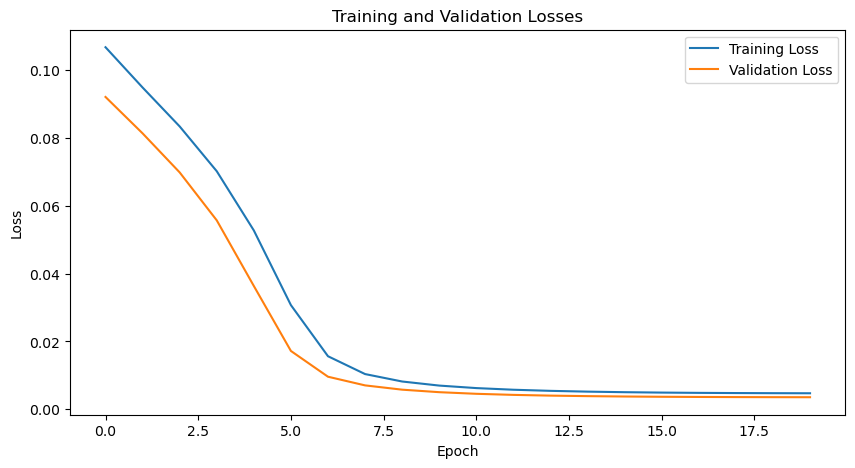

Epoch: 1 	Training Loss: 0.117401 	Validation Loss: 0.103355
Epoch: 2 	Training Loss: 0.109950 	Validation Loss: 0.097012
overwrite model
Epoch: 3 	Training Loss: 0.103887 	Validation Loss: 0.091609
overwrite model
Epoch: 4 	Training Loss: 0.098560 	Validation Loss: 0.086778
overwrite model
Epoch: 5 	Training Loss: 0.093719 	Validation Loss: 0.082327
overwrite model
Epoch: 6 	Training Loss: 0.089161 	Validation Loss: 0.078060
overwrite model
Epoch: 7 	Training Loss: 0.084695 	Validation Loss: 0.073783
overwrite model
Epoch: 8 	Training Loss: 0.080084 	Validation Loss: 0.069240
overwrite model
Epoch: 9 	Training Loss: 0.074990 	Validation Loss: 0.064010
overwrite model
Epoch: 10 	Training Loss: 0.068805 	Validation Loss: 0.057316
overwrite model
Epoch: 11 	Training Loss: 0.060388 	Validation Loss: 0.047781
overwrite model
Epoch: 12 	Training Loss: 0.048251 	Validation Loss: 0.034644
overwrite model
Epoch: 13 	Training Loss: 0.033757 	Validation Loss: 0.022307
overwrite model
Epoch: 14 	

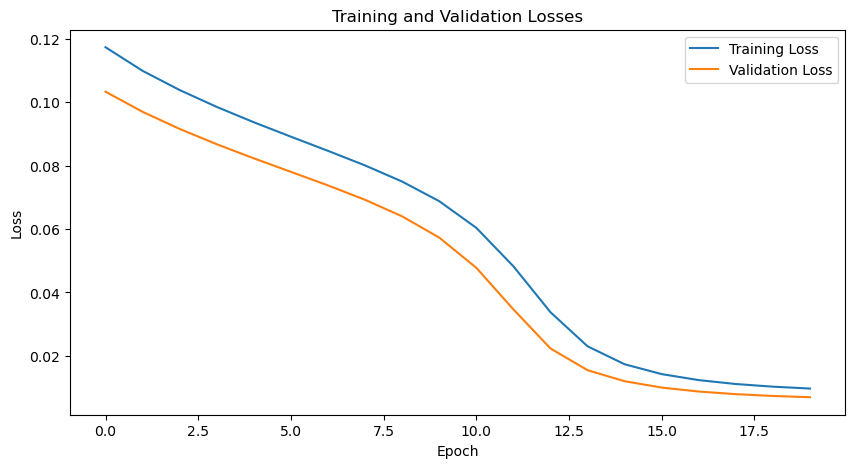

Epoch: 1 	Training Loss: 0.070682 	Validation Loss: 0.013314
Epoch: 2 	Training Loss: 0.023938 	Validation Loss: 0.002718
overwrite model
Epoch: 3 	Training Loss: 0.010456 	Validation Loss: 0.003615
Epoch: 4 	Training Loss: 0.009292 	Validation Loss: 0.004198
Epoch: 5 	Training Loss: 0.008878 	Validation Loss: 0.004525
Epoch: 6 	Training Loss: 0.008675 	Validation Loss: 0.004714
Epoch: 7 	Training Loss: 0.008565 	Validation Loss: 0.004814
Epoch: 8 	Training Loss: 0.008506 	Validation Loss: 0.004860
Epoch: 9 	Training Loss: 0.008478 	Validation Loss: 0.004873
Epoch: 10 	Training Loss: 0.008467 	Validation Loss: 0.004864
Epoch: 11 	Training Loss: 0.008469 	Validation Loss: 0.004842
Epoch: 12 	Training Loss: 0.008478 	Validation Loss: 0.004813
Epoch: 13 	Training Loss: 0.008491 	Validation Loss: 0.004780
Epoch: 14 	Training Loss: 0.008508 	Validation Loss: 0.004745
Epoch: 15 	Training Loss: 0.008526 	Validation Loss: 0.004709
Epoch: 16 	Training Loss: 0.008546 	Validation Loss: 0.004673
E

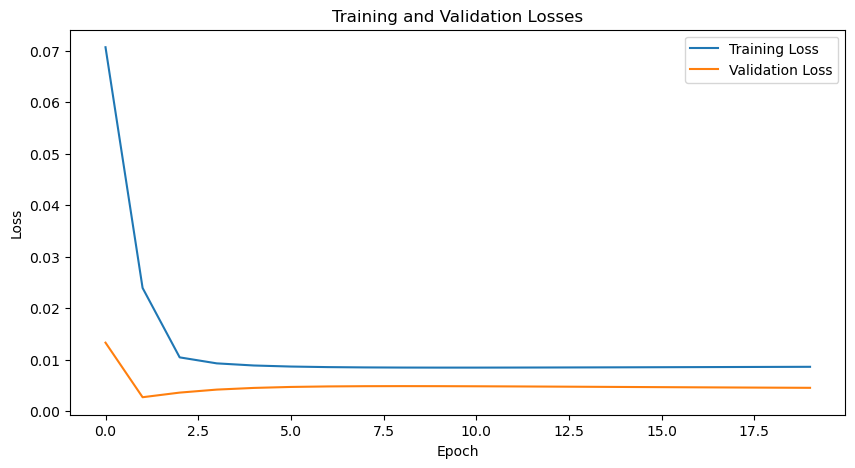

Epoch: 1 	Training Loss: 0.095116 	Validation Loss: 0.033972
Epoch: 2 	Training Loss: 0.065339 	Validation Loss: 0.013189
overwrite model
Epoch: 3 	Training Loss: 0.027597 	Validation Loss: 0.001825
overwrite model
Epoch: 4 	Training Loss: 0.013229 	Validation Loss: 0.002251
Epoch: 5 	Training Loss: 0.011077 	Validation Loss: 0.002833
Epoch: 6 	Training Loss: 0.010225 	Validation Loss: 0.003234
Epoch: 7 	Training Loss: 0.009792 	Validation Loss: 0.003499
Epoch: 8 	Training Loss: 0.009545 	Validation Loss: 0.003686
Epoch: 9 	Training Loss: 0.009392 	Validation Loss: 0.003829
Epoch: 10 	Training Loss: 0.009290 	Validation Loss: 0.003947
Epoch: 11 	Training Loss: 0.009217 	Validation Loss: 0.004046
Epoch: 12 	Training Loss: 0.009165 	Validation Loss: 0.004129
Epoch: 13 	Training Loss: 0.009125 	Validation Loss: 0.004196
Epoch: 14 	Training Loss: 0.009096 	Validation Loss: 0.004247
Epoch: 15 	Training Loss: 0.009076 	Validation Loss: 0.004285
Epoch: 16 	Training Loss: 0.009063 	Validation 

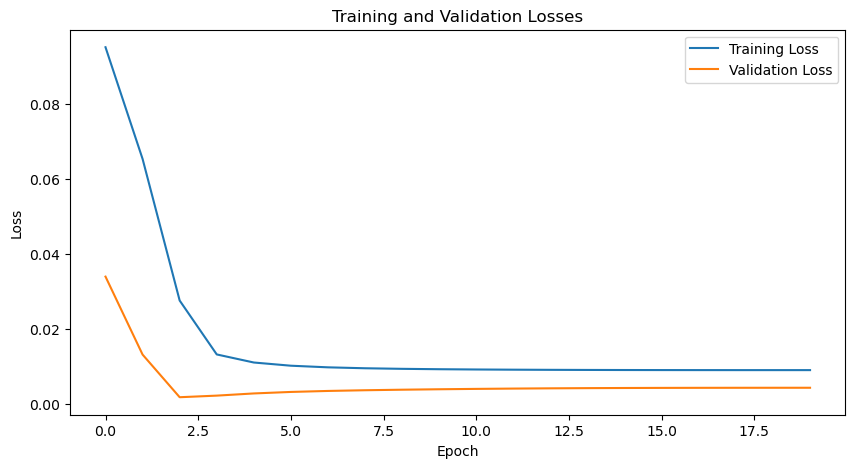

Epoch: 1 	Training Loss: 0.107148 	Validation Loss: 0.044092
Epoch: 2 	Training Loss: 0.089521 	Validation Loss: 0.033020
overwrite model
Epoch: 3 	Training Loss: 0.073150 	Validation Loss: 0.021582
overwrite model
Epoch: 4 	Training Loss: 0.051895 	Validation Loss: 0.007566
overwrite model
Epoch: 5 	Training Loss: 0.026995 	Validation Loss: 0.001325
overwrite model
Epoch: 6 	Training Loss: 0.016593 	Validation Loss: 0.001231
overwrite model
Epoch: 7 	Training Loss: 0.013602 	Validation Loss: 0.001637
Epoch: 8 	Training Loss: 0.012246 	Validation Loss: 0.002029
Epoch: 9 	Training Loss: 0.011487 	Validation Loss: 0.002369
Epoch: 10 	Training Loss: 0.011016 	Validation Loss: 0.002652
Epoch: 11 	Training Loss: 0.010719 	Validation Loss: 0.002855
Epoch: 12 	Training Loss: 0.010545 	Validation Loss: 0.002977
Epoch: 13 	Training Loss: 0.010449 	Validation Loss: 0.003044
Epoch: 14 	Training Loss: 0.010400 	Validation Loss: 0.003078
Epoch: 15 	Training Loss: 0.010376 	Validation Loss: 0.003096

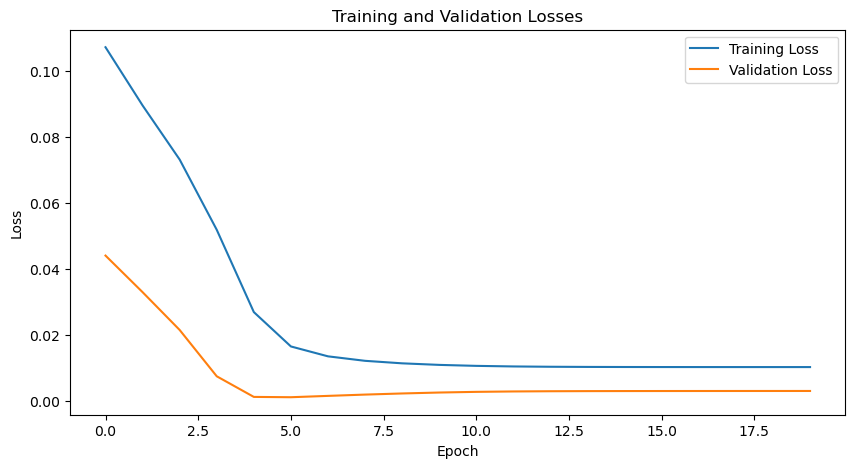

Epoch: 1 	Training Loss: 0.111900 	Validation Loss: 0.048710
Epoch: 2 	Training Loss: 0.100008 	Validation Loss: 0.041226
overwrite model
Epoch: 3 	Training Loss: 0.090709 	Validation Loss: 0.035140
overwrite model
Epoch: 4 	Training Loss: 0.082390 	Validation Loss: 0.029617
overwrite model
Epoch: 5 	Training Loss: 0.073911 	Validation Loss: 0.023825
overwrite model
Epoch: 6 	Training Loss: 0.063486 	Validation Loss: 0.016465
overwrite model
Epoch: 7 	Training Loss: 0.047870 	Validation Loss: 0.006802
overwrite model
Epoch: 8 	Training Loss: 0.029030 	Validation Loss: 0.001695
overwrite model
Epoch: 9 	Training Loss: 0.019593 	Validation Loss: 0.001105
overwrite model
Epoch: 10 	Training Loss: 0.016471 	Validation Loss: 0.001164
Epoch: 11 	Training Loss: 0.015158 	Validation Loss: 0.001273
Epoch: 12 	Training Loss: 0.014528 	Validation Loss: 0.001351
Epoch: 13 	Training Loss: 0.014198 	Validation Loss: 0.001400
Epoch: 14 	Training Loss: 0.014029 	Validation Loss: 0.001426
Epoch: 15 	Tr

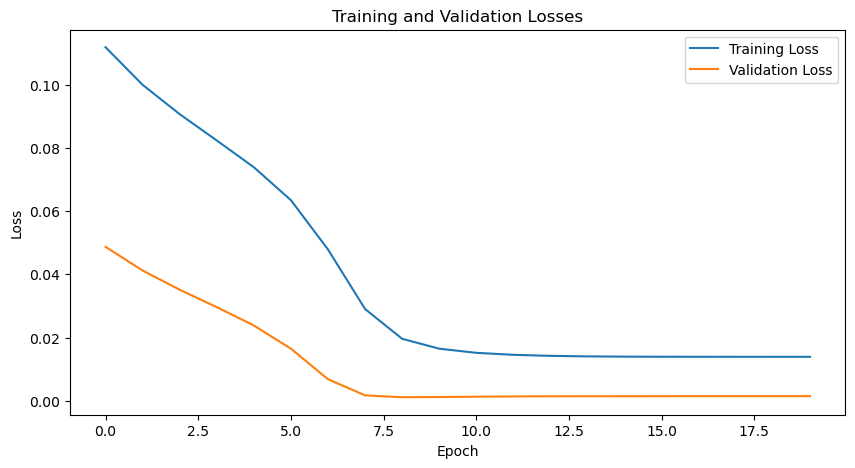

Epoch: 1 	Training Loss: 0.030970 	Validation Loss: 0.009561
Epoch: 2 	Training Loss: 0.014540 	Validation Loss: 0.002927
overwrite model
Epoch: 3 	Training Loss: 0.006848 	Validation Loss: 0.001501
overwrite model
Epoch: 4 	Training Loss: 0.004923 	Validation Loss: 0.001281
overwrite model
Epoch: 5 	Training Loss: 0.004326 	Validation Loss: 0.001198
overwrite model
Epoch: 6 	Training Loss: 0.004017 	Validation Loss: 0.001147
overwrite model
Epoch: 7 	Training Loss: 0.003831 	Validation Loss: 0.001109
overwrite model
Epoch: 8 	Training Loss: 0.003712 	Validation Loss: 0.001075
overwrite model
Epoch: 9 	Training Loss: 0.003625 	Validation Loss: 0.001045
overwrite model
Epoch: 10 	Training Loss: 0.003551 	Validation Loss: 0.001020
overwrite model
Epoch: 11 	Training Loss: 0.003474 	Validation Loss: 0.001001
overwrite model
Epoch: 12 	Training Loss: 0.003389 	Validation Loss: 0.000992
overwrite model
Epoch: 13 	Training Loss: 0.003295 	Validation Loss: 0.000993
Epoch: 14 	Training Loss: 0

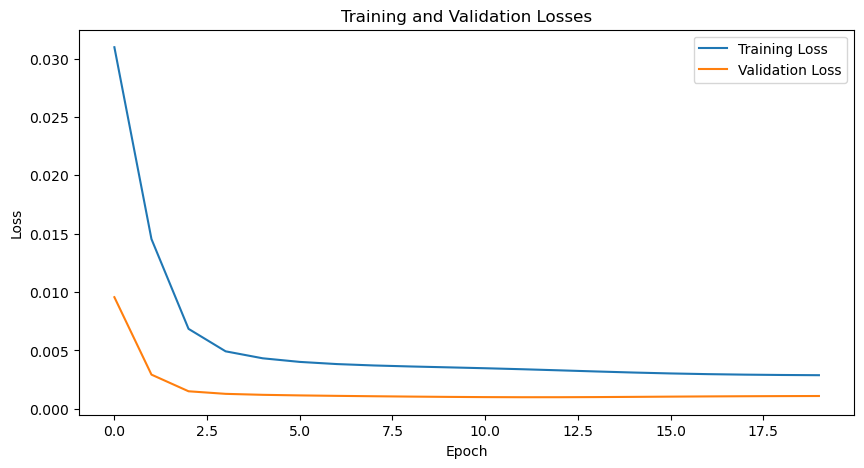

Epoch: 1 	Training Loss: 0.030860 	Validation Loss: 0.012049
Epoch: 2 	Training Loss: 0.022044 	Validation Loss: 0.007299
overwrite model
Epoch: 3 	Training Loss: 0.016598 	Validation Loss: 0.004613
overwrite model
Epoch: 4 	Training Loss: 0.013247 	Validation Loss: 0.003124
overwrite model
Epoch: 5 	Training Loss: 0.011230 	Validation Loss: 0.002292
overwrite model
Epoch: 6 	Training Loss: 0.010001 	Validation Loss: 0.001802
overwrite model
Epoch: 7 	Training Loss: 0.009219 	Validation Loss: 0.001496
overwrite model
Epoch: 8 	Training Loss: 0.008694 	Validation Loss: 0.001296
overwrite model
Epoch: 9 	Training Loss: 0.008323 	Validation Loss: 0.001162
overwrite model
Epoch: 10 	Training Loss: 0.008053 	Validation Loss: 0.001072
overwrite model
Epoch: 11 	Training Loss: 0.007854 	Validation Loss: 0.001013
overwrite model
Epoch: 12 	Training Loss: 0.007711 	Validation Loss: 0.000974
overwrite model
Epoch: 13 	Training Loss: 0.007610 	Validation Loss: 0.000949
overwrite model
Epoch: 14 	

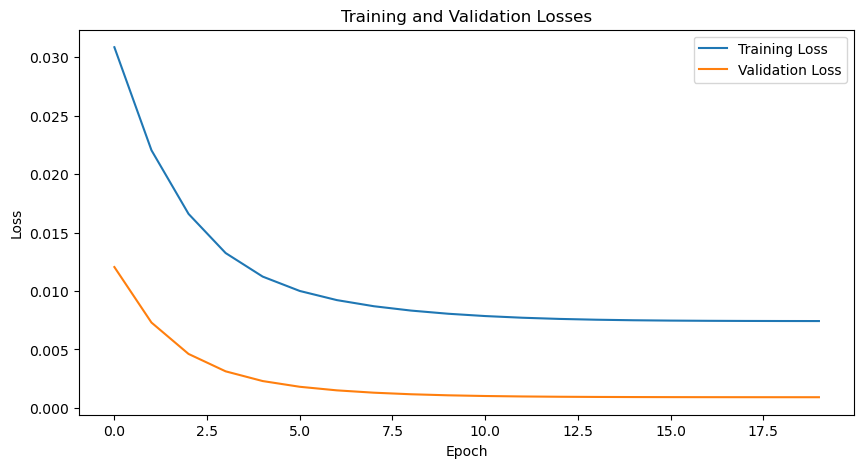

Epoch: 1 	Training Loss: 0.034550 	Validation Loss: 0.014674
Epoch: 2 	Training Loss: 0.027075 	Validation Loss: 0.010371
overwrite model
Epoch: 3 	Training Loss: 0.022349 	Validation Loss: 0.007660
overwrite model
Epoch: 4 	Training Loss: 0.019166 	Validation Loss: 0.005918
overwrite model
Epoch: 5 	Training Loss: 0.017001 	Validation Loss: 0.004796
overwrite model
Epoch: 6 	Training Loss: 0.015527 	Validation Loss: 0.004070
overwrite model
Epoch: 7 	Training Loss: 0.014520 	Validation Loss: 0.003599
overwrite model
Epoch: 8 	Training Loss: 0.013833 	Validation Loss: 0.003292
overwrite model
Epoch: 9 	Training Loss: 0.013366 	Validation Loss: 0.003093
overwrite model
Epoch: 10 	Training Loss: 0.013050 	Validation Loss: 0.002964
overwrite model
Epoch: 11 	Training Loss: 0.012839 	Validation Loss: 0.002881
overwrite model
Epoch: 12 	Training Loss: 0.012700 	Validation Loss: 0.002828
overwrite model
Epoch: 13 	Training Loss: 0.012610 	Validation Loss: 0.002795
overwrite model
Epoch: 14 	

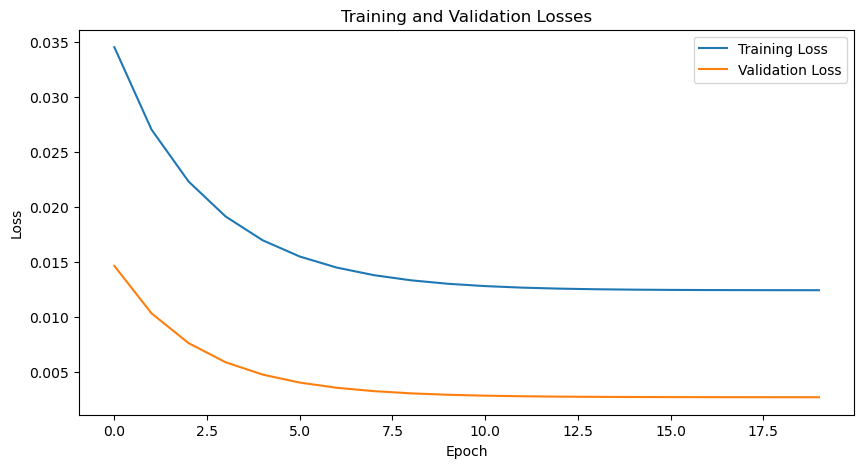

Epoch: 1 	Training Loss: 0.034819 	Validation Loss: 0.015332
Epoch: 2 	Training Loss: 0.029149 	Validation Loss: 0.011798
overwrite model
Epoch: 3 	Training Loss: 0.025668 	Validation Loss: 0.009594
overwrite model
Epoch: 4 	Training Loss: 0.023315 	Validation Loss: 0.008152
overwrite model
Epoch: 5 	Training Loss: 0.021675 	Validation Loss: 0.007189
overwrite model
Epoch: 6 	Training Loss: 0.020512 	Validation Loss: 0.006534
overwrite model
Epoch: 7 	Training Loss: 0.019680 	Validation Loss: 0.006086
overwrite model
Epoch: 8 	Training Loss: 0.019083 	Validation Loss: 0.005778
overwrite model
Epoch: 9 	Training Loss: 0.018660 	Validation Loss: 0.005568
overwrite model
Epoch: 10 	Training Loss: 0.018364 	Validation Loss: 0.005426
overwrite model
Epoch: 11 	Training Loss: 0.018160 	Validation Loss: 0.005331
overwrite model
Epoch: 12 	Training Loss: 0.018023 	Validation Loss: 0.005269
overwrite model
Epoch: 13 	Training Loss: 0.017933 	Validation Loss: 0.005229
overwrite model
Epoch: 14 	

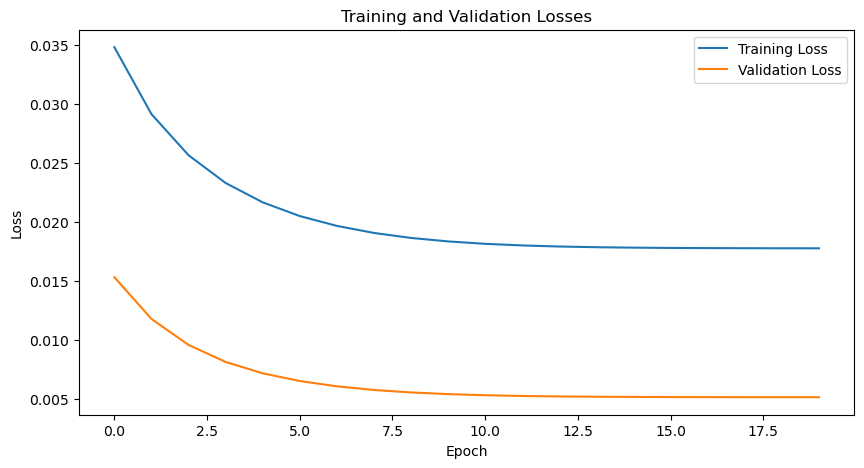

Epoch: 1 	Training Loss: 0.075882 	Validation Loss: 0.057610
Epoch: 2 	Training Loss: 0.021634 	Validation Loss: 0.009687
overwrite model
Epoch: 3 	Training Loss: 0.005021 	Validation Loss: 0.007353
overwrite model
Epoch: 4 	Training Loss: 0.004011 	Validation Loss: 0.006452
overwrite model
Epoch: 5 	Training Loss: 0.003579 	Validation Loss: 0.006005
overwrite model
Epoch: 6 	Training Loss: 0.003353 	Validation Loss: 0.005758
overwrite model
Epoch: 7 	Training Loss: 0.003226 	Validation Loss: 0.005613
overwrite model
Epoch: 8 	Training Loss: 0.003153 	Validation Loss: 0.005535
overwrite model
Epoch: 9 	Training Loss: 0.003114 	Validation Loss: 0.005496
overwrite model
Epoch: 10 	Training Loss: 0.003095 	Validation Loss: 0.005482
overwrite model
Epoch: 11 	Training Loss: 0.003089 	Validation Loss: 0.005483
Epoch: 12 	Training Loss: 0.003092 	Validation Loss: 0.005494
Epoch: 13 	Training Loss: 0.003101 	Validation Loss: 0.005511
Epoch: 14 	Training Loss: 0.003113 	Validation Loss: 0.0055

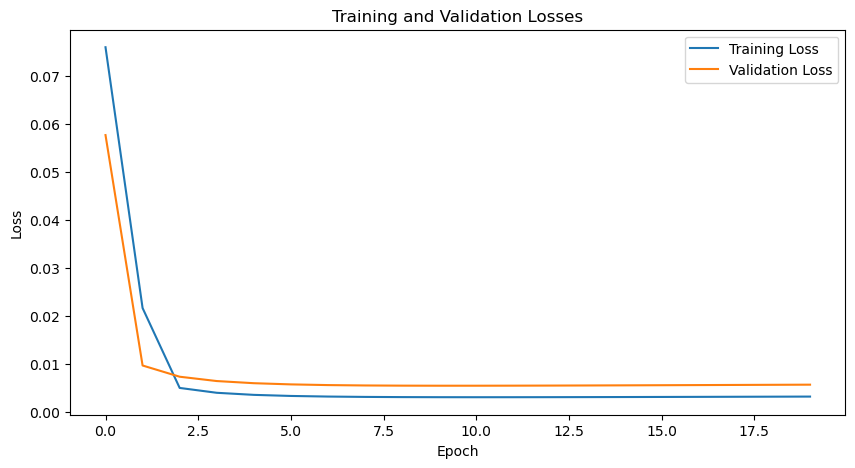

Epoch: 1 	Training Loss: 0.086159 	Validation Loss: 0.080925
Epoch: 2 	Training Loss: 0.047810 	Validation Loss: 0.031667
overwrite model
Epoch: 3 	Training Loss: 0.012620 	Validation Loss: 0.011945
overwrite model
Epoch: 4 	Training Loss: 0.006417 	Validation Loss: 0.009247
overwrite model
Epoch: 5 	Training Loss: 0.005083 	Validation Loss: 0.008041
overwrite model
Epoch: 6 	Training Loss: 0.004435 	Validation Loss: 0.007324
overwrite model
Epoch: 7 	Training Loss: 0.004062 	Validation Loss: 0.006840
overwrite model
Epoch: 8 	Training Loss: 0.003834 	Validation Loss: 0.006515
overwrite model
Epoch: 9 	Training Loss: 0.003692 	Validation Loss: 0.006301
overwrite model
Epoch: 10 	Training Loss: 0.003602 	Validation Loss: 0.006159
overwrite model
Epoch: 11 	Training Loss: 0.003546 	Validation Loss: 0.006066
overwrite model
Epoch: 12 	Training Loss: 0.003511 	Validation Loss: 0.006004
overwrite model
Epoch: 13 	Training Loss: 0.003490 	Validation Loss: 0.005965
overwrite model
Epoch: 14 	

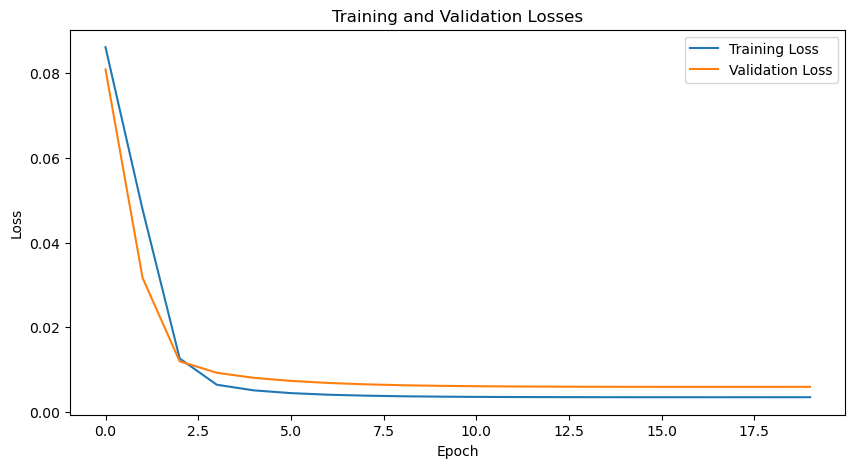

Epoch: 1 	Training Loss: 0.096991 	Validation Loss: 0.101234
Epoch: 2 	Training Loss: 0.079065 	Validation Loss: 0.083418
overwrite model
Epoch: 3 	Training Loss: 0.061707 	Validation Loss: 0.062272
overwrite model
Epoch: 4 	Training Loss: 0.037712 	Validation Loss: 0.030765
overwrite model
Epoch: 5 	Training Loss: 0.015151 	Validation Loss: 0.015452
overwrite model
Epoch: 6 	Training Loss: 0.008623 	Validation Loss: 0.011657
overwrite model
Epoch: 7 	Training Loss: 0.006755 	Validation Loss: 0.010041
overwrite model
Epoch: 8 	Training Loss: 0.005905 	Validation Loss: 0.009151
overwrite model
Epoch: 9 	Training Loss: 0.005431 	Validation Loss: 0.008605
overwrite model
Epoch: 10 	Training Loss: 0.005141 	Validation Loss: 0.008255
overwrite model
Epoch: 11 	Training Loss: 0.004960 	Validation Loss: 0.008045
overwrite model
Epoch: 12 	Training Loss: 0.004854 	Validation Loss: 0.007924
overwrite model
Epoch: 13 	Training Loss: 0.004795 	Validation Loss: 0.007859
overwrite model
Epoch: 14 	

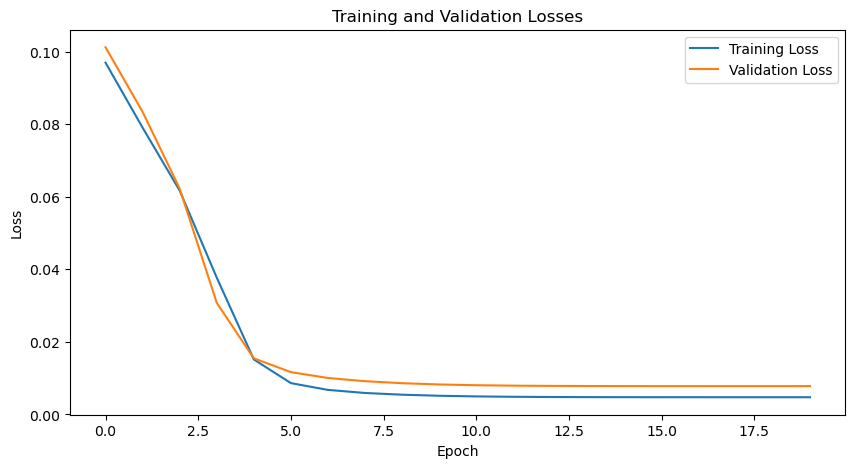

Epoch: 1 	Training Loss: 0.105659 	Validation Loss: 0.114278
Epoch: 2 	Training Loss: 0.094184 	Validation Loss: 0.104071
overwrite model
Epoch: 3 	Training Loss: 0.085486 	Validation Loss: 0.095544
overwrite model
Epoch: 4 	Training Loss: 0.077937 	Validation Loss: 0.087737
overwrite model
Epoch: 5 	Training Loss: 0.070683 	Validation Loss: 0.079687
overwrite model
Epoch: 6 	Training Loss: 0.062604 	Validation Loss: 0.069759
overwrite model
Epoch: 7 	Training Loss: 0.051518 	Validation Loss: 0.054460
overwrite model
Epoch: 8 	Training Loss: 0.034279 	Validation Loss: 0.032255
overwrite model
Epoch: 9 	Training Loss: 0.018113 	Validation Loss: 0.019998
overwrite model
Epoch: 10 	Training Loss: 0.012065 	Validation Loss: 0.016151
overwrite model
Epoch: 11 	Training Loss: 0.010034 	Validation Loss: 0.014564
overwrite model
Epoch: 12 	Training Loss: 0.009121 	Validation Loss: 0.013753
overwrite model
Epoch: 13 	Training Loss: 0.008638 	Validation Loss: 0.013313
overwrite model
Epoch: 14 	

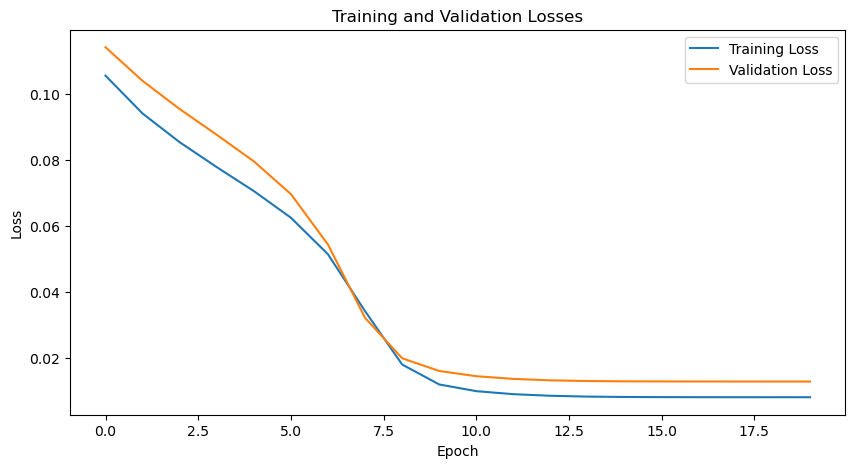

Epoch: 1 	Training Loss: 0.010293 	Validation Loss: 0.010644
Epoch: 2 	Training Loss: 0.005330 	Validation Loss: 0.007385
overwrite model
Epoch: 3 	Training Loss: 0.003376 	Validation Loss: 0.005759
overwrite model
Epoch: 4 	Training Loss: 0.002373 	Validation Loss: 0.004807
overwrite model
Epoch: 5 	Training Loss: 0.001779 	Validation Loss: 0.004176
overwrite model
Epoch: 6 	Training Loss: 0.001386 	Validation Loss: 0.003728
overwrite model
Epoch: 7 	Training Loss: 0.001119 	Validation Loss: 0.003414
overwrite model
Epoch: 8 	Training Loss: 0.000944 	Validation Loss: 0.003203
overwrite model
Epoch: 9 	Training Loss: 0.000834 	Validation Loss: 0.003067
overwrite model
Epoch: 10 	Training Loss: 0.000768 	Validation Loss: 0.002984
overwrite model
Epoch: 11 	Training Loss: 0.000730 	Validation Loss: 0.002935
overwrite model
Epoch: 12 	Training Loss: 0.000708 	Validation Loss: 0.002907
overwrite model
Epoch: 13 	Training Loss: 0.000696 	Validation Loss: 0.002891
overwrite model
Epoch: 14 	

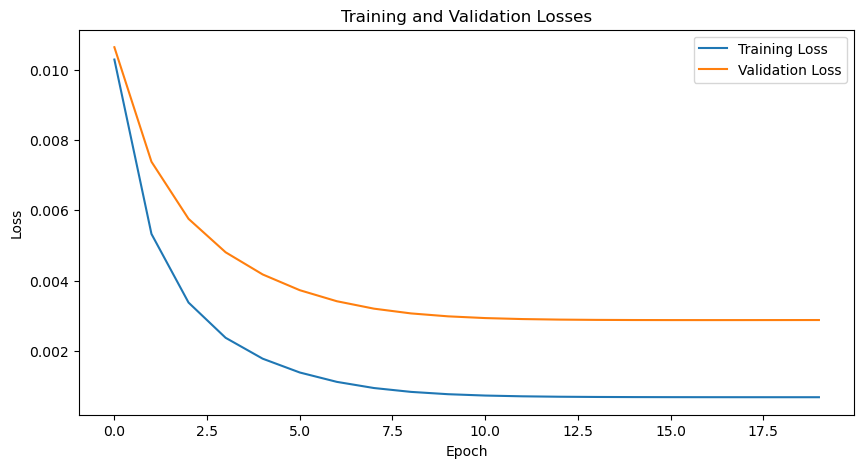

Epoch: 1 	Training Loss: 0.011840 	Validation Loss: 0.013147
Epoch: 2 	Training Loss: 0.007242 	Validation Loss: 0.010018
overwrite model
Epoch: 3 	Training Loss: 0.005120 	Validation Loss: 0.008360
overwrite model
Epoch: 4 	Training Loss: 0.003958 	Validation Loss: 0.007337
overwrite model
Epoch: 5 	Training Loss: 0.003231 	Validation Loss: 0.006625
overwrite model
Epoch: 6 	Training Loss: 0.002740 	Validation Loss: 0.006118
overwrite model
Epoch: 7 	Training Loss: 0.002411 	Validation Loss: 0.005771
overwrite model
Epoch: 8 	Training Loss: 0.002199 	Validation Loss: 0.005545
overwrite model
Epoch: 9 	Training Loss: 0.002066 	Validation Loss: 0.005402
overwrite model
Epoch: 10 	Training Loss: 0.001986 	Validation Loss: 0.005315
overwrite model
Epoch: 11 	Training Loss: 0.001939 	Validation Loss: 0.005263
overwrite model
Epoch: 12 	Training Loss: 0.001910 	Validation Loss: 0.005232
overwrite model
Epoch: 13 	Training Loss: 0.001894 	Validation Loss: 0.005215
overwrite model
Epoch: 14 	

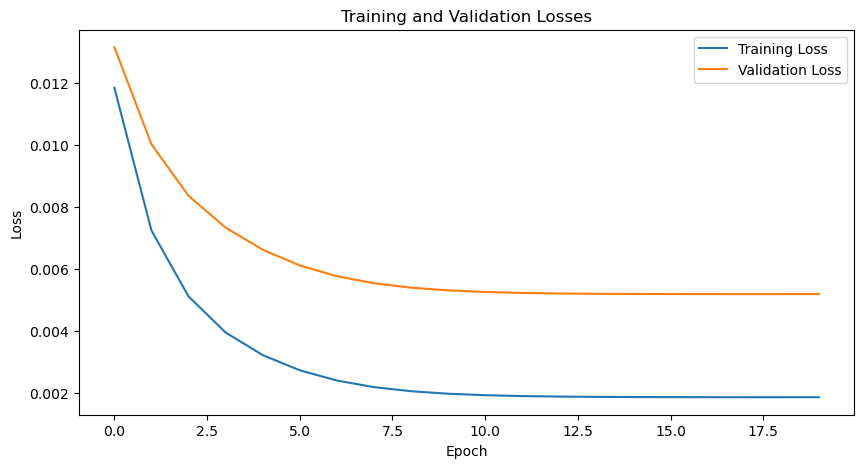

Epoch: 1 	Training Loss: 0.013008 	Validation Loss: 0.015990
Epoch: 2 	Training Loss: 0.008815 	Validation Loss: 0.012808
overwrite model
Epoch: 3 	Training Loss: 0.006561 	Validation Loss: 0.010897
overwrite model
Epoch: 4 	Training Loss: 0.005232 	Validation Loss: 0.009712
overwrite model
Epoch: 5 	Training Loss: 0.004433 	Validation Loss: 0.008977
overwrite model
Epoch: 6 	Training Loss: 0.003951 	Validation Loss: 0.008518
overwrite model
Epoch: 7 	Training Loss: 0.003658 	Validation Loss: 0.008230
overwrite model
error {'DLPN'}


In [39]:
# train model using list of companies

error_list = []
error_list_test_data = []
for index, company in enumerate(selected_companies):
    df_merged_company = df_merged_list[index]

    for output_dim in output_dims:

        try:
            # create dataset and dataloader =================================================

            # train, validation, test split
            train = df_merged_company[(df_merged_company.index >= '2012-01-01') & (df_merged_company.index <= '2019-12-31')]
            val = df_merged_company[(df_merged_company.index >= '2019-01-01') & (df_merged_company.index <= '2021-12-31')]
            test = df_merged_company[(df_merged_company.index >= '2020-01-01') & (df_merged_company.index <= '2022-12-31')]

            # create dataset
            train = StockPriceDataset(train, window_size, output_dim)
            val = StockPriceDataset(val, window_size, output_dim)
            test = StockPriceDataset(test, window_size, output_dim)

            # create dataloader
            train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, num_workers=num_workers)
            val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=num_workers)
            test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, num_workers=num_workers)

            # check if test_loader works
            try:
                for item in test_loader:
                    pass
            except:
                print('test_loader does not work! ', {company})
                error_list_test_data.append(company)


            # suppress SettingWithCopyWarning
            pd.options.mode.chained_assignment = None

            # initialize model, loss function, and optimizer =================================
            model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim, dropout).to(device)
            criterion = nn.HuberLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=learning_rate_step_size, gamma=learning_rate_decay)

            # training loop
            train_losses = []
            val_losses = []
            best_val_loss = 0.0
            val_loss_increase_count = 0
            save_current_model = True
            current_best_model = None
            current_best_optimizer = None

            for epoch in range(num_epochs):
                train_loss = 0.0
                val_loss = 0.0
                num_train_batches = 0
                num_val_batches = 0

                # train model
                model.train()
                for sequence in train_loader:
                    inputs, targets = sequence
                    targets = targets.squeeze(-1) # remove last dimension
                    optimizer.zero_grad()
                    output = model(inputs)
                    loss = criterion(output, targets)
                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()
                    num_train_batches += 1
                
                # validate model
                model.eval()
                with torch.no_grad():
                    for sequence in val_loader:
                        inputs, targets = sequence
                        targets = targets.squeeze(-1) # remove last dimension

                        output = model(inputs)
                        loss = criterion(output, targets)
                        
                        val_loss += loss.item()
                        num_val_batches += 1
                
                scheduler.step()
                train_loss /= num_train_batches
                val_loss /= num_val_batches
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, val_loss))

                if best_val_loss == 0.0:
                    best_val_loss = val_loss

                # save the best model
                if val_loss < best_val_loss:
                    print("overwrite model")
                    best_val_loss = val_loss
                    torch.save(model.state_dict(), f"model/lstm-{company}-{output_dim}-.pth")
                torch.save(model.state_dict(), f"model/lstm-{company}-{output_dim}-.pth")
            plot_losses(train_losses, val_losses)

            # save dataset in pickle file
            test_dataset_name = 'test_dataset-'
            company_name = company + '-' 
            predoction_days = output_dim.__str__() + '-'
            path = data_dir + test_dataset_name + company_name + predoction_days + '.pkl'
            with open(path, 'wb') as f:
                pickle.dump(test, f)
        except:
            print("error", {company})
            error_list.append(company)
    